In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import scipy
%matplotlib inline

import tensorflow as tf
from keras.applications import VGG19, InceptionV3
tfl = tf.keras.layers 

In [2]:
#Setting up parameters for images creation 

train_dir = 'celeb_faces_15k'
high_res = 64
low_res = 16

In [ ]:
#Codeblock only used when creating hi-res and low-res images for training purposes

for img in os.listdir( train_dir + '/org_images'):
    img_array = cv2.imread(train_dir + '/org_images/' + img)
    
    img_array = cv2.resize(img_array, (high_res, high_res))
    lr_img_array = cv2.resize(img_array,(low_res, low_res))
    cv2.imwrite(train_dir+ '/hr_images/' + img, img_array)
    cv2.imwrite(train_dir+ '/lr_images/' + img, lr_img_array)

## Model

Most of the hyperparameters are used from paper [1] only.

<img src = 'images_for_markdown/sr_gan.png' style = 'width:700px; height:400px;'>

In [3]:
#Residual and Upscaling blocks for building Generator Network

def res_block(inputs):
    
    residual = tfl.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(inputs)
    residual = tfl.BatchNormalization(momentum = 0.5)(residual)
    residual = tfl.PReLU(shared_axes = [1,2])(residual)
    
    residual = tfl.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(residual)
    residual = tfl.BatchNormalization(momentum = 0.5)(residual)
    
    return tfl.add([inputs, residual])

def upscaling(inputs):
    
    upscale_model = tfl.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(inputs)
    upscale_model = tfl.UpSampling2D(size = 2)(upscale_model)
    upscale_model = tfl.PReLU(shared_axes = [1,2])(upscale_model)
    
    return upscale_model

#Generator model

def create_generator(gen_inputs, num_res_block = 16):
    generator_model = tfl.Conv2D(filters = 64, kernel_size = (9, 9), strides = (1, 1), padding = 'same')(gen_inputs)
    generator_model = tfl.PReLU(shared_axes = [1,2])(generator_model)

    skip_connect = generator_model

    for i in range(num_res_block):
        generator_model = res_block(generator_model)

    generator_model = tfl.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(generator_model)
    generator_model = tfl.BatchNormalization(momentum = 0.5)(generator_model)
    generator_model = tfl.add([generator_model, skip_connect])

    generator_model = upscaling(generator_model)
    generator_model = upscaling(generator_model)
    #generator_model = upscaling(generator_model)

    gen_outputs = tfl.Conv2D(filters = 3, kernel_size = (9, 9), strides = (1, 1), padding = 'same')(generator_model)

    return tf.keras.Model(inputs = gen_inputs, outputs = gen_outputs)

In [4]:
#Discriminator block for building Discriminator Network

def discriminator_block(inputs, filters, strides = (1, 1), batchnorm = True):
    disc_model =  tfl.Conv2D(filters = filters, kernel_size = (3, 3), strides = strides, padding = 'same')(inputs)
    
    if batchnorm:
        disc_model = tfl.BatchNormalization(momentum = 0.8)(disc_model)

    disc_model = tfl.LeakyReLU(alpha = 0.2)(disc_model)

    return disc_model

#Discriminator Model

def create_discriminator(disc_inputs):
    filter_size_init = 64
    
    discriminator_model = discriminator_block(disc_inputs, filter_size_init, batchnorm = False)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init, strides = (2, 2))
    
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*2)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*2, strides = (2, 2))
    
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*4)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*4, strides = (2, 2))
    
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*8)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*8, strides = (2, 2))

    discriminator_model = tfl.Flatten()(discriminator_model)
    discriminator_model = tfl.Dense(units = filter_size_init*16)(discriminator_model)
    discriminator_model = tfl.LeakyReLU(alpha = 0.2)(discriminator_model)

    discriminator_model = tfl.Dense(units = 1, activation = 'sigmoid')(discriminator_model)

    return tf.keras.Model(disc_inputs, discriminator_model)

In [5]:
#VGG-19 model using weights from imagenet to get features of different images later.

def build_vgg(input_shape):
    
    vgg = VGG19(weights = 'imagenet', include_top = False, input_shape = input_shape)
    
    return tf.keras.Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

In [6]:
#Combining all three parts of the model - Generator, Discriminator and VGG

def combined_model(generator_model, discriminator_model, vgg, lr_inputs, hr_inputs):
    
    gen_img = generator_model(lr_inputs)
    
    gen_features = vgg(gen_img)
    
    discriminator_model.trainable = False

    score = discriminator_model(gen_img)
    
    return tf.keras.Model(inputs = [lr_inputs, hr_inputs], outputs= [score, gen_features])


In [7]:
#Selecting the number of images for training and creating low-res and hi-res datasets from them

num_images = 10000

lr_list = os.listdir('celeb_faces_15k/lr_images')[:num_images]
lr_images = []

for img in lr_list:
    img_lr = cv2.imread('celeb_faces_15k/lr_images/' + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir('celeb_faces_15k/hr_images')[:num_images]
hr_images = []

for img in hr_list:
    img_hr = cv2.imread('celeb_faces_15k/hr_images/' + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

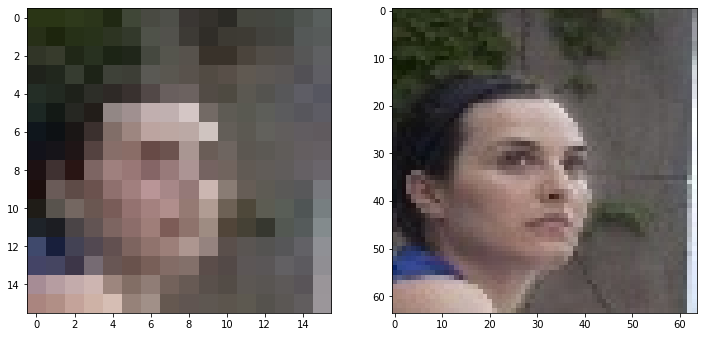

In [8]:
#Checking random images for consistency.

image_number = np.random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (low_res, low_res, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (high_res, high_res, 3)))
plt.show()

In [9]:
#Image Normalization

lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [10]:
#Train-test split

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size = 0.33, random_state = 42)

In [11]:
#Shape of the low-res and hi-res training images to be stored in keras Input.

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_inputs = tf.keras.Input(shape = lr_shape)
hr_inputs = tf.keras.Input(shape = hr_shape)

In [12]:
#Creating generator for GAN

generator = create_generator(lr_inputs)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 16, 16, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [13]:
#Creating discriminator for GAN

discriminator = create_discriminator(hr_inputs)
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                           

In [14]:
#VGG-19 model to extract features

vgg = build_vgg((high_res, high_res, 3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [15]:
#Full GAN model used for this problem

gan_model = combined_model(generator, discriminator, vgg, lr_inputs, hr_inputs)

gan_model.compile(loss = ['binary_crossentropy', 'mse'], loss_weights = [1e-3, 1], optimizer = 'adam')
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 64, 64, 3)    2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 1)            13083457    ['model[0][0]']                  
                                                                                            

In [16]:
#Setting up batch size and dividing the training dataset into batches

batch_size = 32
train_lr_batches = []
train_hr_batches = []
for i in range(int(hr_train.shape[0] / batch_size)):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [19]:
#Training the model

epochs = 50

for e in range(epochs):
    
    # Setting up the labels for fake and real images
    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size, 1))
    
    # Empty set for Generator and Discriminator losses, later used to calculate average of both losses
    g_losses = []
    d_losses = []
    
    batch_size_train = len(train_hr_batches)

    for b in tqdm(range(batch_size_train)):
        lr_images = train_lr_batches[b] 
        hr_images = train_hr_batches[b] 
        gen_images = generator.predict_on_batch(lr_images)

        # Training Discriminator using real and fake images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_images, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_images, real_label)
        
        # Training generator using low-res and high-res images with features taken from VGG-19.
        discriminator.trainable = False
        
        d_loss = np.add(d_loss_gen, d_loss_real) / 2
        
        image_features = vgg.predict(hr_images)
     
        g_loss, _, _ = gan_model.train_on_batch([lr_images, hr_images], [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    if (e+1) % 5 == 0:
        generator.save('output/generated_e' + str(e+1) + '.h5')

  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 1/209 [00:00<02:47,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<02:19,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<02:09,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 4/209 [00:02<02:05,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 5/209 [00:03<02:03,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:59,  1.69it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 7/209 [00:04<02:01,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/209 [00:04<01:58,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<01:56,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:06<01:55,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<01:55,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 12/209 [00:07<01:55,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 13/209 [00:07<01:54,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:08<01:52,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:51,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:09<01:50,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:10<01:49,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 18/209 [00:10<01:53,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 19/209 [00:11<01:56,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:11<01:53,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 21/209 [00:12<01:53,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:13<01:50,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 23/209 [00:13<01:50,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:14<01:49,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:14<01:47,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 26/209 [00:15<01:47,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 27/209 [00:16<01:47,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 28/209 [00:16<01:46,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 29/209 [00:17<01:47,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:17<01:45,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 31/209 [00:18<01:46,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 32/209 [00:19<01:46,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:19<01:44,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 34/209 [00:20<01:44,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 35/209 [00:20<01:42,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 36/209 [00:21<01:41,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 37/209 [00:21<01:41,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 38/209 [00:22<01:40,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:23<01:39,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:23<01:39,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 41/209 [00:24<01:38,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:24<01:37,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:25<01:41,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:26<01:38,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:26<01:36,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:27<01:34,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:27<01:34,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 48/209 [00:28<01:33,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 49/209 [00:28<01:32,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:29<01:30,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 51/209 [00:30<01:32,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 52/209 [00:30<01:30,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:31<01:29,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:31<01:28,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:32<01:28,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:33<01:27,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:33<01:26,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 58/209 [00:34<01:25,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:34<01:25,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:35<01:26,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:35<01:26,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:36<01:24,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:37<01:24,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 64/209 [00:37<01:23,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:38<01:22,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:38<01:21,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:39<01:21,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:39<01:20,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 69/209 [00:40<01:21,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 70/209 [00:41<01:21,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:41<01:20,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:42<01:21,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:42<01:20,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:43<01:18,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:44<01:17,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:44<01:17,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 77/209 [00:45<01:16,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:45<01:17,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 79/209 [00:46<01:18,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 80/209 [00:47<01:17,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:47<01:15,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:48<01:14,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 83/209 [00:48<01:12,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:49<01:11,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:49<01:11,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:50<01:10,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 87/209 [00:51<01:09,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [00:51<01:09,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:52<01:08,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:52<01:11,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 91/209 [00:53<01:10,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 92/209 [00:53<01:08,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 93/209 [00:54<01:09,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 94/209 [00:55<01:07,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 95/209 [00:55<01:07,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:56<01:07,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [00:57<01:08,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [00:57<01:06,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 99/209 [00:58<01:04,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [00:58<01:03,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:59<01:02,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 102/209 [00:59<01:01,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 103/209 [01:00<01:02,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 104/209 [01:01<01:02,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 105/209 [01:01<01:02,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 106/209 [01:02<01:00,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 107/209 [01:02<01:01,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:03<01:00,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 109/209 [01:04<01:00,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 110/209 [01:04<00:59,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:05<00:57,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:05<00:56,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:06<00:55,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:06<00:54,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:07<00:54,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 116/209 [01:08<00:53,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:08<00:52,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 118/209 [01:09<00:54,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:09<00:53,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 120/209 [01:10<00:52,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 121/209 [01:11<00:51,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:11<00:51,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 123/209 [01:12<00:50,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:12<00:49,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:13<00:47,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:13<00:46,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 127/209 [01:14<00:49,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:15<00:47,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:15<00:46,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:16<00:48,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:17<00:47,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:17<00:49,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 133/209 [01:18<00:52,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 134/209 [01:19<00:49,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:19<00:46,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:20<00:52,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 137/209 [01:21<00:48,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:21<00:45,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:22<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 140/209 [01:22<00:43,  1.58it/s]

1/1 [==============================] - 0s 83ms/step


 67%|██████▋   | 141/209 [01:23<00:46,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 142/209 [01:24<00:44,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 143/209 [01:25<00:46,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 144/209 [01:25<00:47,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 145/209 [01:26<00:44,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 146/209 [01:27<00:42,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 147/209 [01:27<00:40,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 148/209 [01:28<00:39,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 149/209 [01:29<00:38,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 150/209 [01:29<00:37,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:30<00:35,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 152/209 [01:30<00:33,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 153/209 [01:31<00:32,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:31<00:31,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 155/209 [01:32<00:30,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:32<00:29,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:33<00:28,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:34<00:28,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:34<00:27,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:35<00:26,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:35<00:26,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:36<00:25,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:36<00:25,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 164/209 [01:37<00:24,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 165/209 [01:37<00:24,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:38<00:23,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:39<00:22,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:39<00:22,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:40<00:21,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:40<00:21,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:41<00:20,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:41<00:20,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 173/209 [01:42<00:19,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 174/209 [01:42<00:19,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:43<00:19,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 176/209 [01:44<00:19,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:44<00:18,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:45<00:17,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:45<00:16,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:46<00:16,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:46<00:15,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:47<00:15,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 183/209 [01:47<00:14,  1.79it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 184/209 [01:48<00:14,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:49<00:13,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 186/209 [01:49<00:12,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:50<00:12,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:50<00:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:51<00:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:51<00:10,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [01:52<00:09,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:53<00:09,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:53<00:08,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:54<00:08,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:54<00:07,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 196/209 [01:55<00:07,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 197/209 [01:55<00:06,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 198/209 [01:56<00:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [01:56<00:05,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 200/209 [01:57<00:04,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 201/209 [01:57<00:04,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:58<00:03,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 203/209 [01:59<00:03,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:59<00:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [02:00<00:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [02:00<00:01,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [02:01<00:01,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [02:01<00:00,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/209 [00:00<01:57,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:53,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/209 [00:02<01:51,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:02<01:52,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:51,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 7/209 [00:03<01:50,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 8/209 [00:04<01:49,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 9/209 [00:04<01:48,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 10/209 [00:05<01:48,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 11/209 [00:06<01:47,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:47,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:46,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:46,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:45,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 16/209 [00:08<01:44,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 17/209 [00:09<01:44,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:09<01:43,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:43,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:10<01:42,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:41,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:11<01:41,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:40,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 24/209 [00:13<01:40,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:13<01:40,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:14<01:40,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 28/209 [00:15<01:39,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 29/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:16<01:38,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:17<01:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 34/209 [00:18<01:35,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:35,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 36/209 [00:19<01:34,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:33,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:20<01:33,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:32,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 40/209 [00:21<01:31,  1.84it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 42/209 [00:22<01:31,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:23<01:30,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:24<01:31,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:24<01:31,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:25<01:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:26<01:28,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 51/209 [00:27<01:26,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:28<01:25,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:29<01:25,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 54/209 [00:29<01:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:30<01:24,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 56/209 [00:30<01:23,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 57/209 [00:31<01:23,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:31<01:22,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:32<01:22,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 60/209 [00:32<01:21,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 61/209 [00:33<01:21,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 62/209 [00:33<01:20,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 63/209 [00:34<01:19,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 64/209 [00:35<01:19,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:35<01:19,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:36<01:18,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:37<01:16,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 70/209 [00:38<01:15,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 71/209 [00:38<01:15,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 72/209 [00:39<01:14,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:39<01:13,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:40<01:13,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 75/209 [00:41<01:12,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:41<01:12,  1.85it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 77/209 [00:42<01:11,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 78/209 [00:42<01:11,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:43<01:10,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:43<01:09,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:44<01:09,  1.85it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 82/209 [00:44<01:09,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:45<01:10,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 84/209 [00:45<01:08,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 85/209 [00:46<01:08,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 86/209 [00:47<01:08,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 87/209 [00:47<01:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:48<01:07,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:48<01:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:49<01:06,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 91/209 [00:49<01:05,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:50<01:04,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:50<01:03,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 94/209 [00:51<01:02,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 95/209 [00:52<01:02,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:52<01:01,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:53<01:01,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [00:53<01:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [00:54<01:00,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:54<00:59,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 101/209 [00:55<00:59,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 102/209 [00:55<00:58,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [00:56<00:58,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:56<00:57,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 105/209 [00:57<00:56,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [00:58<00:56,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [00:58<00:55,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 108/209 [00:59<00:55,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [00:59<00:54,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:00<00:54,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:00<00:53,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 112/209 [01:01<00:53,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 113/209 [01:01<00:52,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:02<00:52,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:03<00:51,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:03<00:50,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:04<00:50,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:04<00:50,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 119/209 [01:05<00:49,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:05<00:48,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 121/209 [01:06<00:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:06<00:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:07<00:47,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:07<00:46,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 125/209 [01:08<00:46,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:09<00:45,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 127/209 [01:09<00:45,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:10<00:44,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:10<00:43,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:11<00:43,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:11<00:42,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:12<00:42,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:12<00:42,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:13<00:41,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 135/209 [01:14<00:40,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 136/209 [01:14<00:40,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:15<00:40,  1.78it/s]

1/1 [==============================] - 0s 92ms/step


 66%|██████▌   | 138/209 [01:16<00:47,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 139/209 [01:16<00:45,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 140/209 [01:17<00:43,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 141/209 [01:17<00:41,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:18<00:39,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:18<00:38,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 144/209 [01:19<00:37,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:20<00:36,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:20<00:35,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:21<00:34,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:21<00:33,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 149/209 [01:22<00:33,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 150/209 [01:22<00:33,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 151/209 [01:23<00:32,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:23<00:31,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:24<00:31,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:25<00:30,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 155/209 [01:25<00:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:26<00:29,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:26<00:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:27<00:28,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:27<00:27,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:28<00:26,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:28<00:26,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:29<00:25,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 163/209 [01:29<00:25,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:30<00:24,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:31<00:23,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:31<00:23,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:32<00:22,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 168/209 [01:32<00:22,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:33<00:22,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:33<00:21,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 171/209 [01:34<00:20,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 172/209 [01:34<00:20,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:35<00:19,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:36<00:19,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:36<00:18,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:37<00:18,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:37<00:17,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:38<00:17,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:38<00:16,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:39<00:15,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 181/209 [01:39<00:15,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 182/209 [01:40<00:14,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 183/209 [01:40<00:14,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 184/209 [01:41<00:13,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:42<00:13,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:42<00:12,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:43<00:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:43<00:11,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:44<00:10,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:44<00:10,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:45<00:09,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:45<00:09,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 193/209 [01:46<00:08,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 194/209 [01:46<00:08,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:47<00:07,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:48<00:07,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:48<00:06,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:49<00:06,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:49<00:05,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:50<00:04,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:50<00:04,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:51<00:03,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:51<00:03,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:52<00:02,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:53<00:02,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [01:53<00:01,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 207/209 [01:54<00:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [01:54<00:00,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 1/209 [00:00<01:54,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:52,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<01:54,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 6/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 7/209 [00:03<01:51,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 8/209 [00:04<01:50,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 9/209 [00:04<01:49,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:49,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:48,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 12/209 [00:06<01:47,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 13/209 [00:07<01:47,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:46,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:45,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 16/209 [00:08<01:45,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:09<01:45,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:09<01:45,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:44,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:11<01:44,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:11<01:44,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 22/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 23/209 [00:12<01:42,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 25/209 [00:13<01:41,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:15<01:39,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:37,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:36,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:18<01:37,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 35/209 [00:19<01:35,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 36/209 [00:19<01:35,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:34,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 38/209 [00:20<01:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 40/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 41/209 [00:22<01:31,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 42/209 [00:23<01:31,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:23<01:31,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:24<01:30,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:24<01:29,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 46/209 [00:25<01:28,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:25<01:28,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:26<01:27,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:26<01:26,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 50/209 [00:27<01:26,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 51/209 [00:28<01:25,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 52/209 [00:28<01:25,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:25,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:29<01:24,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 55/209 [00:30<01:23,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:30<01:23,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:31<01:22,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 58/209 [00:31<01:22,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 59/209 [00:32<01:21,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 60/209 [00:32<01:21,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:33<01:20,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 62/209 [00:33<01:19,  1.85it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 63/209 [00:34<01:19,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:35<01:18,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:35<01:17,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:17,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 67/209 [00:36<01:17,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:37<01:17,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:38<01:16,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:38<01:15,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:39<01:15,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:40<01:14,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 74/209 [00:40<01:13,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:41<01:13,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:41<01:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [00:42<01:11,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:42<01:11,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:43<01:11,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 80/209 [00:43<01:10,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:44<01:09,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:44<01:09,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:45<01:09,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:46<01:08,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:46<01:07,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 86/209 [00:47<01:07,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:47<01:06,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 88/209 [00:48<01:05,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:48<01:05,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:49<01:05,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:49<01:04,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:50<01:03,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:50<01:03,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:51<01:02,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 95/209 [00:52<01:02,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:52<01:01,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:53<01:00,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 98/209 [00:53<01:00,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [00:54<01:01,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:54<01:00,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 101/209 [00:55<00:59,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 102/209 [00:55<00:58,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 103/209 [00:56<00:57,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 104/209 [00:56<00:57,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 105/209 [00:57<00:57,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [00:58<00:56,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 107/209 [00:58<00:55,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [00:59<00:54,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [00:59<00:54,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:00<00:53,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:00<00:53,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:01<00:52,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:01<00:52,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:02<00:57,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:03<00:55,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:03<00:53,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 117/209 [01:04<00:52,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:04<00:51,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 119/209 [01:05<00:50,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 120/209 [01:05<00:50,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:06<00:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:07<00:48,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:07<00:47,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:08<00:47,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 125/209 [01:08<00:47,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:09<00:46,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 127/209 [01:09<00:46,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 128/209 [01:10<00:45,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 129/209 [01:10<00:44,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 130/209 [01:11<00:44,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:12<00:43,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:12<00:42,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:13<00:41,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:13<00:41,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:14<00:40,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:14<00:39,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:15<00:39,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:15<00:38,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:16<00:38,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:17<00:37,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 141/209 [01:17<00:37,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:18<00:36,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:18<00:36,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:19<00:35,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 145/209 [01:19<00:35,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:20<00:34,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:20<00:34,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:21<00:33,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:21<00:32,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:22<00:32,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:23<00:32,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 152/209 [01:23<00:31,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 153/209 [01:24<00:30,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 154/209 [01:24<00:31,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 155/209 [01:25<00:30,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:25<00:29,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:26<00:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:26<00:28,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 159/209 [01:27<00:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:28<00:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:28<00:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:29<00:26,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:29<00:25,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 164/209 [01:30<00:24,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 165/209 [01:30<00:24,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:31<00:23,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:31<00:23,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:32<00:22,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:33<00:21,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:33<00:21,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:34<00:21,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 172/209 [01:34<00:20,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 173/209 [01:35<00:19,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 174/209 [01:35<00:19,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 175/209 [01:36<00:18,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 176/209 [01:36<00:18,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 177/209 [01:37<00:17,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:38<00:17,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 179/209 [01:38<00:16,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 180/209 [01:39<00:15,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 181/209 [01:39<00:15,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:40<00:14,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 183/209 [01:40<00:14,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 184/209 [01:41<00:13,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:41<00:13,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 186/209 [01:42<00:12,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:42<00:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:43<00:11,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:44<00:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:44<00:10,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 191/209 [01:45<00:09,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:45<00:09,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:46<00:08,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 194/209 [01:46<00:08,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 195/209 [01:47<00:07,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 196/209 [01:47<00:07,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:48<00:06,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 198/209 [01:49<00:06,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:49<00:05,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:50<00:04,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:50<00:04,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:51<00:03,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:51<00:03,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:52<00:02,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:52<00:02,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [01:53<00:01,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [01:53<00:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [01:54<00:00,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/209 [00:00<01:55,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:54,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<01:53,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:51,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:51,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:51,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:03<01:50,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 8/209 [00:04<01:49,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 9/209 [00:04<01:49,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:48,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:47,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:47,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:08<01:46,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:09<01:45,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:09<01:44,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:44,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:10<01:42,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:42,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:42,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:41,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:13<01:40,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 27/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 29/209 [00:15<01:39,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:38,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 32/209 [00:17<01:37,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:35,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:34,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 36/209 [00:19<01:34,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:20<01:35,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 39/209 [00:21<01:34,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:22<01:33,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 41/209 [00:22<01:33,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 42/209 [00:23<01:32,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:23<01:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:24<01:30,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:25<01:29,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:25<01:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:26<01:28,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:26<01:27,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:28<01:28,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:28<01:29,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:29<01:27,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:29<01:26,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 56/209 [00:30<01:23,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:31<01:23,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:31<01:22,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:32<01:22,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 60/209 [00:33<01:21,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:33<01:21,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 62/209 [00:34<01:20,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:34<01:19,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 64/209 [00:35<01:19,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:35<01:18,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 67/209 [00:36<01:19,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:38<01:17,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 71/209 [00:39<01:16,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 72/209 [00:39<01:15,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:40<01:14,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 74/209 [00:40<01:14,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:41<01:13,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 76/209 [00:41<01:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [00:42<01:12,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 78/209 [00:42<01:12,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 79/209 [00:43<01:11,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 80/209 [00:44<01:11,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:44<01:10,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 82/209 [00:45<01:10,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 83/209 [00:45<01:09,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 84/209 [00:46<01:08,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 85/209 [00:46<01:08,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:47<01:07,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 87/209 [00:47<01:06,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:48<01:06,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:49<01:06,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:49<01:06,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:50<01:04,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:51<01:03,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 94/209 [00:51<01:02,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:52<01:02,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:52<01:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:53<01:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 98/209 [00:54<01:02,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:54<01:02,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:55<01:01,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:55<01:01,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 102/209 [00:56<01:00,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 103/209 [00:56<00:59,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 104/209 [00:57<00:58,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 105/209 [00:57<00:58,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [00:58<00:58,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 107/209 [00:59<00:57,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 108/209 [00:59<00:56,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 109/209 [01:00<00:56,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:00<00:55,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:01<00:55,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:01<00:54,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:02<00:53,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:03<00:53,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 115/209 [01:03<00:52,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:04<00:51,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:05<00:50,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:05<00:50,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 120/209 [01:06<00:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:06<00:49,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:07<00:48,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 123/209 [01:08<00:48,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:08<00:47,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:09<00:47,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:09<00:46,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 127/209 [01:10<00:45,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 128/209 [01:10<00:44,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:11<00:44,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:11<00:43,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:12<00:42,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:13<00:41,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 134/209 [01:14<00:41,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:14<00:40,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:15<00:40,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:15<00:39,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:16<00:38,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:16<00:38,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 140/209 [01:17<00:38,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:18<00:37,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:19<00:36,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:20<00:36,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:20<00:35,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 147/209 [01:21<00:35,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 148/209 [01:21<00:34,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:22<00:34,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 150/209 [01:23<00:33,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 151/209 [01:23<00:32,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:24<00:32,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:24<00:31,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:25<00:30,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:25<00:30,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:26<00:29,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:27<00:29,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:27<00:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:28<00:27,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:29<00:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 164/209 [01:30<00:24,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 165/209 [01:31<00:24,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:32<00:24,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 167/209 [01:32<00:23,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:33<00:22,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:34<00:21,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:34<00:21,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 172/209 [01:35<00:20,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:35<00:20,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:36<00:19,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:37<00:18,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:38<00:17,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:39<00:16,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:39<00:16,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 181/209 [01:40<00:15,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 182/209 [01:40<00:15,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 183/209 [01:41<00:14,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:42<00:13,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:43<00:12,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:44<00:11,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 190/209 [01:45<00:10,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 191/209 [01:46<00:10,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:46<00:09,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 193/209 [01:47<00:09,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:47<00:08,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:48<00:07,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:48<00:07,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:49<00:06,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 198/209 [01:49<00:06,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 199/209 [01:50<00:05,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:51<00:05,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:51<00:04,  1.73it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 202/209 [01:52<00:04,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 204/209 [01:53<00:03,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [01:54<00:01,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:57,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 2/209 [00:01<02:07,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<02:07,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 4/209 [00:02<02:09,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 5/209 [00:03<02:12,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 6/209 [00:03<02:17,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 7/209 [00:04<02:16,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 8/209 [00:05<02:11,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 9/209 [00:05<02:11,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 10/209 [00:06<02:20,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 11/209 [00:07<02:20,  1.41it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 12/209 [00:08<02:19,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 13/209 [00:08<02:11,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 14/209 [00:09<02:05,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 15/209 [00:09<02:04,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:10<02:00,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:11<01:56,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 18/209 [00:11<01:54,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 19/209 [00:12<01:56,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 20/209 [00:12<01:55,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 21/209 [00:13<01:54,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 22/209 [00:14<01:56,  1.60it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 23/209 [00:14<02:01,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:15<01:59,  1.54it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█▏        | 25/209 [00:16<02:12,  1.39it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 26/209 [00:17<02:11,  1.39it/s]

1/1 [==============================] - 0s 74ms/step


 13%|█▎        | 27/209 [00:17<02:13,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 28/209 [00:18<02:10,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 29/209 [00:19<02:10,  1.38it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 30/209 [00:20<02:13,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:20<02:08,  1.38it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 32/209 [00:21<02:13,  1.33it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 33/209 [00:22<02:14,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 34/209 [00:23<02:11,  1.33it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 35/209 [00:23<02:11,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 36/209 [00:24<02:07,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 37/209 [00:25<01:58,  1.45it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 38/209 [00:25<02:00,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 39/209 [00:26<01:57,  1.45it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 40/209 [00:27<01:54,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 41/209 [00:27<01:48,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 42/209 [00:28<01:43,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:28<01:39,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 44/209 [00:29<01:39,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:30<01:38,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 46/209 [00:30<01:42,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 47/209 [00:31<01:42,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 48/209 [00:32<01:40,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:32<01:37,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 50/209 [00:33<01:37,  1.62it/s]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 51/209 [00:33<01:44,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:34<01:39,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:35<01:35,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:35<01:33,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:36<01:31,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:36<01:29,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 57/209 [00:37<01:32,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:38<01:30,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 59/209 [00:38<01:30,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 60/209 [00:39<01:33,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 61/209 [00:39<01:32,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 62/209 [00:40<01:30,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 63/209 [00:41<01:28,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 64/209 [00:41<01:25,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 65/209 [00:42<01:26,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 66/209 [00:42<01:26,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:43<01:24,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:44<01:23,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:44<01:22,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 70/209 [00:45<01:20,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 71/209 [00:45<01:20,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:46<01:21,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 73/209 [00:47<01:20,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 74/209 [00:47<01:19,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:48<01:18,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:48<01:16,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [00:49<01:14,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [00:49<01:15,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 79/209 [00:50<01:14,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:51<01:13,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:51<01:11,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 82/209 [00:52<01:11,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:52<01:10,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 84/209 [00:53<01:14,  1.67it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 85/209 [00:53<01:14,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:54<01:12,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:55<01:10,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:55<01:09,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 89/209 [00:56<01:09,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:56<01:08,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:57<01:08,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:57<01:07,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 93/209 [00:58<01:06,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:59<01:05,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 95/209 [00:59<01:04,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 96/209 [01:00<01:04,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 97/209 [01:00<01:06,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [01:01<01:04,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 99/209 [01:01<01:03,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [01:02<01:02,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [01:03<01:01,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 102/209 [01:03<01:01,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 103/209 [01:04<01:01,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 104/209 [01:04<01:00,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 105/209 [01:05<00:59,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [01:05<00:58,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 107/209 [01:06<00:58,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:07<00:57,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 109/209 [01:07<00:58,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:08<00:57,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 111/209 [01:08<00:56,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:09<00:55,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:10<00:54,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:10<00:53,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:11<00:52,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:11<00:51,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 117/209 [01:12<00:52,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:12<00:51,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 119/209 [01:13<00:50,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:13<00:49,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 121/209 [01:14<00:49,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 122/209 [01:15<00:49,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:15<00:48,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:16<00:47,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:16<00:46,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:17<00:46,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 127/209 [01:17<00:45,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 128/209 [01:18<00:45,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 129/209 [01:19<00:46,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:19<00:45,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 131/209 [01:20<00:45,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 132/209 [01:20<00:44,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:21<00:44,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:21<00:43,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:22<00:42,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:23<00:41,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:23<00:40,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:24<00:39,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:24<00:39,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:25<00:38,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:25<00:37,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:26<00:37,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:26<00:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:27<00:36,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 145/209 [01:28<00:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 146/209 [01:28<00:35,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:29<00:34,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:29<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:30<00:33,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:30<00:32,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 151/209 [01:31<00:32,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 152/209 [01:31<00:31,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 153/209 [01:32<00:31,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:33<00:30,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:33<00:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:34<00:29,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:34<00:29,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:35<00:28,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 159/209 [01:35<00:28,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:36<00:27,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:37<00:26,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:37<00:26,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:38<00:25,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 164/209 [01:38<00:25,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 165/209 [01:39<00:25,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 166/209 [01:39<00:24,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:40<00:23,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 168/209 [01:40<00:23,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:41<00:22,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:42<00:22,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:42<00:21,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 172/209 [01:43<00:21,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 173/209 [01:43<00:20,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 174/209 [01:44<00:19,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 175/209 [01:44<00:19,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:45<00:18,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:46<00:18,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 178/209 [01:46<00:17,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 179/209 [01:47<00:16,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 180/209 [01:47<00:16,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:48<00:16,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:48<00:15,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 183/209 [01:49<00:14,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 184/209 [01:50<00:14,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 185/209 [01:50<00:14,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:51<00:13,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 187/209 [01:51<00:12,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:52<00:12,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 189/209 [01:53<00:11,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:53<00:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:54<00:10,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:54<00:09,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:55<00:09,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 194/209 [01:55<00:08,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [01:56<00:07,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 196/209 [01:57<00:07,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:57<00:06,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:58<00:06,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 199/209 [01:58<00:05,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 200/209 [01:59<00:05,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 201/209 [02:00<00:04,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 202/209 [02:00<00:04,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 203/209 [02:01<00:03,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 204/209 [02:01<00:03,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 205/209 [02:02<00:02,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [02:03<00:01,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [02:03<00:01,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 208/209 [02:04<00:00,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 209/209 [02:04<00:00,  1.67it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 1/209 [00:00<02:03,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<02:01,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<01:59,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 4/209 [00:02<01:59,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 5/209 [00:02<01:58,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 6/209 [00:03<01:58,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 7/209 [00:04<01:59,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 8/209 [00:04<01:59,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 9/209 [00:05<02:00,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 10/209 [00:05<01:59,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 11/209 [00:06<01:58,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 12/209 [00:07<02:00,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 13/209 [00:07<01:58,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 14/209 [00:08<01:56,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 15/209 [00:08<01:56,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:09<01:54,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:10<01:53,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 18/209 [00:10<01:53,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 19/209 [00:11<01:52,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 20/209 [00:11<01:51,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:12<01:50,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/209 [00:13<01:48,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 23/209 [00:13<01:47,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 24/209 [00:14<01:47,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 25/209 [00:14<01:48,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:15<01:47,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 27/209 [00:15<01:48,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 28/209 [00:16<01:48,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:17<01:46,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 30/209 [00:17<01:46,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 31/209 [00:18<01:45,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 32/209 [00:18<01:44,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 33/209 [00:19<01:44,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 34/209 [00:20<01:42,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:20<01:44,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 36/209 [00:21<01:42,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:21<01:41,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 38/209 [00:22<01:40,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 39/209 [00:23<01:40,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 40/209 [00:23<01:39,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 41/209 [00:24<01:41,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 42/209 [00:24<01:39,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 43/209 [00:25<01:39,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 44/209 [00:26<01:38,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 45/209 [00:26<01:38,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:27<01:36,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 47/209 [00:27<01:35,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 48/209 [00:28<01:34,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 49/209 [00:28<01:33,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:29<01:32,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 51/209 [00:30<01:31,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 52/209 [00:30<01:34,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 53/209 [00:31<01:33,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:31<01:31,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:32<01:31,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:33<01:29,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:33<01:28,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:34<01:28,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 59/209 [00:34<01:27,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:35<01:26,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 61/209 [00:36<01:25,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 62/209 [00:36<01:25,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 63/209 [00:37<01:24,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 64/209 [00:37<01:24,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 65/209 [00:38<01:23,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:38<01:22,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 67/209 [00:39<01:23,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:40<01:22,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:40<01:20,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:41<01:20,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:41<01:19,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:42<01:18,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 73/209 [00:42<01:18,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 74/209 [00:43<01:18,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 75/209 [00:44<01:17,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 76/209 [00:44<01:17,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 77/209 [00:45<01:17,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:45<01:16,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:46<01:16,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 80/209 [00:47<01:16,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 81/209 [00:47<01:15,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 82/209 [00:48<01:14,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 83/209 [00:48<01:13,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 84/209 [00:49<01:12,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 85/209 [00:50<01:12,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 86/209 [00:50<01:11,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:51<01:10,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:51<01:10,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:52<01:09,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 90/209 [00:52<01:08,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 91/209 [00:53<01:08,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 92/209 [00:54<01:08,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:54<01:07,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 94/209 [00:55<01:06,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 95/209 [00:55<01:06,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [00:56<01:05,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 97/209 [00:56<01:04,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 98/209 [00:57<01:03,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [00:58<01:03,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 100/209 [00:58<01:02,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [00:59<01:02,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 102/209 [00:59<01:01,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [01:00<01:00,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [01:00<01:00,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 105/209 [01:01<00:59,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 106/209 [01:02<00:59,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:02<00:59,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:03<00:58,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 109/209 [01:03<00:58,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 110/209 [01:04<00:57,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:05<00:56,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 112/209 [01:05<00:55,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 113/209 [01:06<00:55,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 114/209 [01:06<00:54,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:07<00:54,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:07<00:53,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 117/209 [01:08<00:52,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 118/209 [01:09<00:52,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:09<00:51,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:10<00:51,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:10<00:50,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 122/209 [01:11<00:49,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 123/209 [01:11<00:49,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 124/209 [01:12<00:49,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 125/209 [01:13<00:48,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:13<00:48,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:14<00:47,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 128/209 [01:14<00:46,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:15<00:46,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:15<00:45,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:16<00:44,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 132/209 [01:17<00:44,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 133/209 [01:17<00:43,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 134/209 [01:18<00:43,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:18<00:42,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 136/209 [01:19<00:42,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 137/209 [01:20<00:41,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 138/209 [01:20<00:41,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:21<00:40,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:21<00:40,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 141/209 [01:22<00:39,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 142/209 [01:22<00:39,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 143/209 [01:23<00:39,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 144/209 [01:24<00:38,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 145/209 [01:24<00:38,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:25<00:37,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 147/209 [01:26<00:37,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 148/209 [01:26<00:36,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:27<00:35,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:27<00:34,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:28<00:33,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:28<00:33,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 153/209 [01:29<00:32,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 154/209 [01:30<00:31,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:30<00:31,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 156/209 [01:31<00:30,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:31<00:30,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 158/209 [01:32<00:29,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 159/209 [01:33<00:29,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:33<00:28,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:34<00:28,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 162/209 [01:34<00:27,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:35<00:26,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:35<00:26,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 165/209 [01:36<00:25,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 166/209 [01:37<00:24,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:37<00:24,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 168/209 [01:38<00:23,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 169/209 [01:38<00:22,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:39<00:22,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:39<00:21,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:40<00:21,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:41<00:20,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 174/209 [01:41<00:20,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:42<00:19,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:42<00:19,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 177/209 [01:43<00:18,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 178/209 [01:43<00:18,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:44<00:17,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:45<00:16,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 181/209 [01:45<00:16,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 182/209 [01:46<00:15,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:46<00:15,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 184/209 [01:47<00:14,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:48<00:14,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:48<00:13,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 187/209 [01:49<00:12,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:49<00:12,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [01:50<00:11,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:50<00:10,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:51<00:10,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 192/209 [01:52<00:10,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 193/209 [01:52<00:09,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 194/209 [01:53<00:08,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:53<00:08,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 196/209 [01:54<00:07,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:55<00:07,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 198/209 [01:55<00:06,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 199/209 [01:56<00:05,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:56<00:05,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 201/209 [01:57<00:04,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:57<00:04,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:58<00:03,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 204/209 [01:59<00:02,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 205/209 [01:59<00:02,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 206/209 [02:00<00:01,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 207/209 [02:00<00:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [02:01<00:00,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/209 [00:00<02:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<02:02,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 3/209 [00:01<01:59,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 4/209 [00:02<01:58,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:56,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 6/209 [00:03<01:58,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:04<01:58,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/209 [00:04<01:56,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 9/209 [00:05<01:56,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:05<01:56,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<01:55,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 12/209 [00:06<01:54,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 13/209 [00:07<01:53,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 14/209 [00:08<01:52,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:52,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:09<01:51,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 17/209 [00:09<01:51,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:49,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 19/209 [00:11<01:49,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 20/209 [00:11<01:49,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 21/209 [00:12<01:48,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:47,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 23/209 [00:13<01:47,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 24/209 [00:13<01:47,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:14<01:46,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 26/209 [00:15<01:46,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 27/209 [00:15<01:45,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 28/209 [00:16<01:44,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 29/209 [00:16<01:46,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:17<01:45,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:18<01:43,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 32/209 [00:18<01:41,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 33/209 [00:19<01:42,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:19<01:40,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 35/209 [00:20<01:41,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 36/209 [00:20<01:42,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:21<01:41,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:22<01:39,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 39/209 [00:22<01:39,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 40/209 [00:23<01:39,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:23<01:37,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 42/209 [00:24<01:38,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 43/209 [00:25<01:37,  1.70it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 44/209 [00:25<01:35,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:26<01:33,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:26<01:31,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:27<01:30,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:27<01:29,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 49/209 [00:28<01:29,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:28<01:29,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 51/209 [00:29<01:34,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 52/209 [00:30<01:34,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:30<01:31,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 54/209 [00:31<01:32,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:31<01:31,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 56/209 [00:32<01:31,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 57/209 [00:33<01:29,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:33<01:28,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:34<01:29,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:34<01:29,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 61/209 [00:35<01:31,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 62/209 [00:36<01:32,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:36<01:29,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:37<01:27,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 65/209 [00:38<01:25,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:38<01:24,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:39<01:23,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [00:39<01:22,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 69/209 [00:40<01:21,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 70/209 [00:41<01:24,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:41<01:24,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:42<01:26,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 73/209 [00:42<01:26,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 74/209 [00:43<01:26,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:44<01:26,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 76/209 [00:44<01:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 77/209 [00:45<01:21,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:46<01:20,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 79/209 [00:46<01:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 80/209 [00:47<01:26,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 81/209 [00:48<01:22,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:48<01:18,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:49<01:15,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:49<01:14,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:50<01:12,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:50<01:11,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:51<01:10,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 88/209 [00:52<01:10,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:52<01:08,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:53<01:07,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:53<01:05,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:54<01:04,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:54<01:04,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:55<01:03,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:55<01:02,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:56<01:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:56<01:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [00:57<01:00,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:58<01:00,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:58<00:59,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:59<00:58,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 102/209 [00:59<00:58,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 103/209 [01:00<00:57,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 104/209 [01:00<00:57,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [01:01<00:57,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [01:01<00:56,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 107/209 [01:02<00:56,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [01:03<00:55,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 109/209 [01:03<00:56,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:04<00:55,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:04<00:56,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:05<00:55,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 113/209 [01:05<00:55,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 114/209 [01:06<00:55,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 115/209 [01:07<00:54,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:07<00:53,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:08<00:52,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:08<00:51,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:09<00:50,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 120/209 [01:09<00:51,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 121/209 [01:10<00:53,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:11<00:51,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 123/209 [01:11<00:51,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:12<00:50,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:12<00:49,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:13<00:47,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:14<00:46,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:14<00:46,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:15<00:45,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:15<00:44,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:16<00:43,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:16<00:43,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:17<00:42,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:17<00:42,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:18<00:41,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:19<00:40,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:19<00:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:20<00:40,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 139/209 [01:20<00:39,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 140/209 [01:21<00:38,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 141/209 [01:21<00:38,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:22<00:37,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 143/209 [01:22<00:36,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:23<00:35,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 145/209 [01:24<00:35,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 146/209 [01:24<00:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 147/209 [01:25<00:34,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:25<00:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:26<00:33,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:26<00:32,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:27<00:32,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 152/209 [01:27<00:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:28<00:30,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:29<00:30,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:29<00:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:30<00:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:30<00:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:31<00:28,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:31<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:32<00:26,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:32<00:26,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:33<00:25,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:34<00:25,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 164/209 [01:34<00:24,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:35<00:24,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:35<00:23,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:36<00:23,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 168/209 [01:36<00:22,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:37<00:22,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:37<00:21,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:38<00:21,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 172/209 [01:39<00:20,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 173/209 [01:39<00:21,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:40<00:20,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 175/209 [01:40<00:19,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:41<00:18,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 177/209 [01:41<00:18,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:42<00:17,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:43<00:16,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 180/209 [01:43<00:17,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 181/209 [01:44<00:16,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 182/209 [01:44<00:15,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:45<00:15,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 184/209 [01:46<00:15,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:46<00:14,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:47<00:13,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:47<00:13,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:48<00:12,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 189/209 [01:49<00:12,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 190/209 [01:49<00:11,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:50<00:11,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 192/209 [01:50<00:10,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:51<00:09,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [01:52<00:09,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 195/209 [01:52<00:08,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:53<00:07,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 197/209 [01:53<00:07,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:54<00:06,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [01:55<00:05,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:55<00:05,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 201/209 [01:56<00:04,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 202/209 [01:56<00:04,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 203/209 [01:57<00:03,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 204/209 [01:57<00:02,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [01:58<00:02,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 206/209 [01:59<00:01,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 207/209 [01:59<00:01,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 208/209 [02:00<00:00,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<02:04,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 2/209 [00:01<02:05,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 3/209 [00:01<02:02,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<02:00,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/209 [00:02<01:59,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:57,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 7/209 [00:04<02:00,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 8/209 [00:04<02:01,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<02:01,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:05<02:00,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<01:58,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:07<01:56,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 13/209 [00:07<01:57,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 14/209 [00:08<01:56,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 15/209 [00:08<01:55,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 16/209 [00:09<01:53,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:10<01:54,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 18/209 [00:10<01:52,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 19/209 [00:11<01:52,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:51,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:12<01:50,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 22/209 [00:13<01:49,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 23/209 [00:13<01:52,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 24/209 [00:14<01:48,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:14<01:46,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:15<01:47,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 27/209 [00:15<01:45,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 28/209 [00:16<01:44,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:17<01:41,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:17<01:40,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:18<01:39,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 32/209 [00:18<01:39,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:19<01:39,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:19<01:38,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 35/209 [00:20<01:38,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 36/209 [00:21<01:43,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:21<01:41,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:22<01:38,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 39/209 [00:22<01:36,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 40/209 [00:23<01:34,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:23<01:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:24<01:32,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:24<01:31,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:25<01:30,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:26<01:30,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:26<01:29,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:27<01:29,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:27<01:28,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:28<01:27,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:28<01:27,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:29<01:26,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:29<01:25,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 53/209 [00:30<01:25,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:31<01:24,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 55/209 [00:31<01:24,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 56/209 [00:32<01:24,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 57/209 [00:32<01:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:33<01:23,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 59/209 [00:33<01:22,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 60/209 [00:34<01:23,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 61/209 [00:34<01:22,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:35<01:21,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 63/209 [00:36<01:21,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 64/209 [00:36<01:19,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:37<01:19,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:37<01:18,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:38<01:18,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:38<01:17,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:39<01:16,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:39<01:16,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:40<01:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:41<01:16,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:41<01:16,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 74/209 [00:42<01:16,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 75/209 [00:42<01:16,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:43<01:17,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 77/209 [00:43<01:17,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [00:44<01:16,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 79/209 [00:45<01:16,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:45<01:15,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:46<01:12,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:46<01:11,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:47<01:10,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:47<01:09,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:48<01:08,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:49<01:10,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:49<01:09,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:50<01:08,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:50<01:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:51<01:06,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 91/209 [00:51<01:05,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:52<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:52<01:04,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:53<01:03,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 95/209 [00:53<01:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:54<01:01,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:55<01:01,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 98/209 [00:55<01:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [00:56<01:00,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 100/209 [00:56<00:59,  1.82it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 101/209 [00:57<01:01,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 102/209 [00:57<01:02,  1.71it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 103/209 [00:58<01:05,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 104/209 [00:59<01:03,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 105/209 [00:59<01:00,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 106/209 [01:00<01:01,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:01<01:02,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 108/209 [01:01<01:04,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 109/209 [01:02<01:03,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 110/209 [01:02<01:01,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 111/209 [01:03<00:59,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 112/209 [01:04<00:59,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:04<00:58,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 114/209 [01:05<00:57,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 115/209 [01:05<00:55,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 116/209 [01:06<00:54,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:07<00:52,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:07<00:51,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:08<00:50,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:08<00:50,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:09<00:49,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:09<00:48,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 123/209 [01:10<00:47,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:10<00:47,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 125/209 [01:11<00:48,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:12<00:48,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 127/209 [01:12<00:47,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:13<00:46,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:13<00:45,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:14<00:44,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:14<00:43,  1.78it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 132/209 [01:15<00:43,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:16<00:42,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:16<00:41,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:17<00:40,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:17<00:40,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:18<00:39,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:18<00:38,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:19<00:38,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 140/209 [01:19<00:38,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 141/209 [01:20<00:37,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 142/209 [01:21<00:36,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:21<00:36,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:22<00:36,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:22<00:36,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 146/209 [01:23<00:36,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:23<00:35,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:24<00:34,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 149/209 [01:24<00:33,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 150/209 [01:25<00:33,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 151/209 [01:26<00:32,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 152/209 [01:26<00:32,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 153/209 [01:27<00:31,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:27<00:30,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:28<00:30,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:28<00:29,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:29<00:28,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:30<00:28,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 159/209 [01:30<00:27,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 160/209 [01:31<00:27,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:31<00:26,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:32<00:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:32<00:25,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:33<00:24,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:33<00:24,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:34<00:23,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 167/209 [01:35<00:23,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 168/209 [01:35<00:22,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 169/209 [01:36<00:23,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 170/209 [01:36<00:22,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 171/209 [01:37<00:22,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 172/209 [01:37<00:21,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 173/209 [01:38<00:20,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 174/209 [01:39<00:20,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 175/209 [01:39<00:19,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:40<00:18,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:40<00:17,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:41<00:17,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:41<00:16,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 180/209 [01:42<00:16,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 181/209 [01:42<00:15,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 182/209 [01:43<00:14,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 183/209 [01:44<00:14,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 184/209 [01:44<00:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 185/209 [01:45<00:13,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:45<00:12,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:46<00:12,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:46<00:11,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:47<00:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:47<00:10,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:48<00:09,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:49<00:09,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 193/209 [01:49<00:09,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [01:50<00:08,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:50<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:51<00:07,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 197/209 [01:51<00:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:52<00:06,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:52<00:05,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 200/209 [01:53<00:04,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [01:54<00:04,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 202/209 [01:54<00:03,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:55<00:03,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:55<00:02,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [01:56<00:02,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [01:56<00:01,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 207/209 [01:57<00:01,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 208/209 [01:57<00:00,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<01:53,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 2/209 [00:01<01:54,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 3/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:53,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 5/209 [00:02<01:52,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:52,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 9/209 [00:05<01:52,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:51,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 12/209 [00:06<01:50,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 16/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:09<01:46,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:46,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:44,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:11<01:44,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:42,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:42,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 25/209 [00:13<01:43,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:14<01:42,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:41,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:37,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:37,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:35,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 36/209 [00:19<01:35,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:34,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:22<01:32,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 42/209 [00:23<01:31,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:23<01:31,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:30,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:24<01:29,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 46/209 [00:25<01:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:26<01:29,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 49/209 [00:27<01:28,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:28<01:26,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:28<01:26,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:25,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 54/209 [00:29<01:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:30<01:24,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:31<01:23,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 59/209 [00:32<01:22,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 60/209 [00:33<01:21,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 61/209 [00:33<01:21,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:34<01:20,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:34<01:20,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:35<01:19,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:35<01:19,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:38<01:18,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:38<01:17,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 71/209 [00:39<01:16,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 72/209 [00:39<01:15,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 74/209 [00:40<01:14,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 75/209 [00:41<01:14,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 76/209 [00:42<01:13,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 77/209 [00:42<01:12,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:43<01:12,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:43<01:11,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:44<01:11,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 81/209 [00:44<01:10,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 82/209 [00:45<01:09,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:45<01:09,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 84/209 [00:46<01:08,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 85/209 [00:47<01:08,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:47<01:07,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:48<01:07,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 88/209 [00:48<01:06,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 89/209 [00:49<01:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:49<01:07,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 92/209 [00:50<01:05,  1.80it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 93/209 [00:51<01:05,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:52<01:04,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 95/209 [00:52<01:04,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 96/209 [00:53<01:03,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:53<01:02,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:54<01:00,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 100/209 [00:55<01:00,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 101/209 [00:55<01:00,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 102/209 [00:56<01:00,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 103/209 [00:57<00:59,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:57<00:58,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 105/209 [00:58<00:58,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 106/209 [00:58<00:58,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [00:59<00:57,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [00:59<00:57,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:00<01:02,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:01<00:59,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:01<00:57,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:02<00:55,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:02<00:54,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 114/209 [01:03<00:53,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 115/209 [01:04<00:57,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:04<00:54,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:05<00:53,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:05<00:51,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:06<00:50,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:06<00:49,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 121/209 [01:07<00:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:07<00:48,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:08<00:47,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:09<00:46,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:09<00:46,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:10<00:45,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 127/209 [01:10<00:44,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:11<00:44,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:11<00:43,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:12<00:43,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:12<00:42,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 133/209 [01:13<00:41,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:14<00:41,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:15<00:40,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 136/209 [01:15<00:40,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:16<00:39,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:16<00:39,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:17<00:38,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 142/209 [01:18<00:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:20<00:35,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 146/209 [01:21<00:34,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 147/209 [01:21<00:34,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 148/209 [01:22<00:34,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 149/209 [01:22<00:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 151/209 [01:23<00:31,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 152/209 [01:24<00:31,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:25<00:30,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:25<00:30,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 155/209 [01:26<00:29,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:26<00:28,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:27<00:28,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 158/209 [01:27<00:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:28<00:27,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:30<00:25,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 164/209 [01:31<00:24,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 165/209 [01:31<00:24,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:32<00:23,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 167/209 [01:32<00:23,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:33<00:21,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████▏ | 170/209 [01:34<00:21,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:34<00:20,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:35<00:20,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:36<00:19,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:36<00:19,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:37<00:18,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 178/209 [01:38<00:17,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:39<00:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:39<00:15,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 181/209 [01:40<00:15,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:41<00:14,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 183/209 [01:41<00:14,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:42<00:13,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:43<00:12,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:44<00:11,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 190/209 [01:45<00:10,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:45<00:09,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 192/209 [01:46<00:09,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 194/209 [01:47<00:08,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [01:48<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:48<00:07,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:49<00:06,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:49<00:06,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:50<00:05,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [01:50<00:05,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 201/209 [01:51<00:04,  1.75it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 202/209 [01:52<00:04,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:52<00:03,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 204/209 [01:53<00:02,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:53<00:02,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 206/209 [01:54<00:01,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [01:55<00:00,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 1/209 [00:00<01:54,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:53,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<01:52,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:52,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 6/209 [00:03<01:54,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 7/209 [00:03<01:54,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:52,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 9/209 [00:05<01:51,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:49,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:49,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 12/209 [00:06<02:01,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 13/209 [00:07<02:03,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 14/209 [00:08<02:05,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 15/209 [00:08<02:04,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:09<02:03,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:10<02:07,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 18/209 [00:10<02:06,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 19/209 [00:11<02:01,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 20/209 [00:12<01:56,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:12<01:52,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:13<01:50,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 23/209 [00:13<01:48,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 24/209 [00:14<01:46,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:14<01:46,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:15<01:46,  1.72it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 27/209 [00:15<01:43,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:16<01:42,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 29/209 [00:17<01:42,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:17<01:41,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:18<01:40,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:18<01:38,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 33/209 [00:19<01:38,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 34/209 [00:19<01:36,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 35/209 [00:20<01:36,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 36/209 [00:21<01:39,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:21<01:37,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:22<01:36,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 39/209 [00:22<01:34,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 40/209 [00:23<01:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:23<01:32,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:24<01:31,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 43/209 [00:24<01:33,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 44/209 [00:25<01:33,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:26<01:32,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 46/209 [00:26<01:32,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 47/209 [00:27<01:30,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:27<01:29,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 49/209 [00:28<01:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 50/209 [00:28<01:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 51/209 [00:29<01:27,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 52/209 [00:29<01:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:30<01:26,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 54/209 [00:31<01:25,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 55/209 [00:31<01:25,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:32<01:25,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:32<01:24,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 58/209 [00:33<01:23,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 59/209 [00:33<01:22,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 60/209 [00:34<01:21,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:34<01:21,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:35<01:20,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:36<01:20,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 64/209 [00:36<01:21,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:37<01:20,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:37<01:19,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 67/209 [00:38<01:18,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [00:38<01:18,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 69/209 [00:39<01:17,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:39<01:16,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:40<01:17,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 72/209 [00:41<01:17,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:41<01:16,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:42<01:15,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 75/209 [00:42<01:15,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:43<01:13,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [00:43<01:13,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 78/209 [00:44<01:11,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:44<01:11,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:45<01:10,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 81/209 [00:46<01:11,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 82/209 [00:46<01:10,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:47<01:09,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:47<01:09,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 85/209 [00:48<01:09,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 86/209 [00:48<01:08,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:49<01:08,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:49<01:08,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 89/209 [00:50<01:07,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:51<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:51<01:05,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 92/209 [00:52<01:05,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 93/209 [00:52<01:04,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:53<01:04,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 95/209 [00:53<01:03,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:54<01:02,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:54<01:02,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [00:55<01:02,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [00:56<01:02,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:56<01:02,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [00:57<01:03,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 102/209 [00:57<01:01,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [00:58<01:02,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 104/209 [00:59<01:01,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [00:59<00:59,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [01:00<00:58,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 107/209 [01:00<00:57,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:01<00:57,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:01<00:56,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 110/209 [01:02<00:57,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:03<00:55,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:03<00:55,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 113/209 [01:04<00:55,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 114/209 [01:04<00:54,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 115/209 [01:05<00:53,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:05<00:52,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 117/209 [01:06<00:51,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 118/209 [01:06<00:51,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:07<00:50,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:08<00:50,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:08<00:49,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:09<00:48,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:09<00:47,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:10<00:47,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:10<00:46,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:11<00:46,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 127/209 [01:12<00:46,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 128/209 [01:12<00:47,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:13<00:47,  1.68it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 130/209 [01:13<00:45,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:14<00:45,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 132/209 [01:14<00:43,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:15<00:42,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 134/209 [01:16<00:44,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 135/209 [01:16<00:43,  1.71it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 136/209 [01:17<00:43,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:17<00:41,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:18<00:40,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:18<00:39,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 140/209 [01:19<00:38,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 141/209 [01:20<00:38,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:20<00:37,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:21<00:36,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 144/209 [01:21<00:36,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:22<00:35,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:22<00:34,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:23<00:35,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:24<00:34,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 149/209 [01:24<00:33,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 150/209 [01:25<00:32,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 151/209 [01:25<00:32,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:26<00:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:26<00:30,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:27<00:30,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:27<00:29,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:28<00:29,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:28<00:28,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 158/209 [01:29<00:28,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 159/209 [01:30<00:27,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 160/209 [01:30<00:26,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:31<00:26,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:31<00:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 163/209 [01:32<00:25,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 164/209 [01:32<00:24,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:33<00:24,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:33<00:23,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 167/209 [01:34<00:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 168/209 [01:35<00:22,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 169/209 [01:35<00:22,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 170/209 [01:36<00:21,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 171/209 [01:36<00:21,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 172/209 [01:37<00:21,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:38<00:22,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:38<00:21,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:39<00:20,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:39<00:19,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 177/209 [01:40<00:18,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:40<00:17,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:41<00:17,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 180/209 [01:42<00:16,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:42<00:16,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:43<00:16,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 183/209 [01:44<00:16,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 184/209 [01:44<00:15,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:45<00:14,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 186/209 [01:45<00:13,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:46<00:12,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:46<00:12,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [01:47<00:11,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:48<00:11,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [01:48<00:10,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:49<00:09,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 193/209 [01:49<00:09,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 194/209 [01:50<00:08,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 195/209 [01:51<00:08,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:51<00:07,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 197/209 [01:52<00:06,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:52<00:06,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:53<00:05,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 200/209 [01:53<00:05,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:54<00:04,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 202/209 [01:55<00:04,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:55<00:03,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:56<00:02,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:56<00:02,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [01:57<00:01,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 207/209 [01:57<00:01,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [01:58<00:00,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 209/209 [01:59<00:00,  1.76it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 1/209 [00:00<01:53,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<02:00,  1.72it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 3/209 [00:01<01:56,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:53,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 6/209 [00:03<01:51,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:03<01:50,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/209 [00:04<01:50,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 9/209 [00:04<01:49,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:49,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 13/209 [00:07<01:47,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 14/209 [00:07<01:47,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 15/209 [00:08<01:46,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:08<01:46,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:09<01:48,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:09<01:46,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:11<01:45,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:43,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:12<01:42,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:41,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:13<01:40,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 27/209 [00:14<01:39,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:39,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 29/209 [00:16<01:40,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:42,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:40,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:18<01:39,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 34/209 [00:18<01:39,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 35/209 [00:19<01:39,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 36/209 [00:20<01:37,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 37/209 [00:20<01:36,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 41/209 [00:22<01:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:23<01:32,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:23<01:31,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:31,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:25<01:31,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:26<01:31,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:34,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:27<01:35,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 50/209 [00:28<01:36,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 51/209 [00:28<01:37,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 52/209 [00:29<01:35,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:32,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:30<01:30,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 55/209 [00:30<01:30,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 56/209 [00:31<01:29,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:32<01:27,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:28,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 59/209 [00:33<01:28,  1.70it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 60/209 [00:33<01:26,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:34<01:24,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:34<01:23,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 63/209 [00:35<01:24,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:36<01:23,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:36<01:21,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:37<01:20,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 67/209 [00:37<01:21,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:38<01:22,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:39<01:20,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:39<01:19,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 71/209 [00:40<01:18,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:40<01:19,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:41<01:17,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 74/209 [00:41<01:16,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 75/209 [00:42<01:15,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:43<01:15,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 77/209 [00:43<01:14,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 78/209 [00:44<01:13,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:44<01:12,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:45<01:11,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:45<01:10,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:46<01:11,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:46<01:10,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 84/209 [00:47<01:09,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 85/209 [00:47<01:08,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:48<01:07,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:49<01:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 89/209 [00:50<01:06,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 91/209 [00:51<01:05,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:52<01:03,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 94/209 [00:52<01:02,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 95/209 [00:53<01:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:54<01:01,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 97/209 [00:54<01:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [00:55<01:00,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 99/209 [00:55<01:00,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 100/209 [00:56<01:00,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 102/209 [00:57<01:00,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 103/209 [00:58<01:01,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:58<01:00,  1.74it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 105/209 [00:59<00:58,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 106/209 [00:59<00:59,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 107/209 [01:00<00:59,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:00<01:00,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:01<00:58,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:02<00:57,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:02<00:56,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:03<00:55,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 113/209 [01:03<00:54,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:04<00:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:04<00:52,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:05<00:51,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:06<00:51,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:06<00:50,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:07<00:50,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:07<00:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:08<00:48,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:08<00:48,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:09<00:47,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 124/209 [01:09<00:47,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 125/209 [01:10<00:46,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:11<00:46,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 127/209 [01:11<00:45,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 128/209 [01:12<00:44,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 130/209 [01:13<00:43,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:13<00:42,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 132/209 [01:14<00:43,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▎   | 133/209 [01:14<00:42,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:15<00:42,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 135/209 [01:16<00:42,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:16<00:42,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:17<00:41,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 138/209 [01:17<00:41,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:18<00:43,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 140/209 [01:19<00:41,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 141/209 [01:19<00:40,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:20<00:39,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:20<00:37,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:21<00:36,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:21<00:36,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:22<00:35,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:23<00:33,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:24<00:33,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 150/209 [01:24<00:33,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:25<00:32,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 152/209 [01:25<00:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:26<00:31,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:26<00:30,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:27<00:30,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:28<00:29,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 157/209 [01:28<00:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:29<00:28,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:29<00:28,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:30<00:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:30<00:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:31<00:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:31<00:25,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:32<00:24,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 165/209 [01:33<00:24,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:33<00:23,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 167/209 [01:34<00:23,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:34<00:22,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:35<00:22,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:35<00:21,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:36<00:22,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:37<00:21,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:37<00:20,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:38<00:19,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:38<00:19,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:39<00:18,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:39<00:17,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:40<00:17,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:40<00:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:41<00:15,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:41<00:15,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:42<00:14,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 183/209 [01:43<00:14,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 184/209 [01:43<00:13,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:44<00:13,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:44<00:12,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:45<00:12,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 188/209 [01:45<00:11,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 189/209 [01:46<00:11,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [01:47<00:09,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 192/209 [01:48<00:09,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 193/209 [01:48<00:08,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 194/209 [01:49<00:08,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:50<00:07,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 198/209 [01:51<00:06,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:52<00:05,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 201/209 [01:53<00:04,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:53<00:03,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:54<00:03,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:55<00:02,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [01:56<00:01,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<02:02,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:53,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/209 [00:02<01:52,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:51,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 6/209 [00:03<01:51,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 7/209 [00:03<01:51,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 8/209 [00:04<01:54,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<01:52,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:05<01:53,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 11/209 [00:06<01:51,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 12/209 [00:06<01:53,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:52,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 14/209 [00:07<01:51,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:51,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 16/209 [00:09<01:49,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 17/209 [00:09<01:50,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 18/209 [00:10<01:51,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:48,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:11<01:47,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:45,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 23/209 [00:12<01:42,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:42,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 27/209 [00:15<01:39,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:38,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 29/209 [00:16<01:37,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:37,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 31/209 [00:17<01:37,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:36,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 33/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 34/209 [00:18<01:36,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 36/209 [00:20<01:35,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 37/209 [00:20<01:36,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 40/209 [00:22<01:33,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:23<01:31,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:23<01:32,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:24<01:31,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 45/209 [00:25<01:31,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:26<01:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:26<01:28,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 49/209 [00:27<01:27,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:28<01:27,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:28<01:29,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:27,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:30<01:27,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:30<01:26,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:31<01:26,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 57/209 [00:31<01:25,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:25,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:32<01:24,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 60/209 [00:33<01:23,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 61/209 [00:34<01:22,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:34<01:22,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:35<01:22,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:35<01:23,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:36<01:21,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:20,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:37<01:19,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 70/209 [00:39<01:16,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:39<01:16,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 72/209 [00:40<01:15,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:40<01:14,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 74/209 [00:41<01:13,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:41<01:13,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 76/209 [00:42<01:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [00:42<01:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:43<01:11,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:43<01:11,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:44<01:13,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 81/209 [00:45<01:12,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 82/209 [00:45<01:11,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 83/209 [00:46<01:11,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 84/209 [00:47<01:22,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 85/209 [00:47<01:21,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:48<01:16,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:48<01:14,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 88/209 [00:49<01:14,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 89/209 [00:50<01:13,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 90/209 [00:50<01:16,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 91/209 [00:51<01:12,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:51<01:09,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:52<01:07,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 94/209 [00:53<01:06,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 95/209 [00:53<01:05,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 96/209 [00:54<01:04,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:54<01:03,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [00:55<01:02,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:56<01:00,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:57<00:58,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 103/209 [00:58<00:57,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 104/209 [00:58<00:57,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 105/209 [00:59<00:56,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [00:59<00:56,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [01:00<00:55,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 108/209 [01:00<00:55,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:01<00:54,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:01<00:54,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:02<00:53,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:02<00:53,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 113/209 [01:03<00:52,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 114/209 [01:04<00:51,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:04<00:51,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:05<00:50,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:05<00:50,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:06<00:49,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:06<00:48,  1.85it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 120/209 [01:07<00:48,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 121/209 [01:07<00:47,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:08<00:47,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:08<00:46,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:09<00:46,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:10<00:45,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:10<00:45,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:11<00:44,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:11<00:44,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:12<00:43,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:12<00:43,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:14<00:41,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:14<00:41,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:15<00:40,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:16<00:39,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:16<00:39,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 140/209 [01:18<00:37,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:19<00:36,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 146/209 [01:21<00:35,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 149/209 [01:23<00:32,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 151/209 [01:24<00:31,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 152/209 [01:24<00:31,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 153/209 [01:25<00:30,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:25<00:29,  1.85it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 155/209 [01:26<00:29,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:27<00:28,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:27<00:28,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:28<00:27,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 160/209 [01:29<00:26,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:30<00:25,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:31<00:24,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:31<00:24,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:32<00:23,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [01:33<00:22,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:34<00:22,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 172/209 [01:35<00:21,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 173/209 [01:36<00:24,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:37<00:22,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:37<00:21,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:38<00:19,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:39<00:19,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 178/209 [01:39<00:18,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 179/209 [01:40<00:17,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 180/209 [01:40<00:17,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 181/209 [01:41<00:16,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 182/209 [01:42<00:15,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 183/209 [01:42<00:15,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 184/209 [01:43<00:14,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:44<00:13,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:45<00:11,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 191/209 [01:47<00:10,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [01:48<00:08,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [01:52<00:04,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:53<00:03,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.81it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 1/209 [00:00<01:56,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<01:55,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:54,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<01:52,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 10/209 [00:05<01:51,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:52,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:50,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:48,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:08<01:47,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:09<01:46,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 18/209 [00:10<01:46,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 20/209 [00:11<01:44,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:44,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:44,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 23/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:13<01:42,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:13<01:41,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 26/209 [00:14<01:41,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 31/209 [00:17<01:41,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:40,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:18<01:38,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:18<01:37,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:35,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 39/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 40/209 [00:22<01:33,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:22<01:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:23<01:32,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 43/209 [00:23<01:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:25<01:30,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:26<01:29,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:28,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 49/209 [00:27<01:28,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 51/209 [00:28<01:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:28<01:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 54/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:30<01:24,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:31<01:24,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:32<01:23,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 60/209 [00:33<01:23,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:33<01:22,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:34<01:21,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 63/209 [00:35<01:21,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:35<01:20,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:36<01:19,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:19,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 68/209 [00:37<01:18,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:38<01:17,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:39<01:16,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:40<01:16,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 74/209 [00:41<01:15,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:41<01:14,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:42<01:13,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 77/209 [00:42<01:13,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:43<01:12,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:43<01:12,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:44<01:11,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 82/209 [00:45<01:10,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 83/209 [00:46<01:09,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:46<01:09,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 85/209 [00:47<01:08,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:47<01:08,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:48<01:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:48<01:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:49<01:06,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:50<01:08,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:50<01:07,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:51<01:06,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:51<01:05,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:52<01:04,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:52<01:03,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:53<01:02,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:53<01:02,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 99/209 [00:55<01:02,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 100/209 [00:55<01:03,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:56<01:02,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 102/209 [00:56<01:01,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 103/209 [00:57<01:00,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 104/209 [00:57<00:59,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [00:58<00:58,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 106/209 [00:59<00:57,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [00:59<00:57,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [01:00<00:56,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:00<00:55,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:01<00:54,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:01<00:54,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 112/209 [01:02<00:53,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 113/209 [01:02<00:52,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:03<00:52,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 115/209 [01:04<00:51,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:04<00:50,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:05<00:50,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 118/209 [01:05<00:49,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:06<00:49,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:06<00:49,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:07<00:48,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 122/209 [01:07<00:48,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:08<00:49,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:09<00:48,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 125/209 [01:09<00:48,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:10<00:47,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 127/209 [01:10<00:46,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 128/209 [01:11<00:46,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 129/209 [01:11<00:45,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:12<00:44,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:13<00:44,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 132/209 [01:13<00:43,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:14<00:42,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:14<00:41,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:15<00:41,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:15<00:40,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:16<00:40,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 138/209 [01:16<00:39,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:17<00:39,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:20<00:36,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:20<00:35,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:21<00:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 147/209 [01:21<00:34,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:24<00:32,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 152/209 [01:24<00:31,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:25<00:30,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:26<00:30,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 156/209 [01:26<00:29,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:27<00:28,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 162/209 [01:30<00:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:31<00:24,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:31<00:24,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:32<00:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:33<00:23,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:34<00:21,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:35<00:20,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 173/209 [01:36<00:20,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:36<00:19,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:37<00:19,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:39<00:16,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:40<00:15,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 182/209 [01:41<00:15,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 184/209 [01:42<00:14,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:46<00:10,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:48<00:07,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:49<00:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 200/209 [01:51<00:05,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:52<00:04,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:53<00:02,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:55,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<01:54,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:53,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 6/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 7/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:52,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:51,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:50,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:49,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:08<01:46,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:09<01:46,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:10<01:45,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:44,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:11<01:43,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:44,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:13<01:42,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:13<01:41,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:41,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 27/209 [00:14<01:40,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 31/209 [00:17<01:38,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:38,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:39,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:38,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:19<01:37,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:36,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 38/209 [00:21<01:35,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:22<01:34,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 42/209 [00:23<01:33,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:23<01:32,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:32,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:25<01:31,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:26<01:32,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:26<01:30,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:27<01:29,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:27<01:28,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 51/209 [00:28<01:30,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:29<01:28,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:29<01:29,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:30<01:27,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 55/209 [00:30<01:27,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 56/209 [00:31<01:26,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 57/209 [00:31<01:25,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:24,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:32<01:23,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 60/209 [00:33<01:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:34<01:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:34<01:21,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:35<01:21,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 64/209 [00:35<01:21,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:36<01:20,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:36<01:20,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:37<01:19,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 68/209 [00:37<01:18,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:38<01:18,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 70/209 [00:39<01:19,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 71/209 [00:39<01:20,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:40<01:24,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:41<01:22,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 74/209 [00:41<01:21,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 75/209 [00:42<01:18,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:42<01:16,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [00:43<01:15,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:43<01:14,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:44<01:13,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 80/209 [00:44<01:12,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:46<01:10,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:46<01:10,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:47<01:09,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:47<01:08,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:48<01:07,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 87/209 [00:48<01:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 89/209 [00:49<01:06,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:50<01:05,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:51<01:04,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:52<01:03,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:52<01:03,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 95/209 [00:53<01:02,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [00:53<01:02,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 97/209 [00:54<01:03,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [00:54<01:02,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 100/209 [00:56<01:00,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:56<01:00,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 102/209 [00:57<01:00,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [00:57<00:59,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 104/209 [00:58<00:58,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 105/209 [00:58<00:57,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [00:59<00:56,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 107/209 [00:59<00:56,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 108/209 [01:00<00:55,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:01<00:55,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:01<00:54,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:02<00:53,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 112/209 [01:02<00:53,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:03<00:52,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:03<00:52,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 115/209 [01:04<00:51,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:05<00:50,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 118/209 [01:05<00:49,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:06<00:49,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 120/209 [01:07<00:48,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:07<00:48,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:08<00:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:08<00:47,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:09<00:46,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:09<00:46,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:10<00:45,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 127/209 [01:10<00:45,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 128/209 [01:11<00:44,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 130/209 [01:12<00:43,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 132/209 [01:13<00:43,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:14<00:42,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:14<00:42,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:15<00:41,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:15<00:40,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 137/209 [01:16<00:40,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 145/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 146/209 [01:21<00:34,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:23<00:34,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:23<00:33,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 151/209 [01:24<00:32,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 152/209 [01:24<00:31,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:26<00:31,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:26<00:30,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:27<00:29,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:27<00:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:31<00:24,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:32<00:23,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:34<00:21,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 172/209 [01:35<00:20,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:36<00:19,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:39<00:16,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:40<00:15,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 182/209 [01:41<00:14,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:45<00:10,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████▏| 191/209 [01:46<00:10,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:48<00:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:49<00:06,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:50<00:05,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:51<00:04,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:52<00:03,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:53<00:02,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 206/209 [01:54<00:01,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 208/209 [01:55<00:00,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:55,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 4/209 [00:02<01:56,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 5/209 [00:02<01:54,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 8/209 [00:04<01:54,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:56,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 10/209 [00:05<01:53,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<01:52,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 12/209 [00:06<01:50,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 14/209 [00:07<01:48,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 16/209 [00:08<01:47,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:09<01:47,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:46,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 20/209 [00:11<01:47,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 21/209 [00:11<01:48,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 22/209 [00:12<01:46,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 23/209 [00:12<01:45,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 24/209 [00:13<01:50,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 25/209 [00:14<01:48,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:45,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 27/209 [00:15<01:43,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:42,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:16<01:40,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:39,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:18<01:38,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 33/209 [00:18<01:37,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 34/209 [00:19<01:36,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 36/209 [00:20<01:35,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:22<01:33,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:23<01:32,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 42/209 [00:23<01:32,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:24<01:33,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 44/209 [00:24<01:31,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:25<01:30,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 46/209 [00:25<01:29,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:26<01:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 49/209 [00:27<01:28,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:28<01:28,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:28<01:27,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:29<01:26,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:30<01:26,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 56/209 [00:31<01:24,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 59/209 [00:33<01:22,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 60/209 [00:33<01:21,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:34<01:21,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 62/209 [00:34<01:20,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:35<01:20,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 64/209 [00:35<01:20,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:36<01:19,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:38<01:16,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 70/209 [00:39<01:16,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:39<01:15,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:40<01:15,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 73/209 [00:40<01:14,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:41<01:14,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 75/209 [00:41<01:13,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:42<01:13,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 77/209 [00:42<01:12,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 78/209 [00:43<01:13,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:44<01:12,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 80/209 [00:44<01:11,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:45<01:10,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:46<01:09,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 84/209 [00:46<01:08,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:47<01:08,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:47<01:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 87/209 [00:48<01:07,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 89/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 93/209 [00:51<01:04,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:52<01:11,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 95/209 [00:53<01:08,  1.67it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 96/209 [00:53<01:05,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:54<01:03,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [00:54<01:02,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:55<01:00,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:56<00:58,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [00:57<00:58,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:58<00:58,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [00:58<00:57,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [00:59<00:57,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [00:59<00:56,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 108/209 [01:00<00:56,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:00<00:55,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:01<00:54,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:01<00:54,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:02<00:53,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:03<00:52,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 114/209 [01:03<00:52,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 115/209 [01:04<00:51,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:05<00:50,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:05<00:49,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 119/209 [01:06<00:49,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:06<00:48,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:07<00:48,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:07<00:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:08<00:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:09<00:46,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 125/209 [01:09<00:45,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:10<00:45,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 127/209 [01:10<00:44,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:11<00:44,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:11<00:43,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 130/209 [01:12<00:43,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 131/209 [01:12<00:42,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:14<00:41,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:14<00:41,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:15<00:40,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:15<00:39,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:16<00:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:16<00:38,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 140/209 [01:17<00:37,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:18<00:37,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:20<00:35,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:21<00:34,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 147/209 [01:21<00:34,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 149/209 [01:22<00:32,  1.83it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:23<00:31,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 152/209 [01:24<00:31,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:25<00:30,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:25<00:30,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 155/209 [01:26<00:29,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:26<00:29,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:27<00:28,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:27<00:27,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:28<00:26,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 162/209 [01:29<00:25,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 164/209 [01:31<00:24,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 165/209 [01:31<00:23,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 166/209 [01:32<00:23,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:32<00:23,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:33<00:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:34<00:21,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:34<00:21,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:35<00:20,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:35<00:19,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:36<00:19,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:37<00:18,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 178/209 [01:38<00:17,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:39<00:16,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 180/209 [01:39<00:15,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:40<00:15,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:40<00:14,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 183/209 [01:41<00:14,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:42<00:13,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:43<00:12,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:44<00:10,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 190/209 [01:45<00:10,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████▏| 191/209 [01:45<00:09,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 192/209 [01:46<00:09,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:46<00:08,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:47<00:08,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:48<00:07,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 196/209 [01:48<00:07,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [01:49<00:06,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:49<00:06,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:50<00:05,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:50<00:04,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:51<00:04,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:51<00:03,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:52<00:03,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:52<00:02,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:53<00:02,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [01:54<00:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [01:54<00:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [01:55<00:00,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 209/209 [01:55<00:00,  1.81it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:53,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<01:53,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<01:53,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/209 [00:02<01:52,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:51,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 6/209 [00:03<01:51,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 7/209 [00:03<01:51,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:50,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 9/209 [00:04<01:52,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:49,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 12/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 13/209 [00:07<01:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:46,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:08<01:45,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 17/209 [00:09<01:51,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:49,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:47,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:45,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 21/209 [00:11<01:44,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:12<01:43,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 23/209 [00:12<01:42,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:13<01:41,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 27/209 [00:14<01:39,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:16<01:38,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:17<01:37,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:17<01:36,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 34/209 [00:18<01:35,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:35,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:19<01:34,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:34,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:20<01:33,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 40/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 42/209 [00:23<01:31,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:23<01:31,  1.82it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 44/209 [00:24<01:34,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 45/209 [00:24<01:34,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:25<01:33,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:26<01:31,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:26<01:36,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 49/209 [00:27<01:34,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:27<01:32,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:28<01:30,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 52/209 [00:28<01:30,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:28,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:30<01:26,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:31<01:25,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 58/209 [00:32<01:25,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 59/209 [00:32<01:23,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:33<01:23,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 61/209 [00:33<01:22,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 62/209 [00:34<01:20,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:35<01:20,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 64/209 [00:35<01:19,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 65/209 [00:36<01:20,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 66/209 [00:36<01:19,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [00:37<01:18,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 70/209 [00:38<01:16,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 71/209 [00:39<01:16,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 72/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 74/209 [00:41<01:14,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 75/209 [00:41<01:15,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 76/209 [00:42<01:16,  1.74it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 77/209 [00:42<01:14,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 78/209 [00:43<01:13,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:44<01:12,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 80/209 [00:44<01:12,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:45<01:10,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 83/209 [00:46<01:10,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 84/209 [00:46<01:10,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 85/209 [00:47<01:10,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 86/209 [00:47<01:09,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:48<01:08,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 89/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 91/209 [00:50<01:09,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 92/209 [00:51<01:09,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:51<01:07,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 94/209 [00:52<01:07,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:53<01:06,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:53<01:04,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 97/209 [00:54<01:03,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 98/209 [00:54<01:02,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 100/209 [00:55<01:00,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 102/209 [00:57<01:00,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 103/209 [00:57<00:59,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 104/209 [00:58<00:58,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 105/209 [00:58<00:58,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [00:59<00:57,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 107/209 [00:59<00:56,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 108/209 [01:00<00:57,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 109/209 [01:01<00:59,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 110/209 [01:01<00:59,  1.66it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 111/209 [01:02<00:58,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:02<00:56,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 113/209 [01:03<00:55,  1.72it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 114/209 [01:03<00:54,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 115/209 [01:04<00:53,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:05<00:52,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:05<00:52,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:06<00:51,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:06<00:50,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:07<00:49,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 121/209 [01:07<00:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:08<00:48,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:09<00:47,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:09<00:47,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:10<00:46,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:10<00:46,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:11<00:46,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:11<00:45,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:12<00:47,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:13<00:45,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:13<00:44,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 132/209 [01:14<00:43,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 133/209 [01:14<00:43,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 134/209 [01:15<00:44,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 135/209 [01:15<00:42,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:16<00:41,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:17<00:40,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:18<00:39,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:19<00:38,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:20<00:36,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:20<00:36,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:21<00:35,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 146/209 [01:22<00:35,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:23<00:34,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:24<00:32,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 151/209 [01:24<00:32,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:25<00:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:26<00:30,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:27<00:29,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:27<00:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:28<00:28,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 159/209 [01:29<00:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:30<00:26,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 163/209 [01:31<00:25,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 164/209 [01:32<00:25,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 166/209 [01:33<00:23,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 168/209 [01:34<00:22,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:35<00:22,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 171/209 [01:36<00:21,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 172/209 [01:36<00:20,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:37<00:20,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 175/209 [01:38<00:19,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:38<00:19,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 177/209 [01:39<00:18,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 178/209 [01:40<00:17,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 179/209 [01:40<00:16,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 180/209 [01:41<00:16,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 181/209 [01:41<00:15,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 182/209 [01:42<00:15,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 184/209 [01:43<00:13,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 186/209 [01:44<00:12,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 188/209 [01:45<00:11,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 189/209 [01:46<00:11,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:47<00:09,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 193/209 [01:48<00:09,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 196/209 [01:50<00:07,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 198/209 [01:51<00:06,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:52<00:05,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 202/209 [01:53<00:03,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 205/209 [01:55<00:02,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [01:56<00:01,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/209 [00:00<01:57,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 2/209 [00:01<01:57,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:56,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 4/209 [00:02<01:57,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:57,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 6/209 [00:03<01:55,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 7/209 [00:03<01:54,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 8/209 [00:04<01:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<01:52,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 10/209 [00:05<01:52,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 11/209 [00:06<01:51,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:50,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 14/209 [00:07<01:47,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:08<01:46,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 17/209 [00:09<01:46,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:10<01:46,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:11<01:44,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 21/209 [00:11<01:43,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:43,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 23/209 [00:12<01:42,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:44,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:14<01:43,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 26/209 [00:14<01:41,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:41,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 28/209 [00:15<01:42,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:16<01:41,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:16<01:42,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:17<01:40,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 32/209 [00:17<01:40,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 33/209 [00:18<01:41,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 34/209 [00:19<01:39,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 35/209 [00:19<01:38,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 36/209 [00:20<01:37,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:36,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 38/209 [00:21<01:35,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:22<01:35,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 41/209 [00:23<01:34,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:23<01:34,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:24<01:32,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 44/209 [00:24<01:32,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:25<01:31,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 47/209 [00:26<01:29,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 49/209 [00:27<01:28,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 50/209 [00:28<01:27,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:28<01:26,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:29<01:26,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:30<01:25,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 55/209 [00:30<01:24,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 56/209 [00:31<01:24,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 57/209 [00:31<01:23,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 58/209 [00:32<01:22,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 59/209 [00:32<01:22,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 60/209 [00:33<01:21,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 61/209 [00:34<01:20,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 62/209 [00:34<01:20,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:35<01:20,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:35<01:19,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:36<01:19,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 66/209 [00:36<01:19,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 70/209 [00:39<01:16,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:39<01:15,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:40<01:15,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 74/209 [00:41<01:14,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:41<01:14,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 76/209 [00:42<01:13,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 77/209 [00:42<01:12,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 78/209 [00:43<01:11,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:43<01:11,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:44<01:10,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:45<01:10,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 82/209 [00:45<01:10,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 83/209 [00:46<01:10,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 84/209 [00:46<01:09,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 85/209 [00:47<01:08,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:47<01:07,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:48<01:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:48<01:06,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 89/209 [00:49<01:07,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 93/209 [00:51<01:04,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 94/209 [00:52<01:03,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 95/209 [00:52<01:03,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:53<01:02,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 97/209 [00:53<01:02,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:55<01:00,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 101/209 [00:56<01:00,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 102/209 [00:56<01:00,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 103/209 [00:57<00:59,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:57<00:58,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 105/209 [00:58<00:58,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [00:59<00:58,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 107/209 [00:59<00:57,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:00<00:57,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 109/209 [01:00<00:56,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:01<00:55,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:01<00:55,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 112/209 [01:02<00:54,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:02<00:54,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:03<00:53,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 115/209 [01:04<00:52,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:05<00:50,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:05<00:50,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 119/209 [01:06<00:50,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 120/209 [01:06<00:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:07<00:48,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 122/209 [01:07<00:48,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 123/209 [01:08<00:47,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:09<00:46,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 125/209 [01:09<00:46,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 126/209 [01:10<00:45,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:10<00:45,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 128/209 [01:11<00:44,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 129/209 [01:11<00:44,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 130/209 [01:12<00:43,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 131/209 [01:12<00:43,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 132/209 [01:13<00:43,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:14<00:42,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 134/209 [01:14<00:43,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 135/209 [01:15<00:43,  1.71it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 136/209 [01:15<00:42,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 137/209 [01:16<00:40,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 138/209 [01:16<00:40,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:17<00:39,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:20<00:36,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 146/209 [01:21<00:35,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 148/209 [01:22<00:34,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 151/209 [01:24<00:31,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 152/209 [01:24<00:32,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▎  | 154/209 [01:25<00:30,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 155/209 [01:26<00:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:27<00:29,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:27<00:29,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:31<00:25,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 166/209 [01:32<00:24,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:34<00:21,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:35<00:20,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 173/209 [01:36<00:20,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:39<00:16,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 181/209 [01:40<00:15,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:41<00:15,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 184/209 [01:42<00:14,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:46<00:10,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:48<00:08,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:51<00:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:52<00:03,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:53<00:02,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<01:55,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:54,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 3/209 [00:01<01:55,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/209 [00:02<01:53,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 6/209 [00:03<01:55,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:03<01:54,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:53,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 9/209 [00:05<01:53,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 10/209 [00:05<01:52,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:51,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/209 [00:06<01:50,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:47,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:08<01:47,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:09<01:46,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:45,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:46,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 20/209 [00:11<01:45,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:11<01:44,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:42,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:42,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:13<01:41,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 26/209 [00:14<01:41,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 27/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:37,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 32/209 [00:17<01:37,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:18<01:37,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 34/209 [00:18<01:37,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 36/209 [00:20<01:36,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 37/209 [00:20<01:36,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:21<01:36,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 41/209 [00:22<01:34,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 42/209 [00:23<01:33,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:23<01:32,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:31,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:25<01:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:26<01:29,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:28,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 49/209 [00:27<01:28,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:27<01:29,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 51/209 [00:28<01:28,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:28<01:27,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:30<01:26,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 56/209 [00:31<01:25,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 57/209 [00:31<01:25,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 58/209 [00:32<01:24,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:32<01:23,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 60/209 [00:33<01:23,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:33<01:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:34<01:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:35<01:21,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 64/209 [00:35<01:20,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 65/209 [00:36<01:20,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 66/209 [00:36<01:20,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:37<01:19,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:37<01:18,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 69/209 [00:38<01:18,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 70/209 [00:39<01:18,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:39<01:17,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 72/209 [00:40<01:16,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 73/209 [00:40<01:16,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:41<01:15,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 75/209 [00:41<01:14,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:42<01:14,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 77/209 [00:42<01:13,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 78/209 [00:43<01:14,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 79/209 [00:44<01:13,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:44<01:12,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:45<01:10,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:46<01:09,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:46<01:09,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 85/209 [00:47<01:08,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 86/209 [00:47<01:07,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:48<01:07,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 88/209 [00:49<01:06,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 89/209 [00:49<01:05,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:50<01:05,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:50<01:04,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:51<01:03,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:51<01:03,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 94/209 [00:52<01:02,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 95/209 [00:52<01:02,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:53<01:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:53<01:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [00:55<01:00,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:55<00:59,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:56<00:58,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 103/209 [00:57<00:58,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:57<00:57,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [00:58<00:56,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [00:58<00:56,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 107/209 [00:59<00:55,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 108/209 [00:59<00:55,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:00<00:54,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 110/209 [01:01<00:55,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:01<00:54,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:02<00:54,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:02<00:53,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:03<00:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:03<00:52,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:05<00:51,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:05<00:50,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 119/209 [01:06<00:49,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 120/209 [01:06<00:49,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:07<00:49,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:07<00:49,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 123/209 [01:08<00:50,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 124/209 [01:09<00:52,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:09<00:50,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:10<00:49,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 127/209 [01:10<00:48,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 128/209 [01:11<00:46,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:11<00:45,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:12<00:44,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 132/209 [01:13<00:44,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:14<00:43,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:14<00:42,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 135/209 [01:15<00:41,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 136/209 [01:15<00:41,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:16<00:40,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 139/209 [01:17<00:39,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 140/209 [01:18<00:39,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 141/209 [01:18<00:39,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:19<00:38,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 143/209 [01:20<00:39,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 144/209 [01:20<00:39,  1.66it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 145/209 [01:21<00:39,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:21<00:38,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 147/209 [01:22<00:37,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 148/209 [01:23<00:36,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:23<00:35,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 150/209 [01:24<00:35,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 151/209 [01:24<00:34,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 152/209 [01:25<00:34,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 153/209 [01:26<00:34,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 154/209 [01:26<00:33,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:27<00:33,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:27<00:32,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:28<00:31,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:29<00:31,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 159/209 [01:29<00:31,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 160/209 [01:30<00:30,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 161/209 [01:31<00:30,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 162/209 [01:31<00:28,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:32<00:27,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 164/209 [01:32<00:26,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 165/209 [01:33<00:25,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:33<00:24,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:34<00:23,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:35<00:23,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:35<00:22,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 170/209 [01:36<00:21,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:36<00:21,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:37<00:20,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:37<00:19,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:38<00:19,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 175/209 [01:38<00:18,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:39<00:18,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 177/209 [01:39<00:17,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 178/209 [01:40<00:17,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:41<00:16,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 180/209 [01:41<00:15,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:42<00:15,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 182/209 [01:42<00:14,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 183/209 [01:43<00:14,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 184/209 [01:43<00:13,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 185/209 [01:44<00:13,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:44<00:12,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:45<00:12,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 188/209 [01:46<00:11,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 189/209 [01:46<00:11,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 190/209 [01:47<00:10,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 191/209 [01:47<00:10,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:48<00:09,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 193/209 [01:48<00:08,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 194/209 [01:49<00:08,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 196/209 [01:50<00:07,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [01:51<00:06,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 198/209 [01:51<00:06,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:52<00:05,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 200/209 [01:52<00:04,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:53<00:04,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 202/209 [01:53<00:03,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:54<00:03,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:55<00:02,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 206/209 [01:56<00:01,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 207/209 [01:56<00:01,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 208/209 [01:57<00:00,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<01:57,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:56,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<01:56,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 5/209 [00:02<01:53,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:52,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:53,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 9/209 [00:05<01:51,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 11/209 [00:06<01:51,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 13/209 [00:07<01:50,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 16/209 [00:08<01:46,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 17/209 [00:09<01:50,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 18/209 [00:10<01:50,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 19/209 [00:10<01:49,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 20/209 [00:11<01:48,  1.74it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 21/209 [00:11<01:46,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 22/209 [00:12<01:46,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 23/209 [00:12<01:44,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 24/209 [00:13<01:44,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:14<01:43,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:42,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 27/209 [00:15<01:41,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:40,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 32/209 [00:17<01:39,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 33/209 [00:18<01:39,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 34/209 [00:19<01:37,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 35/209 [00:19<01:37,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 36/209 [00:20<01:38,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 37/209 [00:20<01:37,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:21<01:36,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 41/209 [00:23<01:36,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 42/209 [00:23<01:35,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:24<01:33,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:32,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:25<01:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 47/209 [00:26<01:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:27<01:28,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:28<01:29,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 51/209 [00:28<01:28,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:29<01:27,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:30<01:26,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 55/209 [00:30<01:26,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:31<01:26,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 57/209 [00:32<01:27,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:25,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 59/209 [00:33<01:25,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 60/209 [00:33<01:26,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 61/209 [00:34<01:25,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:34<01:24,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 63/209 [00:35<01:22,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:36<01:21,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 65/209 [00:36<01:21,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:37<01:21,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 67/209 [00:37<01:23,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 68/209 [00:38<01:21,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:38<01:19,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 70/209 [00:39<01:19,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 71/209 [00:40<01:18,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:40<01:17,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:41<01:16,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:41<01:15,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 75/209 [00:42<01:14,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:42<01:13,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 77/209 [00:43<01:13,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 78/209 [00:43<01:12,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:44<01:11,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:44<01:11,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:45<01:10,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 82/209 [00:46<01:10,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:46<01:10,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 84/209 [00:47<01:09,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:47<01:09,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:48<01:08,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 87/209 [00:48<01:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:50<01:06,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:50<01:05,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 91/209 [00:51<01:05,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 93/209 [00:52<01:03,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 94/209 [00:52<01:05,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 95/209 [00:53<01:03,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 96/209 [00:53<01:02,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:54<01:02,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:55<01:00,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:56<01:00,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 102/209 [00:57<00:59,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [00:57<00:58,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:58<00:59,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [00:58<00:58,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [00:59<00:58,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 107/209 [01:00<00:58,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 108/209 [01:00<00:57,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:01<00:56,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 110/209 [01:01<00:56,  1.74it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 111/209 [01:02<00:55,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 112/209 [01:02<00:54,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 113/209 [01:03<00:53,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 114/209 [01:03<00:52,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:04<00:52,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:05<00:52,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:05<00:51,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:06<00:51,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:06<00:51,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 120/209 [01:07<00:52,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:08<00:50,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 122/209 [01:08<00:49,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:09<00:48,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 124/209 [01:09<00:48,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 125/209 [01:10<00:47,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:10<00:46,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 127/209 [01:11<00:46,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 128/209 [01:11<00:45,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:13<00:44,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:13<00:44,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 132/209 [01:14<00:43,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:14<00:43,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:15<00:42,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 135/209 [01:15<00:41,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:16<00:41,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:17<00:40,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:18<00:39,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 141/209 [01:19<00:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:20<00:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:21<00:35,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 146/209 [01:21<00:34,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:23<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 150/209 [01:24<00:32,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:24<00:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 152/209 [01:25<00:31,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:26<00:30,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:27<00:30,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:27<00:29,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:28<00:29,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:29<00:27,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:30<00:26,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:31<00:25,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:32<00:25,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:33<00:23,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:34<00:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:35<00:21,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:36<00:20,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:37<00:19,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:38<00:19,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:39<00:17,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:40<00:16,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:41<00:15,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 182/209 [01:42<00:15,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 184/209 [01:43<00:14,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:44<00:13,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 187/209 [01:45<00:12,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 188/209 [01:45<00:12,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 189/209 [01:46<00:11,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:47<00:10,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 193/209 [01:48<00:09,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [01:49<00:08,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:50<00:07,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 198/209 [01:51<00:06,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 200/209 [01:52<00:04,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:53<00:03,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 203/209 [01:54<00:03,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [01:55<00:02,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [01:56<00:01,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:53,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:54,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<01:54,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:52,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:54,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/209 [00:04<01:51,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:04<01:50,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 10/209 [00:05<01:49,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:49,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 13/209 [00:07<01:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:46,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:46,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:08<01:45,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 17/209 [00:09<01:45,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 18/209 [00:09<01:45,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:44,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:43,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:43,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:42,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:41,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:13<01:40,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 26/209 [00:14<01:39,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:14<01:39,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:39,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:15<01:38,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 30/209 [00:16<01:40,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 31/209 [00:17<01:41,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:17<01:41,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 33/209 [00:18<01:40,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:38,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:19<01:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 38/209 [00:21<01:36,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 41/209 [00:22<01:33,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 42/209 [00:23<01:32,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:23<01:31,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:24<01:30,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:24<01:29,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:25<01:29,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:26<01:28,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:26<01:28,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 49/209 [00:27<01:27,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 51/209 [00:28<01:26,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:28<01:26,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:25,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:29<01:24,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 55/209 [00:30<01:24,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 56/209 [00:30<01:23,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 57/209 [00:31<01:23,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 59/209 [00:32<01:22,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 60/209 [00:33<01:21,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 61/209 [00:33<01:20,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 62/209 [00:34<01:20,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 63/209 [00:34<01:19,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 64/209 [00:35<01:19,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 65/209 [00:35<01:18,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:36<01:17,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 70/209 [00:38<01:16,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 71/209 [00:39<01:15,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:39<01:15,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 74/209 [00:40<01:14,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:41<01:13,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:41<01:13,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 77/209 [00:42<01:12,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 78/209 [00:43<01:12,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:43<01:11,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:44<01:10,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:44<01:10,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 82/209 [00:45<01:09,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 83/209 [00:45<01:09,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 84/209 [00:46<01:08,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 85/209 [00:46<01:07,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 86/209 [00:47<01:07,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 87/209 [00:47<01:06,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 88/209 [00:48<01:06,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 89/209 [00:49<01:05,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:49<01:05,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 91/209 [00:50<01:04,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:50<01:03,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:51<01:03,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 94/209 [00:51<01:02,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 95/209 [00:52<01:02,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 96/209 [00:52<01:01,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 97/209 [00:53<01:01,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 98/209 [00:53<01:00,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:54<01:01,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 100/209 [00:55<01:01,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:55<01:00,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:56<00:59,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [00:56<00:58,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:57<00:57,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [00:57<00:57,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [00:58<00:56,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [00:58<00:56,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 108/209 [00:59<00:55,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:00<00:55,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:00<00:54,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:01<00:53,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:01<00:53,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:02<00:52,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:02<00:52,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:03<00:51,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:03<00:50,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:04<00:50,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:04<00:49,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:05<00:49,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:06<00:48,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:06<00:48,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:07<00:47,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 123/209 [01:07<00:47,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:08<00:47,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 125/209 [01:08<00:47,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:09<00:46,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 127/209 [01:10<00:46,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:10<00:47,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:11<00:46,  1.74it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 130/209 [01:11<00:45,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:12<00:44,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 132/209 [01:12<00:43,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 133/209 [01:13<00:44,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 134/209 [01:14<00:44,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 135/209 [01:14<00:46,  1.60it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▌   | 136/209 [01:15<00:48,  1.51it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 137/209 [01:16<00:48,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 138/209 [01:16<00:48,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 139/209 [01:17<00:50,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 140/209 [01:18<00:48,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 141/209 [01:19<00:46,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 142/209 [01:19<00:44,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 143/209 [01:20<00:44,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 144/209 [01:20<00:41,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 145/209 [01:21<00:40,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 146/209 [01:22<00:38,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 147/209 [01:22<00:37,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 148/209 [01:23<00:37,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 149/209 [01:23<00:35,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 150/209 [01:24<00:34,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 151/209 [01:25<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 152/209 [01:25<00:36,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:26<00:35,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:27<00:33,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 155/209 [01:27<00:31,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:28<00:30,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 157/209 [01:28<00:30,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:29<00:29,  1.74it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 159/209 [01:29<00:28,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:30<00:27,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:30<00:26,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 162/209 [01:31<00:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 163/209 [01:32<00:25,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 164/209 [01:32<00:24,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:33<00:24,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [01:33<00:23,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:34<00:23,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:34<00:23,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:35<00:22,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:35<00:21,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 171/209 [01:36<00:21,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 172/209 [01:37<00:20,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:37<00:19,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 174/209 [01:38<00:19,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:38<00:18,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:39<00:18,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:39<00:17,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:40<00:17,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:40<00:17,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:41<00:16,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 181/209 [01:42<00:16,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:42<00:15,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 183/209 [01:43<00:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 184/209 [01:43<00:14,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:44<00:13,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 186/209 [01:44<00:12,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 187/209 [01:45<00:12,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:46<00:11,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 189/209 [01:46<00:11,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:47<00:10,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [01:47<00:10,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 192/209 [01:48<00:09,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 193/209 [01:48<00:08,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 194/209 [01:49<00:08,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 196/209 [01:50<00:07,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 197/209 [01:51<00:06,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 198/209 [01:51<00:06,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:52<00:05,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:52<00:04,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [01:53<00:04,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:53<00:03,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:54<00:03,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:55<00:02,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 206/209 [01:56<00:01,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 207/209 [01:56<00:01,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 208/209 [01:57<00:00,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 209/209 [01:57<00:00,  1.78it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:53,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:53,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<01:53,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 4/209 [00:02<01:52,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:52,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 6/209 [00:03<01:55,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:03<01:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<01:51,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 11/209 [00:06<01:49,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:49,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 13/209 [00:07<01:50,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 14/209 [00:07<01:48,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 16/209 [00:08<01:47,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 17/209 [00:09<01:46,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 18/209 [00:10<01:50,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:48,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:46,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:45,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:44,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:13<01:42,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:13<01:41,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:40,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:39,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:17<01:38,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:37,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:39,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:19<01:39,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 36/209 [00:20<01:38,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 37/209 [00:20<01:45,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 38/209 [00:21<01:45,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 39/209 [00:22<01:44,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:22<01:40,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:23<01:38,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:23<01:35,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:24<01:34,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 44/209 [00:24<01:32,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 45/209 [00:25<01:32,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 47/209 [00:26<01:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:27<01:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:27<01:30,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:28<01:29,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 51/209 [00:28<01:29,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:29<01:28,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 53/209 [00:29<01:27,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 54/209 [00:30<01:27,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:31<01:27,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 56/209 [00:31<01:27,  1.74it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 57/209 [00:32<01:31,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 58/209 [00:32<01:30,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:33<01:28,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 60/209 [00:34<01:26,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:34<01:25,  1.74it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 62/209 [00:35<01:23,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 63/209 [00:35<01:22,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:36<01:21,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:36<01:20,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 66/209 [00:37<01:20,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:37<01:20,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:38<01:19,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:39<01:18,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:39<01:17,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 71/209 [00:40<01:18,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 72/209 [00:40<01:23,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:41<01:20,  1.69it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 74/209 [00:42<01:20,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 75/209 [00:42<01:25,  1.57it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 76/209 [00:43<01:31,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 77/209 [00:44<01:26,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:44<01:26,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:45<01:24,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 80/209 [00:46<01:21,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 81/209 [00:46<01:18,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 82/209 [00:47<01:16,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:47<01:16,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:48<01:17,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 85/209 [00:49<01:18,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:49<01:16,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:50<01:13,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [00:50<01:12,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 89/209 [00:51<01:10,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:52<01:09,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:52<01:10,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:53<01:08,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 93/209 [00:53<01:09,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 94/209 [00:54<01:07,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 95/209 [00:54<01:07,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [00:55<01:08,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:56<01:07,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [00:56<01:05,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 99/209 [00:57<01:05,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 100/209 [00:58<01:06,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 101/209 [00:58<01:06,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 102/209 [00:59<01:04,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [00:59<01:03,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 104/209 [01:00<01:02,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 105/209 [01:01<01:02,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [01:01<01:11,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 107/209 [01:02<01:10,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 108/209 [01:03<01:05,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 109/209 [01:03<01:02,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:04<00:59,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:04<00:57,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:05<00:56,  1.72it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 113/209 [01:05<00:54,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:06<00:53,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:07<00:52,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:07<00:51,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 117/209 [01:08<00:50,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:08<00:50,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 119/209 [01:09<00:49,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 120/209 [01:09<00:48,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 121/209 [01:10<00:48,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:10<00:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:11<00:47,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:11<00:46,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 125/209 [01:12<00:46,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 126/209 [01:13<00:45,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 127/209 [01:13<00:44,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 128/209 [01:14<00:44,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 129/209 [01:14<00:44,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 130/209 [01:15<00:44,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:15<00:43,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 132/209 [01:16<00:43,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:16<00:42,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:17<00:41,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 135/209 [01:18<00:40,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 136/209 [01:18<00:40,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:19<00:40,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:19<00:39,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:20<00:38,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 140/209 [01:20<00:38,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 141/209 [01:21<00:37,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:21<00:37,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 143/209 [01:22<00:36,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 144/209 [01:23<00:35,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:23<00:35,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 146/209 [01:24<00:34,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:24<00:34,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 148/209 [01:25<00:33,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:25<00:32,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 150/209 [01:26<00:32,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 151/209 [01:26<00:32,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 152/209 [01:27<00:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:28<00:31,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:28<00:30,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:29<00:30,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:29<00:29,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:30<00:29,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:30<00:28,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:31<00:27,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:31<00:27,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 161/209 [01:32<00:26,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 162/209 [01:33<00:25,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 163/209 [01:33<00:25,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 164/209 [01:34<00:24,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 165/209 [01:34<00:24,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:35<00:23,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 167/209 [01:35<00:23,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 168/209 [01:36<00:22,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 169/209 [01:36<00:22,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:37<00:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:38<00:21,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:38<00:20,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:39<00:19,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:39<00:19,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 175/209 [01:40<00:18,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 176/209 [01:40<00:18,  1.82it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▍ | 177/209 [01:41<00:17,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:41<00:16,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 179/209 [01:42<00:16,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:42<00:15,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 181/209 [01:43<00:15,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 182/209 [01:44<00:14,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 183/209 [01:44<00:14,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 184/209 [01:45<00:13,  1.81it/s]

1/1 [==============================] - 0s 14ms/step


 89%|████████▊ | 185/209 [01:45<00:13,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:46<00:12,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:46<00:12,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:47<00:11,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:47<00:10,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 190/209 [01:48<00:10,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 191/209 [01:48<00:09,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:49<00:09,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 193/209 [01:50<00:08,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 194/209 [01:50<00:08,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:51<00:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:51<00:07,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 197/209 [01:52<00:06,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 198/209 [01:52<00:06,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 199/209 [01:53<00:05,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:53<00:04,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 201/209 [01:54<00:04,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:55<00:03,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 203/209 [01:55<00:03,  1.82it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 204/209 [01:56<00:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [01:56<00:02,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 206/209 [01:57<00:01,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 207/209 [01:57<00:01,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [01:58<00:00,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:53,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:53,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:53,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 4/209 [00:02<01:52,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:52,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 6/209 [00:03<01:51,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 7/209 [00:03<01:50,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:50,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 9/209 [00:04<01:49,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 10/209 [00:05<01:49,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:49,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 12/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:47,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 14/209 [00:07<01:47,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:46,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 16/209 [00:08<01:45,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 17/209 [00:09<01:45,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:09<01:44,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 19/209 [00:10<01:43,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:10<01:43,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 21/209 [00:11<01:42,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:41,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:41,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:13<01:40,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 27/209 [00:14<01:39,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:15<01:39,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:16<01:37,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:36,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 33/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:35,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 36/209 [00:19<01:35,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:34,  1.82it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 38/209 [00:20<01:33,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 40/209 [00:21<01:32,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 41/209 [00:22<01:31,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:23<01:32,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:23<01:32,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:24<01:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:24<01:30,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 46/209 [00:25<01:29,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:25<01:29,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 48/209 [00:26<01:28,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:26<01:27,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:27<01:26,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:28<01:26,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 53/209 [00:29<01:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 54/209 [00:29<01:25,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 55/209 [00:30<01:24,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:30<01:23,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 58/209 [00:31<01:27,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:32<01:25,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 60/209 [00:33<01:24,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:33<01:22,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 62/209 [00:34<01:23,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 63/209 [00:34<01:24,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 64/209 [00:35<01:24,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 65/209 [00:35<01:23,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 66/209 [00:36<01:23,  1.72it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 67/209 [00:37<01:20,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 68/209 [00:37<01:21,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 69/209 [00:38<01:20,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 70/209 [00:38<01:18,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:39<01:18,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 72/209 [00:39<01:17,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 73/209 [00:40<01:16,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:41<01:15,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 75/209 [00:41<01:14,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 76/209 [00:42<01:13,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 77/209 [00:42<01:12,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 78/209 [00:43<01:11,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:43<01:11,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:44<01:10,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 81/209 [00:44<01:10,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:45<01:09,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 83/209 [00:45<01:09,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 84/209 [00:46<01:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:47<01:10,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:47<01:09,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 87/209 [00:48<01:08,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 88/209 [00:48<01:07,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 89/209 [00:49<01:06,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:49<01:05,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:50<01:04,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:51<01:03,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:52<01:03,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 95/209 [00:52<01:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:53<01:02,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 97/209 [00:53<01:02,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:54<01:00,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 100/209 [00:55<01:00,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:55<00:59,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 102/209 [00:56<00:59,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 103/209 [00:57<00:59,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:57<00:58,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 105/209 [00:58<00:57,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [00:58<00:57,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 107/209 [00:59<00:56,  1.81it/s]

1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 108/209 [00:59<00:55,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:00<00:54,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:00<00:54,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 111/209 [01:01<00:53,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:02<00:53,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 113/209 [01:02<00:53,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:03<00:52,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 115/209 [01:03<00:52,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 117/209 [01:04<00:52,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 118/209 [01:05<00:50,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:05<00:50,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 120/209 [01:06<00:49,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:07<00:48,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:07<00:48,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 123/209 [01:08<00:47,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:08<00:46,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 125/209 [01:09<00:46,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 126/209 [01:09<00:45,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 127/209 [01:10<00:45,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:10<00:44,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:11<00:45,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:12<00:44,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:12<00:43,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:13<00:42,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 134/209 [01:14<00:41,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 135/209 [01:14<00:40,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:15<00:40,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 137/209 [01:15<00:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:16<00:38,  1.83it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:17<00:38,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 142/209 [01:18<00:37,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:19<00:35,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:20<00:35,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:20<00:34,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:21<00:34,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:21<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:22<00:33,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 150/209 [01:23<00:33,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 151/209 [01:23<00:32,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 152/209 [01:24<00:32,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 153/209 [01:24<00:31,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:25<00:31,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:25<00:31,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:26<00:31,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:27<00:30,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 158/209 [01:27<00:30,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 159/209 [01:28<00:29,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 160/209 [01:29<00:29,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:29<00:29,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 162/209 [01:30<00:28,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:30<00:27,  1.67it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 164/209 [01:31<00:27,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 165/209 [01:32<00:28,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 166/209 [01:32<00:28,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [01:33<00:27,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:34<00:25,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:34<00:24,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 170/209 [01:35<00:23,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 171/209 [01:35<00:22,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 172/209 [01:36<00:22,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 173/209 [01:36<00:21,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 174/209 [01:37<00:20,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:38<00:19,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:39<00:18,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:40<00:17,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:41<00:15,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 182/209 [01:42<00:15,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [01:43<00:14,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:44<00:13,  1.68it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 187/209 [01:45<00:12,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 188/209 [01:45<00:12,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 189/209 [01:46<00:11,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:46<00:11,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 191/209 [01:47<00:10,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 193/209 [01:48<00:09,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 194/209 [01:49<00:08,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:49<00:08,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:50<00:07,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [01:50<00:07,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 198/209 [01:51<00:06,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 199/209 [01:52<00:06,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [01:52<00:05,  1.62it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 201/209 [01:53<00:04,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:53<00:04,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 203/209 [01:54<00:03,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 204/209 [01:55<00:02,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:55<00:02,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [01:56<00:01,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [01:56<00:01,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 208/209 [01:57<00:00,  1.71it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 1/209 [00:00<02:05,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 2/209 [00:01<02:02,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<01:59,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 4/209 [00:02<02:00,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:57,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:55,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:04<01:54,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:54,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:53,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:05<01:51,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 11/209 [00:06<01:50,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 12/209 [00:06<01:49,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 13/209 [00:07<01:48,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:47,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:09<01:49,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:09<01:48,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:48,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 19/209 [00:10<01:48,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:47,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:44,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:44,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 23/209 [00:12<01:42,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 24/209 [00:13<01:42,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:14<01:41,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:40,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 31/209 [00:17<01:38,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:36,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 34/209 [00:19<01:35,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:19<01:35,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:35,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 37/209 [00:20<01:34,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:21<01:33,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 42/209 [00:23<01:31,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:23<01:30,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:24<01:30,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:25<01:29,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:25<01:29,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 47/209 [00:26<01:28,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:26<01:28,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 49/209 [00:27<01:27,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 50/209 [00:27<01:27,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 51/209 [00:28<01:32,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:29<01:31,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:30,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 54/209 [00:30<01:29,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 55/209 [00:30<01:27,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:31<01:26,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:24,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 59/209 [00:32<01:23,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 60/209 [00:33<01:22,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 61/209 [00:34<01:21,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 62/209 [00:34<01:20,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 63/209 [00:35<01:19,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 64/209 [00:35<01:19,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 65/209 [00:36<01:19,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:37<01:17,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 69/209 [00:38<01:16,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 70/209 [00:38<01:16,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 71/209 [00:39<01:15,  1.83it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 72/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:41<01:14,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:41<01:15,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 76/209 [00:42<01:14,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 77/209 [00:42<01:13,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 78/209 [00:43<01:13,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:43<01:12,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 80/209 [00:44<01:11,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 81/209 [00:45<01:10,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 82/209 [00:45<01:09,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:46<01:09,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:46<01:09,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:47<01:09,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 86/209 [00:47<01:08,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 87/209 [00:48<01:08,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:48<01:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:49<01:07,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:51<01:05,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:51<01:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 94/209 [00:52<01:05,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:52<01:04,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 96/209 [00:53<01:03,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:54<01:03,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 98/209 [00:54<01:04,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 99/209 [00:55<01:03,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:55<01:02,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:56<01:01,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:56<01:00,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 103/209 [00:57<01:00,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 104/209 [00:58<00:59,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [00:58<00:58,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 106/209 [00:59<00:58,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [00:59<00:58,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [01:00<00:57,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:00<00:56,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:01<00:55,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:01<00:54,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 112/209 [01:02<00:53,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:03<00:53,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:03<00:53,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 115/209 [01:04<00:52,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:05<00:51,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:05<00:50,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 119/209 [01:06<00:50,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:07<00:50,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 121/209 [01:07<00:49,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 122/209 [01:08<00:49,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 123/209 [01:08<00:50,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:09<00:49,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 125/209 [01:09<00:48,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:10<00:47,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 127/209 [01:11<00:46,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:11<00:45,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:12<00:44,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 132/209 [01:13<00:43,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 133/209 [01:14<00:43,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:15<00:42,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 135/209 [01:15<00:41,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:16<00:41,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 137/209 [01:16<00:40,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:17<00:40,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:17<00:39,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 140/209 [01:18<00:39,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 141/209 [01:18<00:38,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:20<00:37,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 144/209 [01:20<00:36,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:21<00:36,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 146/209 [01:21<00:36,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 147/209 [01:22<00:35,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:22<00:34,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.77it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 150/209 [01:24<00:33,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 151/209 [01:24<00:32,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 152/209 [01:25<00:32,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 154/209 [01:26<00:31,  1.76it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 155/209 [01:26<00:30,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:27<00:30,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:28<00:29,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:28<00:29,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 159/209 [01:29<00:28,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:30<00:27,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 163/209 [01:31<00:26,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:32<00:25,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 166/209 [01:33<00:24,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 168/209 [01:34<00:23,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:35<00:22,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:36<00:21,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:36<00:20,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:37<00:20,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 174/209 [01:37<00:20,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 175/209 [01:38<00:19,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 177/209 [01:39<00:18,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 178/209 [01:40<00:18,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:40<00:17,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 180/209 [01:41<00:16,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:41<00:16,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:42<00:15,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 184/209 [01:43<00:14,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:44<00:13,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:44<00:12,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:45<00:12,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 188/209 [01:45<00:11,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 189/209 [01:46<00:11,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 191/209 [01:47<00:10,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [01:48<00:09,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 194/209 [01:49<00:08,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:49<00:08,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 196/209 [01:50<00:07,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 198/209 [01:51<00:06,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:52<00:05,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [01:52<00:05,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 201/209 [01:53<00:04,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:53<00:04,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:54<00:03,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [01:55<00:02,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 206/209 [01:56<00:01,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [01:56<00:01,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 208/209 [01:57<00:00,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 1/209 [00:00<01:55,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:54,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<01:56,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 4/209 [00:02<01:56,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:02<01:55,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 6/209 [00:03<01:54,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 8/209 [00:04<01:52,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:51,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:51,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 12/209 [00:06<01:53,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 13/209 [00:07<01:52,  1.74it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 14/209 [00:07<01:50,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 15/209 [00:08<01:58,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:09<01:55,  1.68it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 17/209 [00:09<01:51,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:10<01:49,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:48,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 20/209 [00:11<01:50,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 21/209 [00:12<01:52,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/209 [00:12<01:53,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 23/209 [00:13<01:59,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:14<01:55,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:14<01:51,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:15<01:47,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 27/209 [00:15<01:47,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:16<01:51,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 29/209 [00:17<02:03,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 30/209 [00:18<02:05,  1.42it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 31/209 [00:18<02:06,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 32/209 [00:19<01:59,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 33/209 [00:19<01:57,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 34/209 [00:20<01:54,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 35/209 [00:21<01:56,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 36/209 [00:22<01:58,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 37/209 [00:22<02:00,  1.42it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 38/209 [00:23<02:05,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 39/209 [00:24<01:59,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 40/209 [00:24<01:57,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 41/209 [00:25<01:51,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 42/209 [00:26<01:54,  1.46it/s]

1/1 [==============================] - 0s 73ms/step


 21%|██        | 43/209 [00:26<01:56,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:27<01:50,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 45/209 [00:28<01:45,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 46/209 [00:28<01:42,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 47/209 [00:29<01:40,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 48/209 [00:29<01:41,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 49/209 [00:30<01:38,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 50/209 [00:31<01:37,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:31<01:37,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 52/209 [00:32<01:36,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:32<01:33,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:33<01:31,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:34<01:29,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 56/209 [00:34<01:27,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 57/209 [00:35<01:25,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 58/209 [00:35<01:24,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:36<01:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:36<01:23,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 61/209 [00:37<01:24,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:38<01:24,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 63/209 [00:38<01:23,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:39<01:22,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 65/209 [00:39<01:21,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:40<01:20,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:40<01:18,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:41<01:18,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:41<01:17,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 70/209 [00:42<01:17,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:43<01:16,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:43<01:16,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:44<01:15,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:44<01:15,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:45<01:14,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:45<01:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 77/209 [00:46<01:13,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:46<01:12,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:47<01:12,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 80/209 [00:48<01:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:48<01:10,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 82/209 [00:49<01:10,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 83/209 [00:49<01:12,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 84/209 [00:50<01:12,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 85/209 [00:50<01:10,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:51<01:11,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:52<01:09,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:52<01:08,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:53<01:09,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:53<01:07,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 91/209 [00:54<01:05,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 92/209 [00:54<01:05,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:55<01:04,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 94/209 [00:55<01:03,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 95/209 [00:56<01:02,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:57<01:01,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:57<01:01,  1.83it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 98/209 [00:58<01:02,  1.77it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 99/209 [00:58<01:06,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 100/209 [00:59<01:04,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 101/209 [01:00<01:03,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 102/209 [01:00<01:02,  1.71it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 103/209 [01:01<01:00,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 104/209 [01:01<00:59,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 105/209 [01:02<00:59,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 106/209 [01:02<00:58,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:03<00:57,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 108/209 [01:04<00:58,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:04<00:57,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:05<00:56,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:05<00:55,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 112/209 [01:06<00:54,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:06<00:53,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 114/209 [01:07<00:53,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 115/209 [01:08<00:54,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:08<00:53,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:09<00:51,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:09<00:51,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 119/209 [01:10<00:50,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:10<00:51,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 121/209 [01:11<00:50,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 122/209 [01:12<00:50,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 123/209 [01:12<00:49,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 124/209 [01:13<00:49,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 125/209 [01:13<00:49,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 126/209 [01:14<00:50,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 127/209 [01:15<00:50,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:15<00:49,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:16<00:47,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 130/209 [01:16<00:47,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:17<00:45,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:17<00:44,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:18<00:43,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:19<00:42,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 135/209 [01:19<00:43,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 136/209 [01:20<00:43,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 137/209 [01:20<00:42,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:21<00:44,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:22<00:43,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 140/209 [01:22<00:42,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 141/209 [01:23<00:41,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:23<00:39,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:24<00:39,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 144/209 [01:25<00:38,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:25<00:38,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:26<00:38,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 147/209 [01:26<00:37,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:27<00:36,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 149/209 [01:28<00:36,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 150/209 [01:28<00:35,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:29<00:34,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:29<00:34,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 153/209 [01:30<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 154/209 [01:31<00:34,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 155/209 [01:31<00:34,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 156/209 [01:32<00:33,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 157/209 [01:33<00:35,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 158/209 [01:34<00:34,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 159/209 [01:34<00:33,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:35<00:31,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 161/209 [01:35<00:30,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 162/209 [01:36<00:28,  1.63it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 163/209 [01:37<00:27,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:37<00:26,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:38<00:25,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 166/209 [01:38<00:26,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:39<00:25,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:39<00:23,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:40<00:23,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 170/209 [01:41<00:23,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 171/209 [01:41<00:23,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 172/209 [01:42<00:22,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 173/209 [01:42<00:21,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 174/209 [01:43<00:20,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 175/209 [01:44<00:20,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 176/209 [01:44<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 177/209 [01:45<00:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 178/209 [01:46<00:20,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 179/209 [01:46<00:19,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:47<00:17,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 181/209 [01:47<00:16,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 182/209 [01:48<00:16,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 183/209 [01:49<00:16,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 184/209 [01:49<00:15,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:50<00:14,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 186/209 [01:51<00:13,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 187/209 [01:51<00:13,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 188/209 [01:52<00:12,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 189/209 [01:52<00:12,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 190/209 [01:53<00:11,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 191/209 [01:54<00:11,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:54<00:10,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 193/209 [01:55<00:09,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 194/209 [01:55<00:08,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 195/209 [01:56<00:08,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:57<00:07,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [01:57<00:07,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:58<00:06,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 199/209 [01:58<00:05,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 200/209 [01:59<00:05,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 201/209 [01:59<00:04,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [02:00<00:04,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 203/209 [02:01<00:03,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 204/209 [02:01<00:02,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [02:02<00:02,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 206/209 [02:02<00:01,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 207/209 [02:03<00:01,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [02:04<00:00,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<02:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<02:01,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<02:00,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:59,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/209 [00:02<01:58,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 6/209 [00:03<01:56,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:04<01:55,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:54,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 9/209 [00:05<01:53,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:05<01:52,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:53,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 12/209 [00:06<01:54,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 13/209 [00:07<01:55,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 14/209 [00:08<01:56,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:54,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 16/209 [00:09<01:53,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 17/209 [00:09<01:52,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 18/209 [00:10<01:50,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 19/209 [00:11<01:49,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 20/209 [00:11<01:49,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 21/209 [00:12<01:49,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/209 [00:12<01:48,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 23/209 [00:13<01:47,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:47,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 25/209 [00:14<01:45,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:15<01:44,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:44,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 28/209 [00:16<01:43,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 29/209 [00:16<01:43,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:17<01:43,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 31/209 [00:17<01:42,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:18<01:41,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:19<01:39,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:19<01:39,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 35/209 [00:20<01:39,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:38,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 37/209 [00:21<01:38,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 38/209 [00:21<01:38,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 39/209 [00:22<01:38,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 40/209 [00:23<01:38,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 41/209 [00:23<01:38,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:24<01:39,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 43/209 [00:24<01:38,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 44/209 [00:25<01:39,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:26<01:38,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:26<01:36,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:27<01:34,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 48/209 [00:27<01:37,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 49/209 [00:28<01:35,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 50/209 [00:29<01:34,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:29<01:34,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 52/209 [00:30<01:32,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 53/209 [00:30<01:31,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:31<01:30,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 55/209 [00:32<01:30,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 56/209 [00:32<01:30,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 57/209 [00:33<01:29,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 58/209 [00:33<01:28,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 59/209 [00:34<01:27,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 60/209 [00:34<01:26,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 61/209 [00:35<01:26,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 62/209 [00:36<01:25,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:36<01:24,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 64/209 [00:37<01:24,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 65/209 [00:37<01:24,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 66/209 [00:38<01:24,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:39<01:23,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 68/209 [00:39<01:22,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 69/209 [00:40<01:21,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 70/209 [00:40<01:21,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 71/209 [00:41<01:21,  1.70it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 72/209 [00:41<01:20,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 73/209 [00:42<01:19,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:43<01:18,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 75/209 [00:43<01:18,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 76/209 [00:44<01:18,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 77/209 [00:44<01:17,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:45<01:16,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 79/209 [00:46<01:15,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 80/209 [00:46<01:15,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 81/209 [00:47<01:14,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 82/209 [00:47<01:14,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:48<01:14,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 84/209 [00:49<01:14,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 85/209 [00:49<01:13,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 86/209 [00:50<01:12,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:50<01:11,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 88/209 [00:51<01:11,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 89/209 [00:51<01:09,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:52<01:09,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 91/209 [00:53<01:08,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 92/209 [00:53<01:09,  1.69it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 93/209 [00:54<01:08,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 94/209 [00:54<01:07,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 95/209 [00:55<01:07,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 96/209 [00:56<01:07,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [00:56<01:06,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 98/209 [00:57<01:05,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 99/209 [00:57<01:05,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:58<01:03,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:58<01:02,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 102/209 [00:59<01:02,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 103/209 [01:00<01:01,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 104/209 [01:00<01:01,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 105/209 [01:01<01:00,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 106/209 [01:01<01:00,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:02<01:00,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 108/209 [01:03<00:59,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 109/209 [01:03<00:59,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 110/209 [01:04<00:59,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 111/209 [01:04<00:58,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 112/209 [01:05<00:58,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 113/209 [01:06<00:57,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 114/209 [01:06<00:56,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:07<00:55,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:07<00:55,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 117/209 [01:08<00:54,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 118/209 [01:09<00:54,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 119/209 [01:09<00:53,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 120/209 [01:10<00:54,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:10<00:53,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 122/209 [01:11<00:52,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:12<00:50,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 124/209 [01:12<00:49,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:13<00:48,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:13<00:48,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 127/209 [01:14<00:47,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 128/209 [01:14<00:47,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 129/209 [01:15<00:46,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 130/209 [01:16<00:46,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 131/209 [01:16<00:45,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:17<00:44,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 133/209 [01:17<00:44,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 134/209 [01:18<00:44,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 135/209 [01:19<00:43,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 136/209 [01:19<00:42,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 137/209 [01:20<00:41,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:20<00:41,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:21<00:40,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:21<00:40,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:22<00:39,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 142/209 [01:23<00:39,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 143/209 [01:23<00:39,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 144/209 [01:24<00:38,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 145/209 [01:24<00:38,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 146/209 [01:25<00:37,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 147/209 [01:26<00:37,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 148/209 [01:26<00:36,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 149/209 [01:27<00:35,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:27<00:35,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 151/209 [01:28<00:34,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 152/209 [01:29<00:33,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 153/209 [01:29<00:32,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 154/209 [01:30<00:32,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:30<00:31,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:31<00:31,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 157/209 [01:32<00:30,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:32<00:30,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 159/209 [01:33<00:29,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 160/209 [01:33<00:29,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:34<00:29,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:35<00:28,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 163/209 [01:35<00:27,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:36<00:26,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 165/209 [01:36<00:26,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 166/209 [01:37<00:25,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 167/209 [01:38<00:25,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 168/209 [01:38<00:24,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 169/209 [01:39<00:23,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 170/209 [01:39<00:23,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:40<00:22,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 172/209 [01:40<00:21,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:41<00:20,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 174/209 [01:42<00:20,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 175/209 [01:42<00:19,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:43<00:19,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:43<00:18,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 178/209 [01:44<00:17,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:45<00:17,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 180/209 [01:45<00:17,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 181/209 [01:46<00:16,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 182/209 [01:46<00:15,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 183/209 [01:47<00:15,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [01:47<00:14,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:48<00:13,  1.72it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 186/209 [01:49<00:13,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 187/209 [01:49<00:12,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:50<00:12,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:50<00:11,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 190/209 [01:51<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [01:51<00:10,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:52<00:09,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 193/209 [01:53<00:08,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 194/209 [01:53<00:08,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 195/209 [01:54<00:08,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 196/209 [01:54<00:07,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:55<00:06,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:55<00:06,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 199/209 [01:56<00:05,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [01:57<00:05,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 201/209 [01:57<00:04,  1.73it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 202/209 [01:58<00:04,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:58<00:03,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:59<00:03,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [02:00<00:02,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [02:00<00:01,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [02:01<00:01,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [02:01<00:00,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 209/209 [02:02<00:00,  1.71it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 1/209 [00:00<02:03,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 2/209 [00:01<01:56,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 3/209 [00:01<01:54,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<01:53,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:55,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 7/209 [00:03<01:51,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 8/209 [00:04<01:50,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 9/209 [00:04<01:49,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 10/209 [00:05<01:48,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 11/209 [00:06<01:48,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 12/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 13/209 [00:07<01:47,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 14/209 [00:07<01:46,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:45,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:08<01:44,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 17/209 [00:09<01:44,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:09<01:43,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:43,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:10<01:42,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 21/209 [00:11<01:42,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:12<01:41,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 23/209 [00:12<01:40,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 24/209 [00:13<01:40,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:13<01:39,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:14<01:39,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 27/209 [00:14<01:38,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 28/209 [00:15<01:38,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/209 [00:15<01:37,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:16<01:37,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:16<01:37,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:17<01:36,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 33/209 [00:18<01:35,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:35,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 35/209 [00:19<01:34,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 36/209 [00:19<01:33,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:33,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:20<01:32,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 39/209 [00:21<01:32,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:21<01:31,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 41/209 [00:22<01:31,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 42/209 [00:22<01:31,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 43/209 [00:23<01:30,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 44/209 [00:24<01:29,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 45/209 [00:24<01:28,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:25<01:28,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 47/209 [00:25<01:28,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:27,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 49/209 [00:26<01:26,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 50/209 [00:27<01:26,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 51/209 [00:27<01:26,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 52/209 [00:28<01:25,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 53/209 [00:28<01:24,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:29<01:23,  1.85it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 55/209 [00:29<01:23,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:30<01:22,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:31<01:22,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 58/209 [00:31<01:21,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 59/209 [00:32<01:21,  1.85it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 60/209 [00:32<01:20,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 61/209 [00:33<01:20,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 62/209 [00:33<01:20,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 63/209 [00:34<01:19,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 64/209 [00:34<01:19,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:35<01:18,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 66/209 [00:35<01:17,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:36<01:17,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 68/209 [00:37<01:16,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:37<01:15,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 70/209 [00:38<01:15,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 71/209 [00:38<01:15,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 72/209 [00:39<01:14,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:39<01:13,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:40<01:13,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 75/209 [00:40<01:12,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 76/209 [00:41<01:12,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 77/209 [00:41<01:11,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:42<01:11,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 79/209 [00:43<01:10,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:43<01:09,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:44<01:09,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 82/209 [00:44<01:09,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 83/209 [00:45<01:08,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 84/209 [00:45<01:07,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:46<01:07,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 86/209 [00:46<01:07,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:47<01:06,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 88/209 [00:47<01:05,  1.85it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 89/209 [00:48<01:05,  1.85it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:49<01:04,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 91/209 [00:49<01:04,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 92/209 [00:50<01:03,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:50<01:02,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 94/209 [00:51<01:02,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 95/209 [00:51<01:02,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:52<01:01,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:52<01:01,  1.84it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:53<01:00,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:53<00:59,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 100/209 [00:54<00:59,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:55<00:58,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 102/209 [00:55<00:58,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [00:56<00:57,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:56<00:56,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [00:57<00:56,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [00:57<00:55,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [00:58<00:55,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 108/209 [00:58<00:54,  1.85it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [00:59<00:54,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [00:59<00:53,  1.84it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 111/209 [01:00<00:53,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 112/209 [01:01<00:54,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 113/209 [01:01<00:54,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:02<00:53,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:02<00:52,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:03<00:51,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 117/209 [01:03<00:51,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:04<00:50,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 119/209 [01:04<00:50,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 120/209 [01:05<00:51,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:06<00:52,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 122/209 [01:06<00:50,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:07<00:49,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 124/209 [01:07<00:48,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 125/209 [01:08<00:47,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 126/209 [01:09<00:46,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 127/209 [01:09<00:46,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:10<00:45,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 129/209 [01:10<00:44,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:11<00:44,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 131/209 [01:11<00:44,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 132/209 [01:12<00:43,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 133/209 [01:13<00:44,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 134/209 [01:13<00:43,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 135/209 [01:14<00:45,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 136/209 [01:14<00:44,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 137/209 [01:15<00:44,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 138/209 [01:16<00:45,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 139/209 [01:16<00:45,  1.54it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 140/209 [01:17<00:46,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 141/209 [01:18<00:47,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 142/209 [01:19<00:46,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 143/209 [01:19<00:47,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:20<00:45,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:21<00:42,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 146/209 [01:21<00:40,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 147/209 [01:22<00:43,  1.43it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 148/209 [01:23<00:46,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 149/209 [01:24<00:43,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 150/209 [01:24<00:43,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 151/209 [01:25<00:43,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:26<00:40,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:26<00:37,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:27<00:35,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:27<00:34,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:28<00:33,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:29<00:32,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:29<00:31,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 159/209 [01:30<00:30,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 160/209 [01:30<00:29,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 161/209 [01:31<00:28,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 162/209 [01:32<00:27,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 163/209 [01:32<00:28,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 164/209 [01:33<00:27,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:34<00:27,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 166/209 [01:34<00:26,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 167/209 [01:35<00:25,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 168/209 [01:35<00:25,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 169/209 [01:36<00:24,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:37<00:23,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 171/209 [01:37<00:23,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 172/209 [01:38<00:22,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 173/209 [01:38<00:21,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 174/209 [01:39<00:21,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:40<00:20,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:40<00:19,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:41<00:18,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:41<00:17,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:42<00:17,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 180/209 [01:42<00:16,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:43<00:15,  1.75it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 182/209 [01:44<00:15,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 183/209 [01:44<00:14,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 184/209 [01:45<00:14,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 185/209 [01:45<00:14,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 186/209 [01:46<00:13,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 187/209 [01:47<00:13,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 188/209 [01:47<00:12,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 189/209 [01:48<00:12,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 190/209 [01:49<00:11,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:49<00:11,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 192/209 [01:50<00:10,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [01:50<00:09,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 194/209 [01:51<00:09,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 195/209 [01:52<00:08,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 196/209 [01:52<00:07,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 197/209 [01:53<00:07,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:53<00:06,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:54<00:05,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:54<00:05,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [01:55<00:04,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 202/209 [01:55<00:03,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 203/209 [01:56<00:03,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:57<00:02,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [01:57<00:02,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [01:58<00:01,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [01:58<00:01,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 208/209 [01:59<00:00,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<02:01,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:58,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:56,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 4/209 [00:02<01:58,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:57,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:57,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 7/209 [00:04<01:56,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 8/209 [00:04<01:57,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:54,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 10/209 [00:05<01:53,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:54,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 12/209 [00:06<01:53,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:52,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 14/209 [00:08<01:51,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 15/209 [00:08<01:52,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:09<01:51,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 17/209 [00:09<01:50,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 18/209 [00:10<01:50,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 19/209 [00:10<01:52,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:50,  1.71it/s]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 21/209 [00:12<01:51,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/209 [00:12<01:54,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 23/209 [00:13<01:51,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:13<01:49,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:14<01:47,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 26/209 [00:15<01:47,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:45,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 28/209 [00:16<01:45,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:16<01:46,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 30/209 [00:17<01:45,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 31/209 [00:18<01:47,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 32/209 [00:18<01:46,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 33/209 [00:19<01:44,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 34/209 [00:19<01:42,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 35/209 [00:20<01:41,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 36/209 [00:21<01:40,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 37/209 [00:21<01:39,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 38/209 [00:22<01:39,  1.73it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▊        | 39/209 [00:22<01:40,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:23<01:38,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 41/209 [00:23<01:37,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:24<01:36,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 43/209 [00:25<01:35,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 44/209 [00:25<01:37,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 45/209 [00:26<01:35,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 46/209 [00:26<01:34,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:27<01:34,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:27<01:32,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 49/209 [00:28<01:32,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 50/209 [00:29<01:33,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:29<01:32,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:30<01:31,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 53/209 [00:30<01:30,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 54/209 [00:31<01:31,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:32<01:29,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 56/209 [00:32<01:28,  1.73it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 57/209 [00:33<01:29,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 58/209 [00:33<01:29,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 59/209 [00:34<01:27,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 60/209 [00:35<01:29,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 61/209 [00:35<01:27,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 62/209 [00:36<01:26,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:36<01:25,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:37<01:26,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 65/209 [00:37<01:24,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 66/209 [00:38<01:23,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:39<01:22,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:39<01:22,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 69/209 [00:40<01:21,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 70/209 [00:40<01:20,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:41<01:19,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:42<01:19,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:42<01:18,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 74/209 [00:43<01:18,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 75/209 [00:43<01:17,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 76/209 [00:44<01:18,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 77/209 [00:44<01:17,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [00:45<01:16,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:46<01:15,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:46<01:15,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 81/209 [00:47<01:14,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 82/209 [00:47<01:14,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 83/209 [00:48<01:13,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:49<01:12,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:49<01:11,  1.74it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 86/209 [00:50<01:15,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 87/209 [00:50<01:13,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:51<01:12,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 89/209 [00:52<01:13,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:52<01:11,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 91/209 [00:53<01:09,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 92/209 [00:53<01:08,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 93/209 [00:54<01:08,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 94/209 [00:54<01:07,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 95/209 [00:55<01:06,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [00:56<01:06,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 97/209 [00:56<01:07,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:57<01:05,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [00:57<01:04,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 100/209 [00:58<01:03,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 101/209 [00:59<01:02,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 102/209 [00:59<01:01,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [01:00<01:00,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 104/209 [01:00<01:02,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 105/209 [01:01<01:01,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 106/209 [01:02<01:00,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 107/209 [01:02<00:58,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [01:03<00:58,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 109/209 [01:03<00:58,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:04<00:57,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:04<00:56,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 112/209 [01:05<00:56,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 113/209 [01:06<00:55,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 114/209 [01:06<00:55,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 115/209 [01:07<00:55,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:07<00:54,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 117/209 [01:08<00:53,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:08<00:52,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:09<00:52,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:10<00:51,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:10<00:50,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 122/209 [01:11<00:50,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 123/209 [01:12<00:57,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 124/209 [01:12<00:54,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:13<00:52,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 126/209 [01:13<00:52,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 127/209 [01:14<00:52,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:15<00:50,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 129/209 [01:15<00:49,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 130/209 [01:16<00:47,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 131/209 [01:16<00:45,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 132/209 [01:17<00:44,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:18<00:43,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:18<00:43,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 135/209 [01:19<00:42,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 136/209 [01:19<00:41,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:20<00:41,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 138/209 [01:20<00:40,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:21<00:39,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:22<00:39,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 141/209 [01:22<00:40,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 142/209 [01:23<00:40,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:23<00:39,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:24<00:38,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 145/209 [01:25<00:37,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:25<00:36,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 147/209 [01:26<00:36,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 148/209 [01:26<00:35,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:27<00:35,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 150/209 [01:27<00:34,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 151/209 [01:28<00:33,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 152/209 [01:29<00:33,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 153/209 [01:29<00:33,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:30<00:33,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 155/209 [01:30<00:32,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 156/209 [01:31<00:33,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:32<00:32,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:32<00:31,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 159/209 [01:33<00:30,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:34<00:29,  1.66it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████▋  | 161/209 [01:34<00:31,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 162/209 [01:35<00:30,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:36<00:29,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 164/209 [01:36<00:27,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 165/209 [01:37<00:26,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:37<00:26,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:38<00:25,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 168/209 [01:39<00:24,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:39<00:23,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 170/209 [01:40<00:23,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:40<00:22,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 172/209 [01:41<00:21,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:41<00:20,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 174/209 [01:42<00:20,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:43<00:20,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 176/209 [01:43<00:19,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:44<00:18,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:44<00:18,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:45<00:17,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 180/209 [01:45<00:16,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:46<00:15,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:47<00:15,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:47<00:14,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 184/209 [01:48<00:14,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:48<00:13,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:49<00:12,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:49<00:12,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:50<00:11,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:51<00:11,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:51<00:10,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:52<00:10,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:52<00:09,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:53<00:09,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 194/209 [01:53<00:08,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [01:54<00:08,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:55<00:07,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 197/209 [01:55<00:06,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:56<00:06,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:56<00:05,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:57<00:05,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:57<00:04,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:58<00:03,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:58<00:03,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 204/209 [01:59<00:02,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 205/209 [02:00<00:02,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [02:00<00:01,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [02:01<00:01,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [02:01<00:00,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 1/209 [00:00<01:56,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<01:57,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/209 [00:02<01:56,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:56,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 6/209 [00:03<01:55,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 7/209 [00:04<01:58,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 8/209 [00:04<01:57,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:56,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 10/209 [00:05<01:58,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:56,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 12/209 [00:06<01:55,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 13/209 [00:07<01:55,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:08<01:55,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:08<01:52,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:09<01:52,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/209 [00:09<01:50,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:10<01:49,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 19/209 [00:11<01:50,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:49,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 21/209 [00:12<01:48,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:12<01:49,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 23/209 [00:13<01:47,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:13<01:49,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:14<01:49,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 26/209 [00:15<01:46,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:45,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 28/209 [00:16<01:43,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:16<01:45,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:17<01:44,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:18<01:42,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 32/209 [00:18<01:44,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:19<01:45,  1.67it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 34/209 [00:19<01:42,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:20<01:44,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 36/209 [00:21<01:42,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 37/209 [00:21<01:40,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 38/209 [00:22<01:38,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 39/209 [00:22<01:37,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 40/209 [00:23<01:38,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 41/209 [00:23<01:37,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 42/209 [00:24<01:36,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:25<01:36,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:25<01:35,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:26<01:34,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:26<01:33,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 47/209 [00:27<01:32,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 48/209 [00:27<01:31,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:28<01:31,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 50/209 [00:29<01:31,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 51/209 [00:29<01:30,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:30<01:29,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:30<01:29,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 54/209 [00:31<01:30,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:31<01:28,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 56/209 [00:32<01:28,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 57/209 [00:33<01:29,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 58/209 [00:33<01:27,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:34<01:26,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 60/209 [00:34<01:26,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:35<01:24,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:35<01:25,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 63/209 [00:36<01:23,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:37<01:22,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 65/209 [00:37<01:22,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 66/209 [00:38<01:25,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 67/209 [00:38<01:23,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:39<01:22,  1.71it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 69/209 [00:40<01:30,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:40<01:28,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:41<01:27,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 72/209 [00:42<01:24,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 73/209 [00:42<01:23,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:43<01:21,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:43<01:19,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 76/209 [00:44<01:18,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 77/209 [00:44<01:17,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:45<01:16,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:46<01:17,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:46<01:18,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 81/209 [00:47<01:16,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 82/209 [00:48<01:16,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:48<01:14,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 84/209 [00:49<01:13,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 85/209 [00:49<01:14,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 86/209 [00:50<01:15,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 87/209 [00:51<01:16,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 88/209 [00:51<01:17,  1.56it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 89/209 [00:52<01:16,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:53<01:14,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:53<01:13,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 92/209 [00:54<01:15,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 93/209 [00:54<01:13,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:55<01:13,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 95/209 [00:56<01:11,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 96/209 [00:56<01:10,  1.61it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 97/209 [00:57<01:11,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 98/209 [00:58<01:08,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [00:58<01:07,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 100/209 [00:59<01:05,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 101/209 [00:59<01:07,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 102/209 [01:00<01:05,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 103/209 [01:01<01:04,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 104/209 [01:01<01:03,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 105/209 [01:02<01:02,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [01:02<01:01,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 107/209 [01:03<01:00,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:03<00:59,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 109/209 [01:04<00:58,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 110/209 [01:05<00:57,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 111/209 [01:05<00:59,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 112/209 [01:06<01:02,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:07<00:59,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 114/209 [01:07<00:57,  1.64it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 115/209 [01:08<00:58,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 116/209 [01:08<00:56,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 117/209 [01:09<00:56,  1.64it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 118/209 [01:10<00:57,  1.59it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 119/209 [01:11<01:02,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 120/209 [01:11<00:59,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 121/209 [01:12<00:58,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 122/209 [01:12<00:55,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 123/209 [01:13<00:53,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:14<00:52,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 125/209 [01:14<00:52,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 126/209 [01:15<00:50,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 127/209 [01:15<00:49,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:16<00:48,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 129/209 [01:17<00:47,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:17<00:46,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:18<00:45,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:18<00:44,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 133/209 [01:19<00:44,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 134/209 [01:19<00:44,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 135/209 [01:20<00:43,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:21<00:42,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:21<00:41,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:22<00:41,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:22<00:41,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 140/209 [01:23<00:42,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 141/209 [01:24<00:40,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:24<00:39,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:25<00:38,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:25<00:37,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:26<00:37,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:26<00:36,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 147/209 [01:27<00:35,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 148/209 [01:28<00:35,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 149/209 [01:28<00:34,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:29<00:34,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:29<00:33,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:30<00:33,  1.72it/s]

1/1 [==============================] - 0s 78ms/step


 73%|███████▎  | 153/209 [01:31<00:34,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 154/209 [01:31<00:33,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:32<00:32,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:32<00:32,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:33<00:31,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 158/209 [01:34<00:31,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 159/209 [01:34<00:30,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 160/209 [01:35<00:29,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:35<00:28,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:36<00:27,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 163/209 [01:37<00:26,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 164/209 [01:37<00:26,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 165/209 [01:38<00:25,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 166/209 [01:38<00:25,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:39<00:24,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 168/209 [01:39<00:23,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 169/209 [01:40<00:23,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 170/209 [01:41<00:22,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 171/209 [01:41<00:21,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 172/209 [01:42<00:21,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 173/209 [01:42<00:21,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 174/209 [01:43<00:20,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 175/209 [01:44<00:19,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:44<00:19,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:45<00:18,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 178/209 [01:45<00:18,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:46<00:17,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:47<00:17,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:47<00:16,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 182/209 [01:48<00:15,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 183/209 [01:48<00:15,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 184/209 [01:49<00:14,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 185/209 [01:49<00:13,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 186/209 [01:50<00:13,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 187/209 [01:51<00:12,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 188/209 [01:51<00:12,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 189/209 [01:52<00:11,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:52<00:10,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 191/209 [01:53<00:10,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 192/209 [01:53<00:09,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [01:54<00:09,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 194/209 [01:55<00:08,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 195/209 [01:55<00:08,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:56<00:07,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 197/209 [01:56<00:07,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 198/209 [01:57<00:06,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [01:58<00:06,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 200/209 [01:58<00:05,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:59<00:04,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 202/209 [01:59<00:04,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 203/209 [02:00<00:03,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 204/209 [02:01<00:02,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 205/209 [02:01<00:02,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 206/209 [02:02<00:01,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 207/209 [02:02<00:01,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 208/209 [02:03<00:00,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/209 [00:00<02:07,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 2/209 [00:01<02:07,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<02:02,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<02:00,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 5/209 [00:02<02:00,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 6/209 [00:03<01:58,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:04<02:07,  1.59it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 8/209 [00:04<02:10,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 9/209 [00:05<02:07,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 10/209 [00:06<02:06,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<02:05,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 12/209 [00:07<02:03,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 13/209 [00:08<02:02,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 14/209 [00:08<02:04,  1.56it/s]

1/1 [==============================] - 0s 117ms/step


  7%|▋         | 15/209 [00:09<02:11,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 16/209 [00:10<02:06,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 17/209 [00:10<02:12,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 18/209 [00:11<02:05,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 19/209 [00:12<02:03,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 20/209 [00:12<02:03,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 21/209 [00:13<02:00,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 22/209 [00:14<02:01,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 23/209 [00:14<02:02,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 24/209 [00:15<01:58,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:15<01:56,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 26/209 [00:16<01:59,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 27/209 [00:17<02:00,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:17<01:58,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:18<01:55,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:19<01:52,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:19<01:48,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:20<01:46,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:20<01:48,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:21<01:45,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:22<01:43,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 36/209 [00:22<01:44,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 37/209 [00:23<01:43,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 38/209 [00:23<01:41,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 39/209 [00:24<01:40,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 40/209 [00:25<01:41,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 41/209 [00:25<01:40,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 42/209 [00:26<01:39,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 43/209 [00:26<01:42,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 44/209 [00:27<01:41,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 45/209 [00:28<01:38,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 46/209 [00:28<01:36,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 47/209 [00:29<01:35,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 48/209 [00:29<01:34,  1.69it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 49/209 [00:30<01:41,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:31<01:38,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 51/209 [00:31<01:37,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:32<01:38,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:33<01:36,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 54/209 [00:33<01:39,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:34<01:35,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 56/209 [00:34<01:32,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:35<01:33,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 58/209 [00:36<01:30,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 59/209 [00:36<01:29,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 60/209 [00:37<01:28,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:37<01:27,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:38<01:25,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:38<01:24,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:39<01:23,  1.73it/s]

1/1 [==============================] - 0s 88ms/step


 31%|███       | 65/209 [00:40<01:27,  1.64it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 66/209 [00:40<01:29,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 67/209 [00:41<01:28,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [00:42<01:26,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 69/209 [00:42<01:29,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 70/209 [00:43<01:28,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 71/209 [00:44<01:25,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:44<01:24,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:45<01:22,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:45<01:21,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 75/209 [00:46<01:21,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 76/209 [00:47<01:22,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 77/209 [00:47<01:23,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:48<01:20,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 79/209 [00:48<01:19,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 80/209 [00:49<01:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 81/209 [00:50<01:19,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 82/209 [00:50<01:17,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 83/209 [00:51<01:15,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:51<01:13,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 85/209 [00:52<01:12,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 86/209 [00:53<01:11,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 87/209 [00:53<01:10,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:54<01:10,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:54<01:11,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 90/209 [00:55<01:10,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:56<01:08,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 92/209 [00:56<01:07,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:57<01:06,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 94/209 [00:57<01:08,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 95/209 [00:58<01:07,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [00:58<01:05,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 97/209 [00:59<01:05,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [01:00<01:03,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [01:00<01:02,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [01:01<01:02,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 101/209 [01:01<01:03,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [01:02<01:02,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 103/209 [01:02<01:01,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 104/209 [01:03<01:00,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 105/209 [01:04<01:00,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 106/209 [01:04<00:59,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [01:05<00:58,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 108/209 [01:05<00:57,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:06<00:57,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:06<00:56,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 111/209 [01:07<00:59,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 112/209 [01:08<00:57,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:08<00:56,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 114/209 [01:09<00:55,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 115/209 [01:09<00:54,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 116/209 [01:10<00:53,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:11<00:52,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:11<00:52,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:12<00:52,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 120/209 [01:12<00:54,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 121/209 [01:13<00:55,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 122/209 [01:14<00:55,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:14<00:53,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:15<00:52,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:16<00:50,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:16<00:49,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 127/209 [01:17<00:47,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:17<00:47,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 129/209 [01:18<00:47,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 130/209 [01:18<00:47,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:19<00:46,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:20<00:45,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 133/209 [01:20<00:44,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:21<00:43,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 135/209 [01:21<00:42,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 136/209 [01:22<00:42,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:23<00:41,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:23<00:41,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:24<00:40,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:24<00:40,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 141/209 [01:25<00:39,  1.72it/s]

1/1 [==============================] - 0s 112ms/step


 68%|██████▊   | 142/209 [01:26<00:40,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:26<00:40,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 144/209 [01:27<00:39,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 145/209 [01:27<00:38,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:28<00:37,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 147/209 [01:29<00:37,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:29<00:36,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:30<00:35,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:30<00:34,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 151/209 [01:31<00:34,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:32<00:34,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:32<00:34,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:33<00:33,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:33<00:32,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:34<00:31,  1.66it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 157/209 [01:35<00:31,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:35<00:31,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 159/209 [01:36<00:30,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 160/209 [01:36<00:29,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:37<00:29,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 162/209 [01:38<00:28,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:38<00:29,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:39<00:28,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 165/209 [01:39<00:26,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 166/209 [01:40<00:25,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 167/209 [01:41<00:25,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:41<00:24,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:42<00:23,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 170/209 [01:42<00:23,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 171/209 [01:43<00:22,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 172/209 [01:44<00:22,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 173/209 [01:44<00:22,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 174/209 [01:45<00:21,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 175/209 [01:46<00:20,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:46<00:19,  1.68it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 177/209 [01:47<00:19,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 178/209 [01:47<00:18,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 179/209 [01:48<00:18,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:49<00:17,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:49<00:16,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:50<00:16,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 183/209 [01:50<00:15,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 184/209 [01:51<00:15,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:52<00:15,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 186/209 [01:52<00:14,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 187/209 [01:53<00:13,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:53<00:12,  1.67it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 189/209 [01:54<00:11,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:55<00:11,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:55<00:10,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:56<00:09,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 193/209 [01:56<00:09,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [01:57<00:08,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 195/209 [01:57<00:08,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:58<00:07,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:59<00:06,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:59<00:06,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 199/209 [02:00<00:05,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [02:00<00:05,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [02:01<00:04,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 202/209 [02:01<00:04,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 203/209 [02:02<00:03,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 204/209 [02:03<00:02,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [02:03<00:02,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 206/209 [02:04<00:01,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 207/209 [02:04<00:01,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [02:05<00:00,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<01:58,  1.76it/s]

1/1 [==============================] - 0s 57ms/step


  1%|          | 2/209 [00:01<02:07,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 3/209 [00:01<02:06,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 4/209 [00:02<02:05,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 5/209 [00:03<02:09,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<02:04,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 7/209 [00:04<02:07,  1.58it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 8/209 [00:05<02:12,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 9/209 [00:05<02:07,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 10/209 [00:06<02:08,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<02:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 12/209 [00:07<02:00,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 13/209 [00:08<02:00,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 14/209 [00:08<02:01,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 15/209 [00:09<02:02,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:10<02:00,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 17/209 [00:10<02:06,  1.52it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 18/209 [00:11<02:04,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 19/209 [00:12<02:06,  1.50it/s]

1/1 [==============================] - 0s 52ms/step


 10%|▉         | 20/209 [00:12<02:08,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 21/209 [00:13<02:02,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 22/209 [00:14<02:02,  1.52it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 23/209 [00:14<02:09,  1.44it/s]

1/1 [==============================] - 0s 75ms/step


 11%|█▏        | 24/209 [00:15<02:17,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:16<02:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:17<02:10,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 27/209 [00:17<02:03,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:18<01:59,  1.52it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 29/209 [00:19<02:02,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 30/209 [00:19<02:04,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 31/209 [00:20<02:00,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 32/209 [00:20<01:54,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:21<01:53,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 34/209 [00:22<01:51,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 35/209 [00:22<01:55,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:23<01:51,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:24<01:56,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:24<01:53,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 39/209 [00:25<01:58,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 40/209 [00:26<01:52,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:26<01:47,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:27<01:45,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 43/209 [00:28<01:42,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 44/209 [00:28<01:42,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:29<01:42,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:30<01:47,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 47/209 [00:30<01:49,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 48/209 [00:31<01:48,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 49/209 [00:32<01:45,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 50/209 [00:32<01:41,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 51/209 [00:33<01:39,  1.59it/s]

1/1 [==============================] - 0s 69ms/step


 25%|██▍       | 52/209 [00:33<01:42,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 53/209 [00:34<01:43,  1.51it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 54/209 [00:35<01:40,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:35<01:38,  1.56it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 56/209 [00:36<01:38,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 57/209 [00:37<01:40,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 58/209 [00:37<01:39,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:38<01:37,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 60/209 [00:39<01:34,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 61/209 [00:39<01:35,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:40<01:36,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 63/209 [00:41<01:33,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 64/209 [00:41<01:30,  1.60it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 65/209 [00:42<01:35,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:43<01:31,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 67/209 [00:43<01:30,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [00:44<01:29,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:44<01:26,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 70/209 [00:45<01:24,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:46<01:24,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 72/209 [00:46<01:28,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:47<01:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 74/209 [00:47<01:23,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 75/209 [00:48<01:22,  1.63it/s]

1/1 [==============================] - 0s 82ms/step


 36%|███▋      | 76/209 [00:49<01:25,  1.55it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 77/209 [00:49<01:27,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:50<01:23,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 79/209 [00:51<01:20,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 80/209 [00:51<01:18,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:52<01:16,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 82/209 [00:52<01:15,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:53<01:16,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:54<01:14,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:54<01:15,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 86/209 [00:55<01:17,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 87/209 [00:56<01:17,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [00:56<01:14,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 89/209 [00:57<01:12,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:57<01:12,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:58<01:12,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 92/209 [00:59<01:10,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:59<01:08,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 94/209 [01:00<01:07,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [01:00<01:07,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 96/209 [01:01<01:08,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [01:02<01:09,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 98/209 [01:02<01:09,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [01:03<01:07,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 100/209 [01:03<01:05,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 101/209 [01:04<01:04,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 102/209 [01:05<01:02,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 103/209 [01:05<01:02,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 104/209 [01:06<01:02,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 105/209 [01:06<01:00,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [01:07<00:59,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:07<01:01,  1.66it/s]

1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 108/209 [01:08<01:01,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 109/209 [01:09<01:00,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:09<00:59,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 111/209 [01:10<00:57,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:10<00:56,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:11<00:55,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:12<00:54,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:12<00:53,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 116/209 [01:13<00:53,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 117/209 [01:13<00:52,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 118/209 [01:14<00:53,  1.71it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 119/209 [01:15<00:55,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:15<00:57,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 121/209 [01:16<00:56,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 122/209 [01:17<00:54,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 123/209 [01:17<00:53,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 124/209 [01:18<00:51,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 125/209 [01:18<00:50,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:19<00:49,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:20<00:51,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:20<00:50,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:21<00:48,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 130/209 [01:21<00:47,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:22<00:48,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 132/209 [01:23<00:49,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 133/209 [01:23<00:49,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:24<00:47,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 135/209 [01:25<00:47,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 136/209 [01:25<00:48,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:26<00:47,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:27<00:45,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:27<00:44,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:28<00:44,  1.56it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 141/209 [01:29<00:44,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 142/209 [01:29<00:42,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 143/209 [01:30<00:41,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 144/209 [01:30<00:40,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 145/209 [01:31<00:40,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 146/209 [01:32<00:38,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 147/209 [01:32<00:37,  1.66it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 148/209 [01:33<00:38,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 149/209 [01:33<00:36,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:34<00:35,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:35<00:34,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:35<00:33,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 153/209 [01:36<00:33,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 154/209 [01:36<00:32,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:37<00:31,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:38<00:31,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:38<00:31,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:39<00:30,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 159/209 [01:39<00:29,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:40<00:28,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 161/209 [01:41<00:28,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:41<00:27,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:42<00:26,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:42<00:27,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 165/209 [01:43<00:26,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 166/209 [01:43<00:25,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [01:44<00:25,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 168/209 [01:45<00:24,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:45<00:24,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:46<00:23,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:47<00:23,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 172/209 [01:47<00:23,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:48<00:22,  1.61it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 174/209 [01:49<00:22,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 175/209 [01:49<00:21,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 176/209 [01:50<00:21,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:50<00:20,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:51<00:18,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:52<00:18,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:52<00:17,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 181/209 [01:53<00:16,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 182/209 [01:53<00:15,  1.69it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 183/209 [01:54<00:16,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 184/209 [01:55<00:15,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:55<00:14,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 186/209 [01:56<00:13,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:56<00:13,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:57<00:12,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [01:58<00:11,  1.70it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 190/209 [01:58<00:11,  1.64it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 191/209 [01:59<00:11,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:59<00:10,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [02:00<00:09,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [02:01<00:09,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 195/209 [02:02<00:09,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [02:02<00:08,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 197/209 [02:03<00:07,  1.54it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 198/209 [02:03<00:07,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [02:04<00:06,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [02:05<00:05,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 201/209 [02:05<00:05,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 202/209 [02:06<00:04,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 203/209 [02:07<00:03,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 204/209 [02:07<00:03,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 205/209 [02:08<00:02,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 206/209 [02:09<00:02,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 207/209 [02:09<00:01,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 208/209 [02:10<00:00,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 209/209 [02:11<00:00,  1.59it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 1/209 [00:00<02:34,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 2/209 [00:01<02:18,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 3/209 [00:02<02:18,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 4/209 [00:02<02:12,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 5/209 [00:03<02:11,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 6/209 [00:03<02:05,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 7/209 [00:04<02:02,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 8/209 [00:05<02:03,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 9/209 [00:05<02:02,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 10/209 [00:06<02:00,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 11/209 [00:06<01:59,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 12/209 [00:07<01:59,  1.65it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 13/209 [00:08<02:07,  1.54it/s]

1/1 [==============================] - 0s 77ms/step


  7%|▋         | 14/209 [00:09<02:21,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 15/209 [00:09<02:15,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:10<02:11,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:11<02:12,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 18/209 [00:11<02:06,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 19/209 [00:12<02:04,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 20/209 [00:13<02:06,  1.49it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 21/209 [00:13<02:06,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 22/209 [00:14<02:01,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 23/209 [00:14<02:01,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 24/209 [00:15<02:01,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 25/209 [00:16<01:56,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:16<01:54,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 27/209 [00:17<01:55,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 28/209 [00:18<01:58,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 29/209 [00:18<01:53,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 30/209 [00:19<01:53,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 31/209 [00:19<01:50,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 32/209 [00:20<01:52,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 33/209 [00:21<02:01,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 34/209 [00:22<01:59,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 35/209 [00:22<01:56,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 36/209 [00:23<01:54,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 37/209 [00:24<01:52,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 38/209 [00:24<01:50,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 39/209 [00:25<01:46,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 40/209 [00:25<01:47,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:26<01:46,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 42/209 [00:27<01:44,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 43/209 [00:27<01:41,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 44/209 [00:28<01:39,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 45/209 [00:28<01:38,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:29<01:36,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:30<01:34,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 48/209 [00:30<01:35,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:31<01:35,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 50/209 [00:31<01:36,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 51/209 [00:32<01:37,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 52/209 [00:33<01:35,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 53/209 [00:33<01:34,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:34<01:36,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:35<01:37,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:35<01:34,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 57/209 [00:36<01:32,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:36<01:31,  1.65it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 59/209 [00:37<01:33,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 60/209 [00:38<01:31,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 61/209 [00:38<01:28,  1.67it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 62/209 [00:39<01:33,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:39<01:30,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 64/209 [00:40<01:28,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 65/209 [00:41<01:26,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 66/209 [00:41<01:27,  1.63it/s]

1/1 [==============================] - 0s 75ms/step


 32%|███▏      | 67/209 [00:42<01:31,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 68/209 [00:43<01:31,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:43<01:30,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:44<01:27,  1.59it/s]

1/1 [==============================] - 0s 107ms/step


 34%|███▍      | 71/209 [00:45<01:36,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:45<01:31,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 73/209 [00:46<01:29,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:47<01:25,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 75/209 [00:47<01:25,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 76/209 [00:48<01:23,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 77/209 [00:48<01:23,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 78/209 [00:49<01:21,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 79/209 [00:50<01:20,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 80/209 [00:50<01:20,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:51<01:18,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 82/209 [00:51<01:16,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 83/209 [00:52<01:17,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 84/209 [00:53<01:18,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:53<01:18,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:54<01:16,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 87/209 [00:55<01:21,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:55<01:19,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:56<01:16,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 90/209 [00:57<01:19,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 91/209 [00:57<01:18,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 92/209 [00:58<01:17,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 93/209 [00:59<01:13,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 94/209 [00:59<01:11,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 95/209 [01:00<01:09,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 96/209 [01:00<01:10,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [01:01<01:11,  1.57it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 98/209 [01:02<01:13,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 99/209 [01:03<01:15,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [01:03<01:12,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 101/209 [01:04<01:11,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 102/209 [01:04<01:09,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [01:05<01:06,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 104/209 [01:06<01:06,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [01:07<01:12,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 106/209 [01:07<01:10,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 107/209 [01:08<01:07,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 108/209 [01:08<01:05,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 109/209 [01:09<01:06,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 110/209 [01:10<01:03,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:10<01:02,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 112/209 [01:11<01:03,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:12<01:01,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 114/209 [01:12<01:00,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 115/209 [01:13<01:01,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 116/209 [01:14<01:00,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 117/209 [01:14<00:57,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 118/209 [01:15<00:55,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 119/209 [01:15<00:55,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 120/209 [01:16<00:58,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 121/209 [01:17<00:57,  1.54it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 122/209 [01:18<00:59,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 123/209 [01:18<00:56,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 124/209 [01:19<00:54,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:19<00:52,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:20<00:50,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 127/209 [01:21<00:51,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 128/209 [01:21<00:49,  1.62it/s]

1/1 [==============================] - 0s 109ms/step


 62%|██████▏   | 129/209 [01:22<00:51,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 130/209 [01:22<00:49,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:23<00:49,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 132/209 [01:24<00:47,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 133/209 [01:24<00:48,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 134/209 [01:25<00:47,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 135/209 [01:26<00:47,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 136/209 [01:26<00:47,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:27<00:47,  1.51it/s]

1/1 [==============================] - 0s 158ms/step


 66%|██████▌   | 138/209 [01:28<00:50,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 139/209 [01:28<00:47,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:29<00:44,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:30<00:42,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 142/209 [01:30<00:42,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 143/209 [01:31<00:42,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:31<00:40,  1.61it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 145/209 [01:32<00:41,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:33<00:39,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 147/209 [01:33<00:38,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 148/209 [01:34<00:37,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 149/209 [01:35<00:36,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 150/209 [01:35<00:35,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 151/209 [01:36<00:35,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 152/209 [01:36<00:34,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 153/209 [01:37<00:33,  1.68it/s]

1/1 [==============================] - 0s 117ms/step


 74%|███████▎  | 154/209 [01:38<00:34,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:38<00:32,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:39<00:32,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:39<00:32,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 158/209 [01:40<00:31,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 159/209 [01:41<00:30,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 160/209 [01:41<00:29,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:42<00:29,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:42<00:28,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 163/209 [01:43<00:28,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 164/209 [01:44<00:27,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 165/209 [01:44<00:27,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 166/209 [01:45<00:26,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 167/209 [01:46<00:25,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 168/209 [01:46<00:25,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 169/209 [01:47<00:25,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:47<00:24,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 171/209 [01:48<00:23,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:49<00:22,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 173/209 [01:49<00:21,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 174/209 [01:50<00:21,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 175/209 [01:50<00:20,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 176/209 [01:51<00:19,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 177/209 [01:52<00:19,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 178/209 [01:52<00:18,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:53<00:17,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 180/209 [01:53<00:17,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 181/209 [01:54<00:16,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 182/209 [01:55<00:16,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 183/209 [01:55<00:15,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 184/209 [01:56<00:15,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:57<00:14,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [01:57<00:13,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 187/209 [01:58<00:13,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:58<00:12,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [01:59<00:11,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 190/209 [01:59<00:11,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 191/209 [02:00<00:11,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 192/209 [02:01<00:10,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [02:01<00:09,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 194/209 [02:02<00:09,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [02:03<00:08,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 196/209 [02:03<00:07,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 197/209 [02:04<00:07,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [02:04<00:06,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 199/209 [02:05<00:05,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 200/209 [02:05<00:05,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [02:06<00:04,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 202/209 [02:07<00:04,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 203/209 [02:07<00:03,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [02:08<00:02,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [02:08<00:02,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [02:09<00:01,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 207/209 [02:10<00:01,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [02:10<00:00,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/209 [00:00<02:00,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 2/209 [00:01<01:59,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 3/209 [00:01<02:03,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<02:00,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/209 [00:02<01:58,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 6/209 [00:03<01:58,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 7/209 [00:04<01:56,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/209 [00:04<01:58,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 9/209 [00:05<02:02,  1.63it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▍         | 10/209 [00:06<02:06,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 11/209 [00:06<02:03,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 12/209 [00:07<02:01,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 13/209 [00:07<01:59,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 14/209 [00:08<01:59,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:09<01:57,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:09<01:56,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:10<01:54,  1.67it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 18/209 [00:10<01:53,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:11<01:50,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 20/209 [00:11<01:50,  1.71it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 21/209 [00:12<01:50,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:13<01:49,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 23/209 [00:13<01:47,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 24/209 [00:14<01:48,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 25/209 [00:14<01:49,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 26/209 [00:15<01:51,  1.64it/s]

1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 27/209 [00:16<01:55,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 28/209 [00:16<01:53,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:17<01:50,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 30/209 [00:18<01:50,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:18<01:50,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:19<01:47,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 33/209 [00:19<01:50,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 34/209 [00:20<01:47,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:21<01:45,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 36/209 [00:21<01:43,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:22<01:42,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 38/209 [00:22<01:41,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 39/209 [00:23<01:40,  1.69it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 40/209 [00:24<01:43,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 41/209 [00:24<01:41,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:25<01:39,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:25<01:38,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 44/209 [00:26<01:36,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 45/209 [00:27<01:35,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 46/209 [00:27<01:35,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 47/209 [00:28<01:34,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:28<01:33,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 49/209 [00:29<01:33,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 50/209 [00:29<01:34,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 51/209 [00:30<01:37,  1.62it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 52/209 [00:31<01:44,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:32<01:42,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 54/209 [00:32<01:38,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:33<01:37,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 56/209 [00:33<01:35,  1.60it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 57/209 [00:34<01:38,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 58/209 [00:35<01:37,  1.55it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 59/209 [00:36<01:44,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 60/209 [00:36<01:45,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 61/209 [00:37<01:39,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 62/209 [00:37<01:38,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 63/209 [00:38<01:39,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 64/209 [00:39<01:34,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 65/209 [00:39<01:35,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 66/209 [00:40<01:44,  1.37it/s]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 67/209 [00:41<01:45,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [00:42<01:37,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 69/209 [00:42<01:32,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:43<01:29,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 71/209 [00:44<01:29,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 72/209 [00:44<01:34,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 73/209 [00:45<01:30,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 74/209 [00:46<01:34,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 75/209 [00:46<01:30,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 76/209 [00:47<01:26,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 77/209 [00:48<01:23,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:48<01:21,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 79/209 [00:49<01:19,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 80/209 [00:49<01:18,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 81/209 [00:50<01:19,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:51<01:17,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:51<01:15,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:52<01:14,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 85/209 [00:52<01:13,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 86/209 [00:53<01:13,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 87/209 [00:54<01:13,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 88/209 [00:54<01:13,  1.65it/s]

1/1 [==============================] - 0s 73ms/step


 43%|████▎     | 89/209 [00:55<01:20,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 90/209 [00:56<01:17,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:56<01:22,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:57<01:20,  1.46it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 93/209 [00:58<01:19,  1.46it/s]

1/1 [==============================] - 0s 69ms/step


 45%|████▍     | 94/209 [00:59<01:22,  1.39it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 95/209 [00:59<01:18,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 96/209 [01:00<01:16,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 97/209 [01:00<01:13,  1.52it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 98/209 [01:01<01:24,  1.31it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 99/209 [01:02<01:23,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [01:03<01:19,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 101/209 [01:04<01:16,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 102/209 [01:04<01:15,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 103/209 [01:05<01:11,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 104/209 [01:05<01:10,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 105/209 [01:06<01:09,  1.50it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 106/209 [01:07<01:21,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 107/209 [01:08<01:18,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 108/209 [01:09<01:17,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 109/209 [01:10<01:18,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 110/209 [01:10<01:17,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 111/209 [01:11<01:13,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 112/209 [01:12<01:16,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 113/209 [01:12<01:11,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 114/209 [01:13<01:10,  1.36it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 115/209 [01:14<01:06,  1.41it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 116/209 [01:15<01:06,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 117/209 [01:15<01:06,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 118/209 [01:16<01:16,  1.18it/s]

1/1 [==============================] - 0s 107ms/step


 57%|█████▋    | 119/209 [01:17<01:15,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:18<01:10,  1.27it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 121/209 [01:19<01:10,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 122/209 [01:19<01:06,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 123/209 [01:20<01:09,  1.23it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 124/209 [01:21<01:09,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 125/209 [01:22<01:03,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 126/209 [01:22<00:58,  1.43it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 127/209 [01:23<00:56,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:24<00:54,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 129/209 [01:24<00:53,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 130/209 [01:25<00:51,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 131/209 [01:26<00:52,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 132/209 [01:26<00:49,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 133/209 [01:27<00:47,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 134/209 [01:27<00:47,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 135/209 [01:28<00:45,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:29<00:44,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 137/209 [01:29<00:43,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 138/209 [01:30<00:42,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 139/209 [01:31<00:46,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 140/209 [01:31<00:44,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 141/209 [01:32<00:44,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 142/209 [01:33<00:43,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 143/209 [01:33<00:41,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 144/209 [01:34<00:41,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 145/209 [01:35<00:42,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:35<00:40,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:36<00:39,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 148/209 [01:36<00:37,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 149/209 [01:37<00:37,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:38<00:35,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 151/209 [01:38<00:34,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:39<00:35,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 153/209 [01:39<00:34,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 154/209 [01:40<00:33,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:41<00:32,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:41<00:32,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 157/209 [01:42<00:31,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 158/209 [01:42<00:31,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 159/209 [01:43<00:31,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 160/209 [01:44<00:30,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:44<00:29,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 162/209 [01:45<00:28,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:45<00:27,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:46<00:27,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 165/209 [01:47<00:26,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 166/209 [01:47<00:25,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [01:48<00:24,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 168/209 [01:48<00:24,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 169/209 [01:49<00:23,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 170/209 [01:50<00:22,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 171/209 [01:50<00:22,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 172/209 [01:51<00:22,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:51<00:21,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 174/209 [01:52<00:20,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 175/209 [01:53<00:20,  1.68it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████▍ | 176/209 [01:54<00:23,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 177/209 [01:54<00:21,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:55<00:20,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:55<00:19,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 180/209 [01:56<00:18,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 181/209 [01:57<00:17,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:57<00:16,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 183/209 [01:58<00:16,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [01:59<00:16,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 185/209 [01:59<00:15,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 186/209 [02:00<00:14,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 187/209 [02:00<00:14,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 188/209 [02:01<00:13,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 189/209 [02:02<00:12,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 190/209 [02:02<00:11,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 191/209 [02:03<00:11,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 192/209 [02:04<00:10,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 193/209 [02:04<00:09,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [02:05<00:09,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 195/209 [02:05<00:08,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [02:06<00:08,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [02:07<00:07,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 198/209 [02:07<00:06,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [02:08<00:06,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 200/209 [02:09<00:05,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [02:09<00:05,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 202/209 [02:10<00:04,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 203/209 [02:10<00:03,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 204/209 [02:11<00:03,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [02:12<00:02,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 206/209 [02:12<00:01,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 207/209 [02:13<00:01,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 208/209 [02:13<00:00,  1.68it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 1/209 [00:00<02:07,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<02:05,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<02:07,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<02:03,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:03<02:01,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 6/209 [00:03<01:59,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 7/209 [00:04<01:59,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/209 [00:04<02:03,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<02:00,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 10/209 [00:06<02:05,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 11/209 [00:06<02:02,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 12/209 [00:07<02:00,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 13/209 [00:07<02:01,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 14/209 [00:08<02:01,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:09<02:02,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 16/209 [00:09<01:59,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:10<01:58,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 18/209 [00:11<01:57,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 19/209 [00:11<02:05,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 20/209 [00:12<02:00,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 21/209 [00:12<01:56,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 22/209 [00:13<01:53,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 23/209 [00:14<01:54,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:14<01:52,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 25/209 [00:15<01:51,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 26/209 [00:15<01:49,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 27/209 [00:16<01:48,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 28/209 [00:17<01:50,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 29/209 [00:17<01:49,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 30/209 [00:18<01:47,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 31/209 [00:18<01:46,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 32/209 [00:19<01:48,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:20<01:46,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:20<01:44,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 35/209 [00:21<01:43,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 36/209 [00:21<01:43,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 37/209 [00:22<01:44,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 38/209 [00:23<01:45,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:23<01:43,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 40/209 [00:24<01:42,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 41/209 [00:25<01:40,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:25<01:39,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 43/209 [00:26<01:37,  1.70it/s]

1/1 [==============================] - 0s 67ms/step


 21%|██        | 44/209 [00:26<01:40,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 45/209 [00:27<01:38,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 46/209 [00:27<01:36,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:28<01:37,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:29<01:36,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 49/209 [00:30<01:46,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 50/209 [00:30<01:43,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 51/209 [00:31<01:51,  1.41it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▍       | 52/209 [00:32<01:51,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 53/209 [00:32<01:47,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:33<01:44,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 55/209 [00:34<01:40,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 56/209 [00:34<01:36,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:35<01:35,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:35<01:32,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:36<01:34,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:37<01:31,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 61/209 [00:37<01:35,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 62/209 [00:38<01:32,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 63/209 [00:39<01:37,  1.49it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 64/209 [00:39<01:39,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 65/209 [00:40<01:36,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 66/209 [00:41<01:32,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 67/209 [00:41<01:29,  1.59it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 68/209 [00:42<01:35,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 69/209 [00:43<01:31,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:43<01:28,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:44<01:25,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 72/209 [00:45<01:33,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 73/209 [00:45<01:32,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 74/209 [00:46<01:41,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 75/209 [00:47<01:34,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:47<01:33,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 77/209 [00:48<01:33,  1.41it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 78/209 [00:49<01:36,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 79/209 [00:50<01:30,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:50<01:31,  1.42it/s]

1/1 [==============================] - 0s 217ms/step


 39%|███▉      | 81/209 [00:51<01:42,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 82/209 [00:52<01:34,  1.34it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 83/209 [00:53<01:33,  1.35it/s]

1/1 [==============================] - 0s 79ms/step


 40%|████      | 84/209 [00:53<01:32,  1.35it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████      | 85/209 [00:54<01:30,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 86/209 [00:55<01:26,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 87/209 [00:55<01:22,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 88/209 [00:56<01:21,  1.48it/s]

1/1 [==============================] - 0s 74ms/step


 43%|████▎     | 89/209 [00:57<01:31,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 90/209 [00:58<01:33,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 91/209 [00:59<01:30,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 92/209 [00:59<01:26,  1.35it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 93/209 [01:00<01:28,  1.32it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 94/209 [01:01<01:26,  1.33it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 95/209 [01:02<01:24,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 96/209 [01:02<01:19,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 97/209 [01:03<01:15,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 98/209 [01:03<01:13,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [01:04<01:14,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [01:05<01:14,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 101/209 [01:05<01:12,  1.49it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 102/209 [01:06<01:23,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 103/209 [01:07<01:26,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 104/209 [01:08<01:26,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 105/209 [01:09<01:18,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 106/209 [01:09<01:13,  1.40it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 107/209 [01:10<01:18,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 108/209 [01:11<01:14,  1.36it/s]

1/1 [==============================] - 0s 89ms/step


 52%|█████▏    | 109/209 [01:12<01:14,  1.35it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 110/209 [01:13<01:20,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 111/209 [01:14<01:19,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 112/209 [01:14<01:13,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 113/209 [01:15<01:17,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 114/209 [01:16<01:11,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 115/209 [01:16<01:06,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:17<01:03,  1.47it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▌    | 117/209 [01:18<01:07,  1.37it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 118/209 [01:19<01:07,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:19<01:08,  1.32it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 120/209 [01:20<01:05,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:21<01:01,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:21<00:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:22<00:56,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 124/209 [01:22<00:55,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 125/209 [01:23<00:56,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:24<00:53,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 127/209 [01:24<00:53,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 128/209 [01:25<00:51,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 129/209 [01:26<00:50,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 130/209 [01:26<00:49,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:27<00:48,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 132/209 [01:27<00:46,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:28<00:46,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 134/209 [01:29<00:44,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 135/209 [01:29<00:43,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 136/209 [01:30<00:43,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:30<00:44,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:31<00:49,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 139/209 [01:32<00:47,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 140/209 [01:33<00:44,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 141/209 [01:33<00:43,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 142/209 [01:34<00:42,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 143/209 [01:34<00:40,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:35<00:39,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 145/209 [01:36<00:38,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 146/209 [01:36<00:37,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 147/209 [01:37<00:37,  1.67it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 148/209 [01:37<00:38,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 149/209 [01:38<00:36,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 150/209 [01:39<00:36,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:39<00:35,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:40<00:34,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 153/209 [01:40<00:34,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 154/209 [01:41<00:33,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 155/209 [01:42<00:32,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 156/209 [01:42<00:32,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:43<00:31,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 158/209 [01:44<00:31,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 159/209 [01:44<00:30,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 160/209 [01:45<00:29,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:45<00:29,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 162/209 [01:46<00:28,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:47<00:27,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 164/209 [01:47<00:27,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 165/209 [01:48<00:26,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 166/209 [01:48<00:26,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 167/209 [01:49<00:25,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:50<00:26,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 169/209 [01:50<00:25,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 170/209 [01:51<00:24,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:51<00:23,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:52<00:22,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:53<00:21,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 174/209 [01:53<00:20,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 175/209 [01:54<00:20,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 176/209 [01:54<00:20,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:55<00:19,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:56<00:19,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:56<00:18,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 180/209 [01:57<00:17,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 181/209 [01:57<00:16,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 182/209 [01:58<00:16,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 183/209 [01:59<00:15,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 184/209 [01:59<00:16,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 185/209 [02:00<00:15,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 186/209 [02:01<00:14,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 187/209 [02:01<00:14,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 188/209 [02:02<00:13,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 189/209 [02:03<00:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [02:03<00:12,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 191/209 [02:04<00:11,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 192/209 [02:04<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 193/209 [02:05<00:09,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 194/209 [02:06<00:09,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 195/209 [02:06<00:08,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [02:07<00:07,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 197/209 [02:08<00:07,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [02:08<00:06,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [02:09<00:06,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 200/209 [02:09<00:05,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 201/209 [02:10<00:04,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 202/209 [02:11<00:04,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 203/209 [02:11<00:03,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 204/209 [02:12<00:03,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 205/209 [02:13<00:02,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 206/209 [02:13<00:02,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 207/209 [02:14<00:01,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 208/209 [02:15<00:00,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 1/209 [00:00<02:30,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 2/209 [00:01<02:24,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<02:13,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<02:08,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:03<02:05,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 6/209 [00:03<02:06,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:04<02:03,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 8/209 [00:05<02:03,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<02:00,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 10/209 [00:06<02:02,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:59,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/209 [00:07<01:58,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 13/209 [00:08<01:57,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 14/209 [00:08<01:55,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 15/209 [00:09<01:58,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:09<01:56,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:10<01:56,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 18/209 [00:11<01:55,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 19/209 [00:11<01:53,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 20/209 [00:12<01:51,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 21/209 [00:12<01:51,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:13<01:49,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 23/209 [00:14<01:54,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:14<01:52,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 25/209 [00:15<01:50,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 26/209 [00:15<01:49,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 27/209 [00:16<01:48,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:17<01:47,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 29/209 [00:17<01:46,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 30/209 [00:18<01:45,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 31/209 [00:18<01:45,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 32/209 [00:19<01:45,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:19<01:44,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:20<01:42,  1.70it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 35/209 [00:21<01:52,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 36/209 [00:21<01:51,  1.56it/s]

1/1 [==============================] - 0s 93ms/step


 18%|█▊        | 37/209 [00:22<02:03,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 38/209 [00:23<01:58,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 39/209 [00:24<01:55,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 40/209 [00:24<01:51,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:25<01:48,  1.55it/s]

1/1 [==============================] - 0s 107ms/step


 20%|██        | 42/209 [00:26<01:58,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 43/209 [00:26<01:53,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:27<01:47,  1.53it/s]

1/1 [==============================] - 0s 113ms/step


 22%|██▏       | 45/209 [00:28<01:51,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 46/209 [00:28<01:56,  1.40it/s]

1/1 [==============================] - 0s 96ms/step


 22%|██▏       | 47/209 [00:29<02:01,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 48/209 [00:30<02:00,  1.34it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 49/209 [00:31<02:01,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 50/209 [00:31<01:56,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 51/209 [00:32<01:52,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 52/209 [00:33<01:47,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 53/209 [00:33<01:43,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 54/209 [00:34<01:41,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:35<01:40,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 56/209 [00:35<01:40,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 57/209 [00:36<01:38,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 58/209 [00:37<01:37,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 59/209 [00:37<01:38,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 60/209 [00:38<01:45,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 61/209 [00:39<01:39,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 62/209 [00:39<01:37,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 63/209 [00:40<01:36,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 64/209 [00:41<01:34,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:41<01:33,  1.54it/s]

1/1 [==============================] - 0s 148ms/step


 32%|███▏      | 66/209 [00:42<01:45,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 67/209 [00:43<01:38,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [00:44<01:38,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 69/209 [00:44<01:40,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:45<01:37,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:46<01:33,  1.48it/s]

1/1 [==============================] - 0s 72ms/step


 34%|███▍      | 72/209 [00:46<01:36,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 73/209 [00:47<01:32,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 74/209 [00:48<01:36,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 75/209 [00:49<01:36,  1.38it/s]

1/1 [==============================] - 0s 166ms/step


 36%|███▋      | 76/209 [00:49<01:44,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 77/209 [00:50<01:35,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:51<01:29,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 79/209 [00:51<01:26,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 80/209 [00:52<01:26,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 81/209 [00:53<01:28,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 82/209 [00:53<01:27,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 83/209 [00:54<01:26,  1.45it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 84/209 [00:55<01:32,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 85/209 [00:56<01:31,  1.35it/s]

1/1 [==============================] - 0s 74ms/step


 41%|████      | 86/209 [00:57<01:35,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 87/209 [00:57<01:35,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 88/209 [00:58<01:41,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 89/209 [00:59<01:34,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 90/209 [01:00<01:27,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [01:00<01:22,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 92/209 [01:01<01:20,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 93/209 [01:01<01:16,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 94/209 [01:02<01:13,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 95/209 [01:03<01:17,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [01:03<01:13,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 97/209 [01:04<01:10,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 98/209 [01:05<01:10,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [01:05<01:10,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 100/209 [01:06<01:09,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 101/209 [01:07<01:09,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 102/209 [01:07<01:07,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 103/209 [01:08<01:06,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 104/209 [01:08<01:05,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [01:09<01:05,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 106/209 [01:10<01:03,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 107/209 [01:10<01:01,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 108/209 [01:11<01:02,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 109/209 [01:11<01:01,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 110/209 [01:12<00:59,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 111/209 [01:13<01:00,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 112/209 [01:13<00:58,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 113/209 [01:14<00:57,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:14<00:56,  1.68it/s]

1/1 [==============================] - 0s 81ms/step


 55%|█████▌    | 115/209 [01:15<00:58,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 116/209 [01:16<01:02,  1.50it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 117/209 [01:17<01:05,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 118/209 [01:17<01:01,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 119/209 [01:18<01:00,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:19<00:59,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 121/209 [01:19<00:56,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 122/209 [01:20<00:55,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 123/209 [01:21<00:57,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 124/209 [01:21<00:56,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 125/209 [01:22<00:57,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 126/209 [01:23<00:57,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 127/209 [01:23<00:56,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 128/209 [01:24<00:54,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:25<00:51,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 130/209 [01:25<00:49,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 131/209 [01:26<00:48,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 132/209 [01:26<00:50,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 133/209 [01:27<00:51,  1.49it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 134/209 [01:28<00:51,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 135/209 [01:29<00:51,  1.44it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 136/209 [01:29<00:51,  1.41it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 137/209 [01:30<00:55,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:31<00:52,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 139/209 [01:32<00:51,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 140/209 [01:32<00:49,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:33<00:45,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 142/209 [01:34<00:45,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 143/209 [01:34<00:43,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:35<00:42,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 145/209 [01:36<00:42,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 146/209 [01:36<00:40,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 147/209 [01:37<00:39,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 148/209 [01:37<00:38,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 149/209 [01:38<00:37,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 150/209 [01:39<00:37,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 151/209 [01:39<00:35,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 152/209 [01:40<00:34,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 153/209 [01:40<00:35,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 154/209 [01:41<00:34,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:42<00:33,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:42<00:32,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:43<00:31,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:43<00:30,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 159/209 [01:44<00:29,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 160/209 [01:45<00:30,  1.62it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 161/209 [01:46<00:32,  1.46it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 162/209 [01:46<00:32,  1.46it/s]

1/1 [==============================] - 0s 79ms/step


 78%|███████▊  | 163/209 [01:47<00:35,  1.29it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 164/209 [01:48<00:38,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 165/209 [01:49<00:36,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 166/209 [01:50<00:34,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 167/209 [01:50<00:31,  1.35it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 168/209 [01:51<00:29,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:52<00:27,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 170/209 [01:52<00:25,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 171/209 [01:53<00:24,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 172/209 [01:54<00:24,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 173/209 [01:54<00:23,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 174/209 [01:55<00:22,  1.55it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▎ | 175/209 [01:56<00:23,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:56<00:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:57<00:21,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 178/209 [01:57<00:20,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 179/209 [01:58<00:18,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 180/209 [01:59<00:19,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 181/209 [01:59<00:18,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 182/209 [02:00<00:17,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 183/209 [02:01<00:16,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [02:01<00:15,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 185/209 [02:02<00:14,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 186/209 [02:03<00:14,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 187/209 [02:03<00:13,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 188/209 [02:04<00:12,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [02:04<00:12,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 190/209 [02:05<00:11,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 191/209 [02:05<00:10,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 192/209 [02:06<00:10,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [02:07<00:09,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [02:07<00:08,  1.71it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 195/209 [02:08<00:08,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 196/209 [02:08<00:07,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [02:09<00:07,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [02:10<00:06,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [02:10<00:05,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 200/209 [02:11<00:05,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 201/209 [02:11<00:04,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 202/209 [02:12<00:04,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 203/209 [02:12<00:03,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [02:13<00:02,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 205/209 [02:14<00:02,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 206/209 [02:14<00:01,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 207/209 [02:15<00:01,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 208/209 [02:16<00:00,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 1/209 [00:00<02:35,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 2/209 [00:01<02:27,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 3/209 [00:02<02:38,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 4/209 [00:03<02:34,  1.33it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 5/209 [00:03<02:27,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 6/209 [00:04<02:27,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 7/209 [00:05<02:23,  1.40it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▍         | 8/209 [00:06<02:36,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 9/209 [00:06<02:26,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 10/209 [00:07<02:17,  1.44it/s]

1/1 [==============================] - 0s 136ms/step


  5%|▌         | 11/209 [00:07<02:21,  1.40it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 12/209 [00:08<02:14,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 13/209 [00:09<02:17,  1.42it/s]

1/1 [==============================] - 0s 117ms/step


  7%|▋         | 14/209 [00:10<02:31,  1.29it/s]

1/1 [==============================] - 0s 114ms/step


  7%|▋         | 15/209 [00:11<02:40,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 16/209 [00:11<02:29,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 17/209 [00:12<02:22,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 18/209 [00:13<02:15,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 19/209 [00:13<02:08,  1.48it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 20/209 [00:14<02:11,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 21/209 [00:15<02:07,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 22/209 [00:15<02:01,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 23/209 [00:16<01:56,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:16<01:53,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 25/209 [00:17<01:56,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 26/209 [00:18<01:57,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 27/209 [00:18<01:54,  1.59it/s]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 28/209 [00:19<02:10,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:20<02:02,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 30/209 [00:20<01:56,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 31/209 [00:21<01:53,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 32/209 [00:22<01:49,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 33/209 [00:22<01:47,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 34/209 [00:23<01:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 35/209 [00:24<01:48,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 36/209 [00:24<01:47,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 37/209 [00:25<01:50,  1.56it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 38/209 [00:26<01:52,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 39/209 [00:26<01:47,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:27<01:45,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 41/209 [00:27<01:44,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:28<01:45,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 43/209 [00:29<01:42,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 44/209 [00:29<01:40,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 45/209 [00:30<01:38,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 46/209 [00:30<01:36,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 47/209 [00:31<01:36,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 48/209 [00:31<01:35,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 49/209 [00:32<01:34,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 50/209 [00:33<01:35,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 51/209 [00:33<01:36,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 52/209 [00:34<01:35,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 53/209 [00:35<01:37,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 54/209 [00:35<01:39,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:36<01:35,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 56/209 [00:36<01:35,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 57/209 [00:37<01:35,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:38<01:32,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 59/209 [00:38<01:31,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 60/209 [00:39<01:30,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 61/209 [00:40<01:36,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 62/209 [00:40<01:38,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 63/209 [00:41<01:39,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 64/209 [00:42<01:37,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 65/209 [00:42<01:37,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 66/209 [00:43<01:35,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:44<01:31,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:44<01:27,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 69/209 [00:45<01:28,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 70/209 [00:46<01:30,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 71/209 [00:46<01:30,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 72/209 [00:47<01:28,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 73/209 [00:47<01:27,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 74/209 [00:48<01:26,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 75/209 [00:49<01:24,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 76/209 [00:49<01:24,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 77/209 [00:50<01:22,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [00:51<01:19,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 79/209 [00:51<01:23,  1.57it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 80/209 [00:52<01:25,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 81/209 [00:53<01:25,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 82/209 [00:53<01:23,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 83/209 [00:54<01:22,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 84/209 [00:55<01:21,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 85/209 [00:55<01:17,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 86/209 [00:56<01:18,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 87/209 [00:56<01:18,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 88/209 [00:57<01:16,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 89/209 [00:58<01:17,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 90/209 [00:58<01:19,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 91/209 [00:59<01:15,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 92/209 [01:00<01:13,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 93/209 [01:00<01:10,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [01:01<01:08,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [01:01<01:06,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 96/209 [01:02<01:08,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 97/209 [01:03<01:10,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 98/209 [01:03<01:11,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 99/209 [01:04<01:11,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 100/209 [01:05<01:12,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 101/209 [01:05<01:10,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 102/209 [01:06<01:08,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 103/209 [01:07<01:08,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 104/209 [01:07<01:09,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 105/209 [01:08<01:07,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 106/209 [01:09<01:06,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 107/209 [01:09<01:05,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 108/209 [01:10<01:04,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 109/209 [01:10<01:02,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 110/209 [01:11<01:00,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 111/209 [01:12<01:00,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 112/209 [01:12<01:00,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 113/209 [01:13<01:00,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 114/209 [01:13<00:59,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 115/209 [01:14<00:58,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 116/209 [01:15<00:56,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 117/209 [01:15<00:55,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:16<00:53,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 119/209 [01:16<00:52,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:17<00:51,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:18<00:50,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 122/209 [01:18<00:49,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 123/209 [01:19<00:49,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 124/209 [01:19<00:48,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:20<00:48,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 126/209 [01:20<00:47,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 127/209 [01:21<00:46,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 128/209 [01:22<00:46,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 129/209 [01:22<00:45,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 130/209 [01:23<00:44,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 131/209 [01:23<00:44,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:24<00:43,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 133/209 [01:24<00:43,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 134/209 [01:25<00:43,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 135/209 [01:26<00:42,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 136/209 [01:26<00:41,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:27<00:41,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:27<00:40,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 139/209 [01:28<00:39,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:28<00:39,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 141/209 [01:29<00:38,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 142/209 [01:30<00:38,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 143/209 [01:30<00:38,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:31<00:37,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:31<00:36,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 146/209 [01:32<00:35,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:32<00:35,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:33<00:36,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 149/209 [01:34<00:35,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:34<00:34,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:35<00:33,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 152/209 [01:35<00:32,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 153/209 [01:36<00:32,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 154/209 [01:36<00:31,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 155/209 [01:37<00:30,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:38<00:30,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 157/209 [01:38<00:29,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 158/209 [01:39<00:29,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 159/209 [01:39<00:28,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 160/209 [01:40<00:28,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:40<00:27,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:41<00:26,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 163/209 [01:42<00:26,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 164/209 [01:42<00:25,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:43<00:25,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 166/209 [01:43<00:24,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:44<00:23,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 168/209 [01:44<00:23,  1.75it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 169/209 [01:45<00:23,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 170/209 [01:46<00:23,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 171/209 [01:46<00:24,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 172/209 [01:47<00:23,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 173/209 [01:48<00:22,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 174/209 [01:48<00:22,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 175/209 [01:49<00:21,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 176/209 [01:50<00:21,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 177/209 [01:50<00:20,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 178/209 [01:51<00:20,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:52<00:18,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:52<00:17,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 181/209 [01:53<00:17,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 182/209 [01:53<00:16,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 183/209 [01:54<00:16,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 184/209 [01:55<00:15,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 185/209 [01:55<00:15,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 186/209 [01:56<00:14,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 187/209 [01:57<00:14,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 188/209 [01:57<00:13,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 189/209 [01:58<00:12,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 190/209 [01:59<00:12,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 191/209 [01:59<00:11,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 192/209 [02:00<00:11,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 193/209 [02:01<00:10,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 194/209 [02:01<00:09,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 195/209 [02:02<00:09,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 196/209 [02:03<00:08,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 197/209 [02:03<00:07,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 198/209 [02:04<00:07,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 199/209 [02:05<00:06,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 200/209 [02:05<00:05,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 201/209 [02:06<00:05,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 202/209 [02:06<00:04,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 203/209 [02:07<00:03,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 204/209 [02:08<00:03,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 205/209 [02:08<00:02,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 206/209 [02:09<00:01,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 207/209 [02:10<00:01,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 208/209 [02:10<00:00,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 209/209 [02:11<00:00,  1.59it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 1/209 [00:00<02:05,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 2/209 [00:01<02:14,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 3/209 [00:01<02:08,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 4/209 [00:02<02:03,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 5/209 [00:03<02:07,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 6/209 [00:03<02:10,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 7/209 [00:04<02:13,  1.51it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 8/209 [00:05<02:14,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 9/209 [00:05<02:21,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 10/209 [00:06<02:20,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:07<02:14,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/209 [00:07<02:08,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 13/209 [00:08<02:07,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 14/209 [00:09<02:05,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 15/209 [00:09<02:05,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 16/209 [00:10<02:04,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 17/209 [00:11<02:09,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 18/209 [00:11<02:06,  1.52it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 19/209 [00:12<02:12,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 20/209 [00:13<02:08,  1.47it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 21/209 [00:14<02:17,  1.37it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 22/209 [00:14<02:14,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 23/209 [00:15<02:09,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 24/209 [00:16<02:03,  1.50it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█▏        | 25/209 [00:16<02:02,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 26/209 [00:17<01:59,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 27/209 [00:18<02:01,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 28/209 [00:18<02:00,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 29/209 [00:19<01:58,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:19<01:52,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 31/209 [00:20<01:48,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 32/209 [00:21<01:46,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 33/209 [00:21<01:47,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 34/209 [00:22<01:46,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 35/209 [00:22<01:43,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 36/209 [00:23<01:49,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 37/209 [00:24<01:46,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 38/209 [00:24<01:43,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 39/209 [00:25<01:40,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 40/209 [00:25<01:38,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:26<01:38,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:26<01:35,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 43/209 [00:27<01:41,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 44/209 [00:28<01:42,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 45/209 [00:28<01:42,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:29<01:44,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:30<01:45,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 48/209 [00:30<01:43,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:31<01:41,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:32<01:37,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 51/209 [00:32<01:35,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 52/209 [00:33<01:32,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 53/209 [00:33<01:31,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 54/209 [00:34<01:29,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:35<01:34,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:35<01:31,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 57/209 [00:36<01:29,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 58/209 [00:36<01:28,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 59/209 [00:37<01:26,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 60/209 [00:37<01:26,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 61/209 [00:38<01:25,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 62/209 [00:39<01:24,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 63/209 [00:39<01:23,  1.75it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 64/209 [00:40<01:25,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 65/209 [00:40<01:24,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 66/209 [00:41<01:23,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 67/209 [00:42<01:27,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 68/209 [00:42<01:32,  1.52it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 69/209 [00:43<01:37,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 70/209 [00:44<01:38,  1.40it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 71/209 [00:45<01:37,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 72/209 [00:45<01:35,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 73/209 [00:46<01:33,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 74/209 [00:47<01:34,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 75/209 [00:47<01:33,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 76/209 [00:48<01:32,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 77/209 [00:49<01:32,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 78/209 [00:49<01:31,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 79/209 [00:50<01:30,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 80/209 [00:51<01:28,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 81/209 [00:52<01:29,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 82/209 [00:52<01:32,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 83/209 [00:53<01:37,  1.29it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 84/209 [00:54<01:37,  1.28it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 85/209 [00:55<01:39,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 86/209 [00:56<01:35,  1.28it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 87/209 [00:56<01:31,  1.33it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 88/209 [00:57<01:28,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 89/209 [00:58<01:22,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:58<01:19,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 91/209 [00:59<01:16,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 92/209 [00:59<01:14,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 93/209 [01:00<01:18,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 94/209 [01:01<01:17,  1.49it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 95/209 [01:01<01:15,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 96/209 [01:02<01:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [01:03<01:11,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 98/209 [01:03<01:10,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [01:04<01:09,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [01:05<01:08,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [01:05<01:07,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 102/209 [01:06<01:06,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [01:06<01:05,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 104/209 [01:07<01:05,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 105/209 [01:08<01:03,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 106/209 [01:08<01:02,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 107/209 [01:09<01:02,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 108/209 [01:09<01:02,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:10<01:01,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 110/209 [01:11<01:00,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 111/209 [01:11<01:01,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:12<00:59,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 113/209 [01:12<00:58,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 114/209 [01:13<00:57,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 115/209 [01:14<00:56,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:14<00:55,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 117/209 [01:15<00:55,  1.64it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 118/209 [01:16<00:57,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 119/209 [01:16<00:57,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 120/209 [01:17<00:57,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 121/209 [01:18<00:56,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 122/209 [01:18<00:55,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 123/209 [01:19<00:54,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 124/209 [01:19<00:53,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:20<00:53,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 126/209 [01:21<00:53,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 127/209 [01:21<00:51,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 128/209 [01:22<00:50,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 129/209 [01:23<00:49,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:23<00:47,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 131/209 [01:24<00:47,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 132/209 [01:24<00:46,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 133/209 [01:25<00:46,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:26<00:45,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:26<00:45,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 136/209 [01:27<00:44,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:27<00:43,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 138/209 [01:28<00:42,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 139/209 [01:29<00:43,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 140/209 [01:29<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 141/209 [01:30<00:42,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 142/209 [01:31<00:41,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 143/209 [01:31<00:40,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 144/209 [01:32<00:39,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 145/209 [01:32<00:38,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 146/209 [01:33<00:38,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 147/209 [01:34<00:37,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 148/209 [01:34<00:36,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 149/209 [01:35<00:36,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 150/209 [01:35<00:35,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 151/209 [01:36<00:34,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 152/209 [01:37<00:34,  1.67it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 153/209 [01:37<00:34,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 154/209 [01:38<00:33,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:38<00:32,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 156/209 [01:39<00:32,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:40<00:32,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:40<00:31,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:41<00:30,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 160/209 [01:41<00:29,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 161/209 [01:42<00:28,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:43<00:28,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:43<00:27,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:44<00:26,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 165/209 [01:44<00:26,  1.68it/s]

1/1 [==============================] - 0s 90ms/step


 79%|███████▉  | 166/209 [01:45<00:27,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:46<00:26,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 168/209 [01:46<00:25,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:47<00:24,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 170/209 [01:48<00:23,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 171/209 [01:48<00:23,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 172/209 [01:49<00:22,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 173/209 [01:49<00:21,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 174/209 [01:50<00:21,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 175/209 [01:51<00:21,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 176/209 [01:52<00:22,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 177/209 [01:52<00:22,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 178/209 [01:53<00:21,  1.45it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 179/209 [01:54<00:21,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:54<00:19,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 181/209 [01:55<00:18,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 182/209 [01:55<00:17,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 183/209 [01:56<00:16,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 184/209 [01:57<00:15,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:57<00:14,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 186/209 [01:58<00:14,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 187/209 [01:59<00:13,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 188/209 [01:59<00:12,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 189/209 [02:00<00:12,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 190/209 [02:00<00:11,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [02:01<00:10,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 192/209 [02:02<00:10,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 193/209 [02:02<00:09,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 194/209 [02:03<00:09,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 195/209 [02:03<00:08,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 196/209 [02:04<00:07,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 197/209 [02:05<00:07,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 198/209 [02:05<00:07,  1.56it/s]

1/1 [==============================] - 0s 82ms/step


 95%|█████████▌| 199/209 [02:06<00:06,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 200/209 [02:07<00:05,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 201/209 [02:07<00:05,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 202/209 [02:08<00:04,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 203/209 [02:08<00:03,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [02:09<00:03,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 205/209 [02:10<00:03,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 206/209 [02:11<00:02,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 207/209 [02:12<00:01,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 208/209 [02:13<00:00,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 1/209 [00:00<02:17,  1.51it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 2/209 [00:01<02:21,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 3/209 [00:02<02:23,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 4/209 [00:02<02:21,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 5/209 [00:03<02:15,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 6/209 [00:04<02:15,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 7/209 [00:04<02:11,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 8/209 [00:05<02:15,  1.49it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 9/209 [00:06<02:21,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 10/209 [00:06<02:25,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 11/209 [00:07<02:20,  1.41it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 12/209 [00:08<02:20,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 13/209 [00:09<02:18,  1.41it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 14/209 [00:09<02:14,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 15/209 [00:10<02:13,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:10<02:08,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 17/209 [00:11<02:04,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 18/209 [00:12<02:01,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 19/209 [00:12<01:59,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 20/209 [00:13<02:09,  1.45it/s]

1/1 [==============================] - 0s 51ms/step


 10%|█         | 21/209 [00:14<02:37,  1.19it/s]

1/1 [==============================] - 0s 94ms/step


 11%|█         | 22/209 [00:16<03:05,  1.01it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 23/209 [00:17<03:04,  1.01it/s]

1/1 [==============================] - 0s 73ms/step


 11%|█▏        | 24/209 [00:17<02:54,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 25/209 [00:18<02:39,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 26/209 [00:19<02:28,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 27/209 [00:19<02:17,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:20<02:09,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 29/209 [00:21<02:03,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:21<02:00,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 31/209 [00:22<01:55,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 32/209 [00:23<01:53,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 33/209 [00:23<01:50,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 34/209 [00:24<01:49,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 35/209 [00:24<01:48,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 36/209 [00:25<01:53,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 37/209 [00:26<01:51,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 38/209 [00:26<01:50,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 39/209 [00:27<01:48,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 40/209 [00:28<01:47,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 41/209 [00:28<01:48,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 42/209 [00:29<01:56,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 43/209 [00:30<01:56,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 44/209 [00:31<01:54,  1.44it/s]

1/1 [==============================] - 0s 81ms/step


 22%|██▏       | 45/209 [00:31<01:58,  1.38it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 46/209 [00:32<01:55,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 47/209 [00:33<01:54,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 48/209 [00:33<01:51,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 49/209 [00:34<01:50,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 50/209 [00:35<01:45,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 51/209 [00:35<01:41,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 52/209 [00:36<01:39,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 53/209 [00:36<01:38,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:37<01:36,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 55/209 [00:38<01:38,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 56/209 [00:38<01:37,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 57/209 [00:39<01:35,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 58/209 [00:40<01:34,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 59/209 [00:40<01:32,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 60/209 [00:41<01:31,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 61/209 [00:41<01:30,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 62/209 [00:42<01:33,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 63/209 [00:43<01:32,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 64/209 [00:43<01:30,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 65/209 [00:44<01:28,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 66/209 [00:45<01:27,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:45<01:26,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:46<01:25,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 69/209 [00:46<01:25,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 70/209 [00:47<01:23,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:48<01:23,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 72/209 [00:48<01:23,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 73/209 [00:49<01:24,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:49<01:23,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 75/209 [00:50<01:22,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 76/209 [00:51<01:21,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 77/209 [00:51<01:20,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 78/209 [00:52<01:19,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:52<01:18,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 80/209 [00:53<01:20,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 81/209 [00:54<01:20,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 82/209 [00:54<01:18,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 83/209 [00:55<01:17,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 84/209 [00:56<01:15,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:56<01:14,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 86/209 [00:57<01:14,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 87/209 [00:57<01:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 88/209 [00:58<01:16,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 89/209 [00:59<01:15,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 90/209 [00:59<01:13,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 91/209 [01:00<01:11,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 92/209 [01:01<01:14,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 93/209 [01:01<01:16,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 94/209 [01:02<01:15,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 95/209 [01:03<01:14,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 96/209 [01:03<01:15,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 97/209 [01:04<01:12,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [01:05<01:11,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 99/209 [01:05<01:09,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 100/209 [01:06<01:09,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 101/209 [01:06<01:07,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 102/209 [01:07<01:06,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 103/209 [01:08<01:06,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 104/209 [01:08<01:04,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [01:09<01:03,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 106/209 [01:10<01:06,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:10<01:04,  1.59it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 108/209 [01:11<01:03,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 109/209 [01:11<01:02,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 110/209 [01:12<01:00,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 111/209 [01:13<01:00,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 112/209 [01:13<00:59,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 113/209 [01:14<00:58,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 114/209 [01:14<00:57,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:15<00:56,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 116/209 [01:16<00:56,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 117/209 [01:16<00:55,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 118/209 [01:17<00:54,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 119/209 [01:17<00:54,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:18<00:53,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:19<00:52,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 122/209 [01:19<00:53,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 123/209 [01:20<00:52,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 124/209 [01:20<00:51,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 125/209 [01:21<00:50,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:22<00:50,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 127/209 [01:22<00:51,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 128/209 [01:23<00:51,  1.58it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 129/209 [01:24<00:50,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 130/209 [01:24<00:49,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:25<00:47,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 132/209 [01:25<00:47,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:26<00:47,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 134/209 [01:27<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 135/209 [01:27<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 136/209 [01:28<00:44,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:29<00:45,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:29<00:43,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:30<00:43,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 140/209 [01:30<00:42,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 141/209 [01:31<00:41,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 142/209 [01:32<00:41,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 143/209 [01:32<00:40,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 144/209 [01:33<00:39,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 145/209 [01:33<00:38,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:34<00:38,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 147/209 [01:35<00:37,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:35<00:36,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 149/209 [01:36<00:36,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:36<00:36,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 151/209 [01:37<00:35,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 152/209 [01:38<00:36,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:38<00:35,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 154/209 [01:39<00:34,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:40<00:33,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 156/209 [01:40<00:32,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:41<00:31,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 158/209 [01:41<00:30,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 159/209 [01:42<00:30,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 160/209 [01:43<00:29,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:43<00:28,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:44<00:28,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:44<00:27,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 164/209 [01:45<00:27,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 165/209 [01:46<00:27,  1.61it/s]

1/1 [==============================] - 0s 84ms/step


 79%|███████▉  | 166/209 [01:46<00:27,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 167/209 [01:47<00:26,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 168/209 [01:48<00:25,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 169/209 [01:48<00:24,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 170/209 [01:49<00:23,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 171/209 [01:49<00:23,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 172/209 [01:50<00:22,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 173/209 [01:51<00:22,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 174/209 [01:51<00:21,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 175/209 [01:52<00:20,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 176/209 [01:52<00:20,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 177/209 [01:53<00:19,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 178/209 [01:54<00:19,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:54<00:18,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:55<00:17,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:56<00:17,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 182/209 [01:56<00:16,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 183/209 [01:57<00:16,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 184/209 [01:57<00:15,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 185/209 [01:58<00:15,  1.57it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 186/209 [01:59<00:15,  1.49it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 187/209 [02:00<00:15,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 188/209 [02:00<00:14,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 189/209 [02:01<00:13,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 190/209 [02:02<00:12,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 191/209 [02:02<00:12,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 192/209 [02:03<00:11,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 193/209 [02:04<00:10,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 194/209 [02:04<00:10,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 195/209 [02:05<00:09,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 196/209 [02:06<00:09,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 197/209 [02:07<00:08,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 198/209 [02:07<00:08,  1.35it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 199/209 [02:08<00:07,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 200/209 [02:09<00:06,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 201/209 [02:09<00:05,  1.38it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 202/209 [02:10<00:05,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 203/209 [02:11<00:04,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 204/209 [02:12<00:03,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [02:12<00:02,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 206/209 [02:13<00:01,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 207/209 [02:13<00:01,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 208/209 [02:14<00:00,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<01:55,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<01:55,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/209 [00:01<01:55,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<01:55,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/209 [00:02<01:54,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:03<01:57,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:57,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 9/209 [00:05<01:55,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 10/209 [00:05<01:53,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 11/209 [00:06<01:53,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 12/209 [00:06<01:52,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:52,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 14/209 [00:07<01:51,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 15/209 [00:08<01:49,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 16/209 [00:09<01:53,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:09<01:51,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:49,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:48,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:11<01:46,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:11<01:45,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:43,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 23/209 [00:13<01:43,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 24/209 [00:13<01:44,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 25/209 [00:14<01:42,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:42,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:41,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:42,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:16<01:44,  1.73it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 30/209 [00:17<01:50,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 31/209 [00:17<01:52,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 32/209 [00:18<01:56,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 33/209 [00:19<01:56,  1.51it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 34/209 [00:19<01:55,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:20<01:54,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 36/209 [00:21<01:52,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 37/209 [00:21<01:50,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 38/209 [00:22<01:48,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 39/209 [00:23<01:45,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 40/209 [00:23<01:43,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 41/209 [00:24<01:44,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 42/209 [00:24<01:41,  1.64it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 43/209 [00:25<01:42,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 44/209 [00:26<01:45,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 45/209 [00:26<01:43,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 46/209 [00:27<01:41,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:27<01:39,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 48/209 [00:28<01:40,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 49/209 [00:29<01:40,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 50/209 [00:29<01:38,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 51/209 [00:30<01:37,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:31<01:37,  1.61it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 53/209 [00:31<01:40,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:32<01:38,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 55/209 [00:33<01:35,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 56/209 [00:33<01:34,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 57/209 [00:34<01:33,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 58/209 [00:34<01:32,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 59/209 [00:35<01:31,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 60/209 [00:36<01:30,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 61/209 [00:36<01:29,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 62/209 [00:37<01:29,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 63/209 [00:37<01:29,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 64/209 [00:38<01:32,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 65/209 [00:39<01:30,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 66/209 [00:39<01:30,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:40<01:28,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 68/209 [00:41<01:40,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 69/209 [00:42<01:38,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 70/209 [00:42<01:35,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 71/209 [00:43<01:35,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 72/209 [00:44<01:32,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 73/209 [00:44<01:29,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 74/209 [00:45<01:27,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 75/209 [00:45<01:25,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 76/209 [00:46<01:25,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 77/209 [00:47<01:23,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 78/209 [00:47<01:23,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:48<01:22,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 80/209 [00:49<01:20,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 81/209 [00:49<01:18,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 82/209 [00:50<01:19,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:50<01:17,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 84/209 [00:51<01:15,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 85/209 [00:52<01:14,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 86/209 [00:52<01:15,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 87/209 [00:53<01:15,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 88/209 [00:53<01:14,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 89/209 [00:54<01:13,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 90/209 [00:55<01:12,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 91/209 [00:55<01:11,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 92/209 [00:56<01:10,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 93/209 [00:56<01:09,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 94/209 [00:57<01:09,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 95/209 [00:58<01:09,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [00:58<01:08,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [00:59<01:07,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 98/209 [00:59<01:06,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 99/209 [01:00<01:06,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 100/209 [01:01<01:09,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 101/209 [01:01<01:09,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 102/209 [01:02<01:10,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 103/209 [01:03<01:09,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 104/209 [01:03<01:09,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 105/209 [01:04<01:06,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 106/209 [01:05<01:05,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 107/209 [01:05<01:03,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 108/209 [01:06<01:02,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 109/209 [01:07<01:04,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 110/209 [01:07<01:07,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 111/209 [01:08<01:07,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 112/209 [01:09<01:06,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 113/209 [01:09<01:05,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 114/209 [01:10<01:04,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 115/209 [01:11<01:04,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 116/209 [01:11<01:04,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 117/209 [01:12<01:01,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 118/209 [01:13<01:00,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 119/209 [01:13<00:58,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 120/209 [01:14<00:56,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:15<00:54,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 122/209 [01:15<00:54,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 123/209 [01:16<00:53,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 124/209 [01:16<00:52,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 125/209 [01:17<00:51,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:18<00:51,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 127/209 [01:18<00:51,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 128/209 [01:19<00:53,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 129/209 [01:20<00:55,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 130/209 [01:20<00:54,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 131/209 [01:21<00:54,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 132/209 [01:22<00:57,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 133/209 [01:23<00:55,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 134/209 [01:23<00:53,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 135/209 [01:24<00:53,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 136/209 [01:25<00:51,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 137/209 [01:25<00:48,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:26<00:46,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 139/209 [01:27<00:45,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 140/209 [01:27<00:43,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 141/209 [01:28<00:43,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 142/209 [01:29<00:49,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 143/209 [01:30<00:47,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 144/209 [01:30<00:45,  1.43it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 145/209 [01:31<00:44,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:32<00:42,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 147/209 [01:32<00:40,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 148/209 [01:33<00:38,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 149/209 [01:33<00:37,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 150/209 [01:34<00:36,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 151/209 [01:35<00:35,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 152/209 [01:35<00:34,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 153/209 [01:36<00:34,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 154/209 [01:36<00:34,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:37<00:33,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 156/209 [01:38<00:32,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 157/209 [01:38<00:31,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:39<00:31,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 159/209 [01:39<00:30,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 160/209 [01:40<00:29,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:41<00:28,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 162/209 [01:41<00:28,  1.67it/s]

1/1 [==============================] - 0s 83ms/step


 78%|███████▊  | 163/209 [01:42<00:28,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 164/209 [01:43<00:28,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 165/209 [01:43<00:27,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 166/209 [01:44<00:26,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 167/209 [01:44<00:25,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 168/209 [01:45<00:24,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:46<00:24,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:46<00:24,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 171/209 [01:47<00:23,  1.63it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 172/209 [01:47<00:23,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 173/209 [01:48<00:23,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 174/209 [01:49<00:23,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 175/209 [01:50<00:23,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 176/209 [01:50<00:22,  1.45it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 177/209 [01:51<00:23,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 178/209 [01:52<00:22,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 179/209 [01:53<00:20,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 180/209 [01:53<00:19,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 181/209 [01:54<00:18,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:54<00:17,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:55<00:16,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 184/209 [01:56<00:15,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:56<00:15,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 186/209 [01:57<00:14,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 187/209 [01:57<00:13,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 188/209 [01:58<00:13,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [01:59<00:12,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 190/209 [01:59<00:11,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [02:00<00:10,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [02:00<00:10,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [02:01<00:09,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 194/209 [02:02<00:09,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [02:02<00:08,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 196/209 [02:03<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 197/209 [02:04<00:07,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 198/209 [02:04<00:07,  1.44it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 199/209 [02:05<00:06,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 200/209 [02:06<00:06,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 201/209 [02:06<00:05,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 202/209 [02:07<00:04,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 203/209 [02:08<00:04,  1.49it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 204/209 [02:09<00:03,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 205/209 [02:10<00:03,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 206/209 [02:10<00:02,  1.32it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 207/209 [02:11<00:01,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 208/209 [02:12<00:00,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 1/209 [00:00<02:13,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 2/209 [00:01<02:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 3/209 [00:01<02:15,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 4/209 [00:02<02:11,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 5/209 [00:03<02:14,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 6/209 [00:04<02:19,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 7/209 [00:04<02:23,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 8/209 [00:05<02:18,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 9/209 [00:06<02:20,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 10/209 [00:06<02:20,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 11/209 [00:07<02:24,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 12/209 [00:08<02:23,  1.37it/s]

1/1 [==============================] - 0s 106ms/step


  6%|▌         | 13/209 [00:09<02:37,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 14/209 [00:10<02:46,  1.17it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 15/209 [00:11<02:40,  1.21it/s]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 16/209 [00:11<02:32,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 17/209 [00:12<02:24,  1.33it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▊         | 18/209 [00:13<02:21,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 19/209 [00:13<02:12,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 20/209 [00:14<02:06,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 21/209 [00:15<02:04,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 22/209 [00:15<02:00,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 23/209 [00:16<01:56,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:16<01:57,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 25/209 [00:17<02:03,  1.49it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 26/209 [00:18<02:10,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 27/209 [00:19<02:08,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 28/209 [00:19<02:05,  1.44it/s]

1/1 [==============================] - 0s 49ms/step


 14%|█▍        | 29/209 [00:20<02:05,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 30/209 [00:21<02:02,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 31/209 [00:21<02:04,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 32/209 [00:22<02:03,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 33/209 [00:23<02:01,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 34/209 [00:23<02:03,  1.42it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 35/209 [00:24<02:06,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 36/209 [00:25<02:03,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 37/209 [00:26<02:00,  1.43it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 38/209 [00:26<02:03,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 39/209 [00:27<01:56,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 40/209 [00:28<01:51,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 41/209 [00:28<01:50,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 42/209 [00:29<01:47,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 43/209 [00:29<01:44,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 44/209 [00:30<01:42,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:31<01:41,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 46/209 [00:31<01:39,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 47/209 [00:32<01:39,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:32<01:39,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 49/209 [00:33<01:38,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 50/209 [00:34<01:37,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:34<01:35,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 52/209 [00:35<01:35,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 53/209 [00:36<01:36,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 54/209 [00:36<01:35,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:37<01:34,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:37<01:32,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 57/209 [00:38<01:32,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:39<01:31,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 59/209 [00:39<01:34,  1.58it/s]

1/1 [==============================] - 0s 77ms/step


 29%|██▊       | 60/209 [00:40<01:40,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 61/209 [00:41<01:47,  1.38it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 62/209 [00:42<01:45,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 63/209 [00:42<01:43,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 64/209 [00:43<01:41,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 65/209 [00:44<01:41,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 66/209 [00:44<01:36,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 67/209 [00:45<01:33,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 68/209 [00:46<01:31,  1.54it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 69/209 [00:46<01:34,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 70/209 [00:47<01:33,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 71/209 [00:48<01:31,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 72/209 [00:48<01:32,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 73/209 [00:49<01:30,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 74/209 [00:50<01:32,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 75/209 [00:50<01:31,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 76/209 [00:51<01:27,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 77/209 [00:52<01:28,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 78/209 [00:52<01:25,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 79/209 [00:53<01:23,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 80/209 [00:53<01:21,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 81/209 [00:54<01:19,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 82/209 [00:55<01:17,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 83/209 [00:55<01:16,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 84/209 [00:56<01:18,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:57<01:17,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 86/209 [00:57<01:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 87/209 [00:58<01:14,  1.63it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████▏     | 88/209 [00:59<01:29,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 89/209 [00:59<01:27,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 90/209 [01:00<01:28,  1.34it/s]

1/1 [==============================] - 0s 127ms/step


 44%|████▎     | 91/209 [01:01<01:30,  1.31it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 92/209 [01:02<01:29,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 93/209 [01:02<01:24,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 94/209 [01:03<01:21,  1.41it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 95/209 [01:04<01:23,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 96/209 [01:05<01:21,  1.39it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 97/209 [01:05<01:19,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 98/209 [01:06<01:17,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 99/209 [01:07<01:15,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 100/209 [01:07<01:12,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 101/209 [01:08<01:10,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 102/209 [01:09<01:10,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 103/209 [01:09<01:08,  1.54it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 104/209 [01:10<01:14,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 105/209 [01:11<01:12,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 106/209 [01:11<01:11,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 107/209 [01:12<01:12,  1.40it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 108/209 [01:13<01:11,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 109/209 [01:14<01:10,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 110/209 [01:14<01:07,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 111/209 [01:15<01:04,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 112/209 [01:15<01:02,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:16<00:59,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 114/209 [01:17<00:59,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 115/209 [01:17<00:58,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:18<00:56,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 117/209 [01:18<00:56,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 118/209 [01:19<00:55,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 119/209 [01:20<00:54,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:20<00:55,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 121/209 [01:21<00:55,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 122/209 [01:22<00:55,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 123/209 [01:22<00:56,  1.53it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 124/209 [01:23<00:58,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 125/209 [01:24<00:58,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 126/209 [01:24<00:55,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 127/209 [01:25<00:53,  1.54it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 128/209 [01:26<00:52,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 129/209 [01:26<00:51,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 130/209 [01:27<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 131/209 [01:27<00:48,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 132/209 [01:28<00:48,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 133/209 [01:29<00:46,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:29<00:45,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 135/209 [01:30<00:45,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 136/209 [01:30<00:44,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 137/209 [01:31<00:43,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 138/209 [01:32<00:42,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 139/209 [01:32<00:41,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 140/209 [01:33<00:41,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 141/209 [01:33<00:41,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 142/209 [01:34<00:40,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 143/209 [01:35<00:39,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:35<00:39,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 145/209 [01:36<00:46,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 146/209 [01:37<00:43,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 147/209 [01:38<00:41,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 148/209 [01:38<00:39,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 149/209 [01:39<00:38,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:39<00:36,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 151/209 [01:40<00:36,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 152/209 [01:41<00:34,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 153/209 [01:41<00:33,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:42<00:33,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 155/209 [01:42<00:32,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:43<00:31,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 157/209 [01:44<00:31,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 158/209 [01:44<00:31,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 159/209 [01:45<00:30,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:45<00:29,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 161/209 [01:46<00:28,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 162/209 [01:47<00:28,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 163/209 [01:47<00:27,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:48<00:26,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 165/209 [01:48<00:26,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 166/209 [01:49<00:25,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 167/209 [01:50<00:25,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:50<00:25,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 169/209 [01:51<00:24,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 170/209 [01:51<00:23,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 171/209 [01:52<00:22,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:53<00:22,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:53<00:21,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 174/209 [01:54<00:21,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 175/209 [01:54<00:20,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 176/209 [01:55<00:19,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 177/209 [01:56<00:19,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 178/209 [01:56<00:18,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:57<00:18,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:57<00:17,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:58<00:16,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 182/209 [01:59<00:16,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 183/209 [01:59<00:15,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 184/209 [02:00<00:15,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 185/209 [02:00<00:14,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 186/209 [02:01<00:13,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 187/209 [02:02<00:13,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 188/209 [02:02<00:12,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 189/209 [02:03<00:12,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 190/209 [02:04<00:11,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 191/209 [02:04<00:10,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [02:05<00:10,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [02:05<00:09,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [02:06<00:09,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 195/209 [02:07<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 196/209 [02:07<00:08,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [02:08<00:07,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 198/209 [02:08<00:06,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 199/209 [02:09<00:06,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 200/209 [02:10<00:05,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 201/209 [02:10<00:05,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 202/209 [02:11<00:04,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 203/209 [02:12<00:03,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 204/209 [02:12<00:03,  1.53it/s]

1/1 [==============================] - 0s 74ms/step


 98%|█████████▊| 205/209 [02:13<00:02,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 206/209 [02:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 207/209 [02:15<00:01,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 208/209 [02:15<00:00,  1.41it/s]

1/1 [==============================] - 0s 80ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 1/209 [00:00<02:14,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 2/209 [00:01<02:09,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<02:07,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 4/209 [00:02<02:07,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/209 [00:03<02:06,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<02:04,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 7/209 [00:04<02:03,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 8/209 [00:04<02:01,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 9/209 [00:05<02:05,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 10/209 [00:06<02:02,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 11/209 [00:06<02:02,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 12/209 [00:07<02:03,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 13/209 [00:08<02:00,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 14/209 [00:08<01:59,  1.63it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 15/209 [00:09<02:00,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 16/209 [00:09<01:58,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:10<01:56,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 18/209 [00:11<01:54,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 19/209 [00:11<01:55,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 20/209 [00:12<01:54,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 21/209 [00:12<01:54,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 22/209 [00:13<01:53,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 23/209 [00:14<01:52,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:14<01:52,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 25/209 [00:15<01:52,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:15<01:51,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 27/209 [00:16<01:50,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:17<01:49,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 29/209 [00:17<01:50,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 30/209 [00:18<01:49,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 31/209 [00:18<01:48,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 32/209 [00:19<01:46,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 33/209 [00:20<01:46,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:20<01:45,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 35/209 [00:21<01:44,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 36/209 [00:21<01:44,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:22<01:45,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 38/209 [00:23<01:45,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 39/209 [00:23<01:44,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:24<01:42,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 41/209 [00:25<01:41,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:25<01:40,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 43/209 [00:26<01:40,  1.66it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 44/209 [00:26<01:39,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 45/209 [00:27<01:40,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 46/209 [00:28<01:38,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 47/209 [00:28<01:39,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 48/209 [00:29<01:41,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 49/209 [00:30<01:41,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 50/209 [00:30<01:39,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:31<01:37,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:31<01:35,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:32<01:35,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:33<01:33,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 55/209 [00:33<01:32,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 56/209 [00:34<01:32,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 57/209 [00:34<01:31,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 58/209 [00:35<01:31,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 59/209 [00:36<01:31,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 60/209 [00:36<01:30,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 61/209 [00:37<01:29,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 62/209 [00:37<01:28,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:38<01:27,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 64/209 [00:39<01:29,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 65/209 [00:39<01:27,  1.64it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 66/209 [00:40<01:28,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 67/209 [00:40<01:27,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 68/209 [00:41<01:25,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 69/209 [00:42<01:24,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:42<01:23,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:43<01:24,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:43<01:24,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 73/209 [00:44<01:23,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 74/209 [00:45<01:22,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 75/209 [00:45<01:22,  1.62it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 76/209 [00:46<01:22,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 77/209 [00:47<01:21,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [00:47<01:19,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:48<01:19,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 80/209 [00:48<01:19,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 81/209 [00:49<01:17,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 82/209 [00:50<01:17,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 83/209 [00:50<01:16,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 84/209 [00:51<01:15,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 85/209 [00:51<01:14,  1.65it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 86/209 [00:52<01:16,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 87/209 [00:53<01:15,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [00:53<01:13,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 89/209 [00:54<01:16,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 90/209 [00:55<01:13,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:55<01:12,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 92/209 [00:56<01:11,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 93/209 [00:56<01:10,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 94/209 [00:57<01:10,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 95/209 [00:58<01:09,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 96/209 [00:58<01:08,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 97/209 [00:59<01:07,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:59<01:07,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [01:00<01:06,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 100/209 [01:01<01:06,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [01:01<01:05,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 102/209 [01:02<01:04,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [01:02<01:04,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 104/209 [01:03<01:03,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 105/209 [01:04<01:03,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 106/209 [01:04<01:02,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 107/209 [01:05<01:01,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 108/209 [01:05<01:00,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 109/209 [01:06<01:00,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 110/209 [01:07<00:59,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 111/209 [01:07<00:58,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:08<00:57,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 113/209 [01:08<00:57,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 114/209 [01:09<00:59,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 115/209 [01:10<00:57,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 116/209 [01:10<00:56,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 117/209 [01:11<00:55,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 118/209 [01:11<00:54,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 119/209 [01:12<00:54,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 120/209 [01:13<00:54,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:13<00:53,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 122/209 [01:14<00:52,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 123/209 [01:15<00:52,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 124/209 [01:15<00:51,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 125/209 [01:16<00:53,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:17<00:53,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 127/209 [01:17<00:51,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 128/209 [01:18<00:49,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 129/209 [01:18<00:49,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 130/209 [01:19<00:48,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:19<00:47,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:20<00:46,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:21<00:45,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 134/209 [01:21<00:45,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:22<00:45,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 136/209 [01:23<00:44,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 137/209 [01:23<00:44,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 138/209 [01:24<00:43,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:24<00:42,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:25<00:41,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 141/209 [01:26<00:41,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 142/209 [01:26<00:41,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:27<00:40,  1.64it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 144/209 [01:28<00:46,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 145/209 [01:28<00:44,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 146/209 [01:29<00:42,  1.47it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 147/209 [01:30<00:42,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 148/209 [01:30<00:42,  1.45it/s]

1/1 [==============================] - 0s 91ms/step


 71%|███████▏  | 149/209 [01:31<00:42,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 150/209 [01:32<00:43,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 151/209 [01:33<00:43,  1.33it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 152/209 [01:33<00:42,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 153/209 [01:35<00:48,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 154/209 [01:35<00:44,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 155/209 [01:36<00:42,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 156/209 [01:37<00:40,  1.31it/s]

1/1 [==============================] - 0s 140ms/step


 75%|███████▌  | 157/209 [01:38<00:41,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 158/209 [01:39<00:41,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 159/209 [01:39<00:38,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 160/209 [01:40<00:39,  1.25it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 161/209 [01:41<00:38,  1.26it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 162/209 [01:42<00:36,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 163/209 [01:42<00:34,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 164/209 [01:43<00:36,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 165/209 [01:44<00:34,  1.29it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 166/209 [01:45<00:32,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 167/209 [01:45<00:31,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 168/209 [01:46<00:30,  1.37it/s]

1/1 [==============================] - 0s 102ms/step


 81%|████████  | 169/209 [01:47<00:30,  1.31it/s]

1/1 [==============================] - 0s 81ms/step


 81%|████████▏ | 170/209 [01:48<00:29,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 171/209 [01:48<00:29,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 172/209 [01:49<00:29,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 173/209 [01:50<00:27,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 174/209 [01:51<00:26,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 175/209 [01:51<00:24,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:52<00:22,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 177/209 [01:53<00:21,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 178/209 [01:53<00:20,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 179/209 [01:54<00:19,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 180/209 [01:54<00:18,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:55<00:17,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 182/209 [01:56<00:16,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 183/209 [01:56<00:15,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 184/209 [01:57<00:15,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 185/209 [01:58<00:14,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 186/209 [01:58<00:14,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 187/209 [01:59<00:13,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:59<00:13,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [02:00<00:12,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 190/209 [02:01<00:11,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [02:01<00:10,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [02:02<00:10,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 193/209 [02:03<00:10,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 194/209 [02:03<00:09,  1.53it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 195/209 [02:04<00:09,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 196/209 [02:05<00:09,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 197/209 [02:05<00:08,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 198/209 [02:06<00:07,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 199/209 [02:07<00:06,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 200/209 [02:08<00:06,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 201/209 [02:09<00:06,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 202/209 [02:09<00:05,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 203/209 [02:10<00:04,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 204/209 [02:11<00:03,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 205/209 [02:11<00:02,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 206/209 [02:12<00:02,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 207/209 [02:13<00:01,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 208/209 [02:13<00:00,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 209/209 [02:14<00:00,  1.55it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/209 [00:00<02:02,  1.70it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 2/209 [00:01<02:06,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 3/209 [00:01<02:07,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 4/209 [00:02<02:05,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 5/209 [00:03<02:23,  1.42it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 6/209 [00:04<02:23,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 7/209 [00:04<02:21,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 8/209 [00:05<02:24,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 9/209 [00:06<02:30,  1.33it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 10/209 [00:07<02:40,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 11/209 [00:07<02:36,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 12/209 [00:08<02:27,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 13/209 [00:09<02:26,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 14/209 [00:10<02:24,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 15/209 [00:10<02:24,  1.34it/s]

1/1 [==============================] - 0s 84ms/step


  8%|▊         | 16/209 [00:11<02:27,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 17/209 [00:12<02:20,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 18/209 [00:13<02:17,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 19/209 [00:13<02:19,  1.36it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 20/209 [00:14<02:16,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 21/209 [00:15<02:11,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 22/209 [00:15<02:08,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 23/209 [00:16<02:03,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 24/209 [00:17<02:03,  1.50it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 25/209 [00:17<02:03,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 26/209 [00:18<02:02,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 27/209 [00:19<02:02,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:19<02:01,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:20<01:54,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:20<01:49,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 31/209 [00:21<01:49,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 32/209 [00:22<01:48,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 33/209 [00:22<01:44,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 34/209 [00:23<01:41,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 35/209 [00:23<01:39,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 36/209 [00:24<01:38,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:24<01:37,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:25<01:36,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:25<01:35,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:26<01:35,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 41/209 [00:27<01:34,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 42/209 [00:27<01:35,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 43/209 [00:28<01:34,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:28<01:32,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/209 [00:29<01:31,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 46/209 [00:29<01:31,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:30<01:30,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:31<01:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:31<01:28,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 50/209 [00:32<01:28,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 51/209 [00:32<01:28,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 52/209 [00:33<01:27,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 53/209 [00:33<01:27,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:34<01:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:34<01:25,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:35<01:25,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:36<01:24,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 58/209 [00:36<01:24,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [00:37<01:24,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:37<01:23,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:38<01:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:38<01:22,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:39<01:23,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:40<01:22,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:40<01:20,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:41<01:20,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:41<01:19,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:42<01:18,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 69/209 [00:42<01:17,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:43<01:17,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:43<01:17,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:44<01:19,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 73/209 [00:45<01:17,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 74/209 [00:45<01:16,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:46<01:15,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:46<01:14,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [00:47<01:13,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 78/209 [00:47<01:12,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 79/209 [00:48<01:12,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 80/209 [00:48<01:11,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:49<01:10,  1.81it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 82/209 [00:50<01:11,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 83/209 [00:50<01:13,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 84/209 [00:51<01:12,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 85/209 [00:51<01:10,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 86/209 [00:52<01:09,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 87/209 [00:52<01:09,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:53<01:07,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 89/209 [00:54<01:07,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:54<01:06,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:55<01:05,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 92/209 [00:55<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:56<01:07,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:56<01:05,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:57<01:05,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:58<01:04,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [00:58<01:02,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [00:59<01:01,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [00:59<01:01,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 100/209 [01:00<01:00,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [01:00<00:59,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [01:01<00:58,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [01:01<00:59,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [01:02<01:00,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [01:03<00:59,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [01:03<00:58,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 107/209 [01:04<00:57,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [01:04<00:56,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:05<00:55,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:05<00:56,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:06<00:55,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:06<00:54,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:07<00:53,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:08<00:52,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 115/209 [01:08<00:51,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:09<00:52,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:09<00:51,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:10<00:51,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:10<00:50,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 120/209 [01:11<00:49,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:12<00:48,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 122/209 [01:12<00:48,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:13<00:47,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:13<00:47,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 125/209 [01:14<00:46,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:14<00:46,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 127/209 [01:15<00:46,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 128/209 [01:15<00:45,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:16<00:45,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:17<00:44,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:17<00:43,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 132/209 [01:18<00:42,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 133/209 [01:18<00:42,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 134/209 [01:19<00:42,  1.77it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 135/209 [01:19<00:41,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 136/209 [01:20<00:41,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:20<00:40,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:21<00:40,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:22<00:39,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:22<00:38,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:23<00:37,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 142/209 [01:23<00:37,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:24<00:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:24<00:36,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 145/209 [01:25<00:35,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 146/209 [01:26<00:35,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 147/209 [01:26<00:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:27<00:33,  1.81it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 149/209 [01:27<00:33,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 150/209 [01:28<00:32,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:28<00:32,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:29<00:32,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:29<00:31,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:30<00:30,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [01:31<00:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:31<00:29,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:32<00:28,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:32<00:27,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 159/209 [01:33<00:27,  1.82it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 160/209 [01:33<00:27,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:34<00:26,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:34<00:26,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:35<00:25,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 164/209 [01:36<00:24,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 165/209 [01:36<00:24,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:37<00:23,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 167/209 [01:37<00:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:38<00:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:38<00:22,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 170/209 [01:39<00:21,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 171/209 [01:39<00:21,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:40<00:20,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:41<00:20,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:41<00:19,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:42<00:18,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:42<00:18,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:43<00:18,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:43<00:17,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:44<00:16,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:44<00:16,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:45<00:15,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:46<00:15,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 183/209 [01:46<00:14,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [01:47<00:13,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:47<00:13,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:48<00:12,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:48<00:12,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:49<00:11,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 189/209 [01:49<00:11,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:50<00:10,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 191/209 [01:51<00:09,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:51<00:09,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [01:52<00:08,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 194/209 [01:52<00:08,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 195/209 [01:53<00:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:53<00:07,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:54<00:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:54<00:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [01:55<00:05,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [01:56<00:04,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [01:56<00:04,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:57<00:03,  1.82it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 203/209 [01:57<00:03,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:58<00:02,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:58<00:02,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [01:59<00:01,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [02:00<00:01,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 208/209 [02:00<00:00,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:55,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<01:54,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 3/209 [00:01<01:54,  1.81it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 4/209 [00:02<01:56,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 5/209 [00:02<01:54,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:03<01:53,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:52,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 9/209 [00:05<01:52,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 10/209 [00:05<01:51,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 11/209 [00:06<01:52,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/209 [00:06<01:51,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:50,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 16/209 [00:08<01:47,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:09<01:47,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:46,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 20/209 [00:11<01:45,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/209 [00:11<01:44,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/209 [00:12<01:42,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 23/209 [00:12<01:41,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:13<01:41,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 27/209 [00:15<01:40,  1.81it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 28/209 [00:15<01:41,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:16<01:42,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:16<01:40,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:39,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:17<01:38,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:37,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 34/209 [00:18<01:37,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 36/209 [00:20<01:35,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 40/209 [00:22<01:33,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 42/209 [00:23<01:32,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:23<01:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:31,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 45/209 [00:25<01:32,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 46/209 [00:25<01:31,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:26<01:30,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:27<01:29,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 50/209 [00:27<01:28,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:28<01:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:28<01:26,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 53/209 [00:29<01:29,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [00:30<01:28,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:30<01:27,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 56/209 [00:31<01:26,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:31<01:25,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 58/209 [00:32<01:24,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 59/209 [00:32<01:24,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 60/209 [00:33<01:23,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 61/209 [00:34<01:22,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 62/209 [00:34<01:22,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 63/209 [00:35<01:21,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:35<01:22,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 65/209 [00:36<01:23,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:23,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:37<01:22,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:38<01:20,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 69/209 [00:38<01:19,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:39<01:18,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:39<01:17,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:40<01:16,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:41<01:16,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:42<01:15,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:42<01:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 77/209 [00:43<01:14,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [00:43<01:13,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:44<01:12,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 80/209 [00:44<01:12,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 82/209 [00:45<01:11,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:46<01:10,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:47<01:09,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:47<01:11,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 86/209 [00:48<01:09,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:48<01:08,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 89/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 93/209 [00:52<01:06,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:52<01:05,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 95/209 [00:53<01:04,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:53<01:03,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 97/209 [00:54<01:02,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 100/209 [00:56<01:01,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:56<01:00,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:57<01:00,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 103/209 [00:57<00:59,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 104/209 [00:58<00:58,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 105/209 [00:58<00:57,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 106/209 [00:59<00:57,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 107/209 [00:59<00:56,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:00<00:56,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 109/209 [01:01<00:55,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:01<00:54,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:02<00:54,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 112/209 [01:02<00:53,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:03<00:52,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 114/209 [01:03<00:52,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:04<00:51,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.81it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 117/209 [01:05<00:52,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 118/209 [01:06<00:51,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 119/209 [01:06<00:52,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:07<00:51,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:07<00:50,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:08<00:49,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:08<00:48,  1.78it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 124/209 [01:09<00:47,  1.78it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 125/209 [01:10<00:46,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:10<00:46,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 127/209 [01:11<00:45,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:11<00:44,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 130/209 [01:12<00:44,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 133/209 [01:14<00:42,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:15<00:41,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 135/209 [01:15<00:40,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:16<00:40,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:16<00:39,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.80it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 141/209 [01:18<00:38,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.78it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 143/209 [01:20<00:37,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:20<00:36,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 145/209 [01:21<00:36,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 146/209 [01:21<00:35,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:24<00:31,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:25<00:31,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:26<00:30,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 155/209 [01:26<00:29,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 156/209 [01:27<00:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:27<00:28,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:30<00:27,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:31<00:26,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 164/209 [01:31<00:25,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:32<00:23,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:35<00:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 172/209 [01:36<00:20,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:36<00:19,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:39<00:18,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:40<00:17,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:41<00:15,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 182/209 [01:41<00:14,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 186/209 [01:44<00:12,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 188/209 [01:45<00:11,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:46<00:10,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:50<00:07,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [01:51<00:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:53<00:03,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:54,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:53,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<01:53,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:57,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:02<01:55,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 6/209 [00:03<01:54,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:55,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:05<01:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 10/209 [00:05<01:51,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<01:50,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/209 [00:06<01:49,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:49,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:08<01:47,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 17/209 [00:09<01:46,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 18/209 [00:10<01:45,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 20/209 [00:11<01:47,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 21/209 [00:11<01:45,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/209 [00:12<01:44,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 23/209 [00:12<01:43,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:13<01:43,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:13<01:42,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 26/209 [00:14<01:41,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 27/209 [00:15<01:40,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.81it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 31/209 [00:17<01:40,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 32/209 [00:17<01:38,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:38,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 34/209 [00:18<01:37,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:39,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:20<01:37,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 38/209 [00:21<01:37,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:22<01:33,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 42/209 [00:23<01:32,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 43/209 [00:24<01:32,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:25<01:32,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 46/209 [00:25<01:31,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 47/209 [00:26<01:33,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:31,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 49/209 [00:27<01:30,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 50/209 [00:27<01:28,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:28<01:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:29<01:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:31<01:24,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:32<01:22,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:33<01:22,  1.81it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 61/209 [00:34<01:23,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:34<01:22,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:35<01:21,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:35<01:20,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:36<01:20,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 66/209 [00:36<01:19,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:37<01:18,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 69/209 [00:38<01:19,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 70/209 [00:39<01:17,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:39<01:16,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:40<01:16,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:41<01:14,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:41<01:14,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 76/209 [00:42<01:14,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 77/209 [00:43<01:15,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:43<01:14,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:44<01:13,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 80/209 [00:44<01:12,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 82/209 [00:45<01:10,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:46<01:09,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:46<01:08,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 85/209 [00:47<01:08,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 86/209 [00:48<01:08,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:48<01:08,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 93/209 [00:51<01:06,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 94/209 [00:52<01:05,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 95/209 [00:53<01:04,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:53<01:03,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [00:54<01:02,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:55<01:00,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:56<00:59,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 103/209 [00:57<00:58,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:58<00:57,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 105/209 [00:58<00:57,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 106/209 [00:59<00:56,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [00:59<00:56,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:00<00:56,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 109/209 [01:00<00:57,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:01<00:56,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:02<00:55,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:02<00:54,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:03<00:53,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:03<00:52,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 115/209 [01:04<00:52,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 117/209 [01:05<00:51,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 118/209 [01:05<00:50,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 119/209 [01:06<00:49,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:06<00:49,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:07<00:49,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:08<00:48,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:08<00:47,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:09<00:47,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 125/209 [01:09<00:46,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:10<00:46,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:10<00:45,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:11<00:45,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 130/209 [01:12<00:43,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 133/209 [01:14<00:41,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:14<00:41,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:15<00:40,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:15<00:40,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:16<00:39,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:16<00:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:18<00:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 142/209 [01:19<00:36,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:19<00:36,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 146/209 [01:21<00:34,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 147/209 [01:21<00:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 151/209 [01:24<00:32,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 152/209 [01:24<00:31,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:25<00:31,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 154/209 [01:25<00:30,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 155/209 [01:26<00:30,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:26<00:29,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 157/209 [01:27<00:28,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:29<00:26,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:30<00:25,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:30<00:25,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:31<00:25,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:32<00:25,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 166/209 [01:32<00:24,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 168/209 [01:33<00:23,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:34<00:21,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:35<00:20,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:36<00:19,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:39<00:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:40<00:15,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 182/209 [01:41<00:14,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:41<00:14,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:45<00:10,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:46<00:09,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:46<00:09,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 195/209 [01:48<00:07,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 197/209 [01:49<00:06,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:50<00:05,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:51<00:05,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 201/209 [01:51<00:04,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:52<00:03,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 204/209 [01:53<00:02,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 206/209 [01:54<00:01,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [01:55<00:00,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/209 [00:00<01:54,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 2/209 [00:01<02:02,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/209 [00:01<01:57,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:02<01:53,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/209 [00:04<01:51,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 9/209 [00:05<01:51,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<01:50,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/209 [00:06<01:49,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 13/209 [00:07<01:51,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 14/209 [00:07<01:50,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 15/209 [00:08<01:48,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:09<01:47,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:46,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 20/209 [00:11<01:45,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 21/209 [00:11<01:44,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 22/209 [00:12<01:43,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 23/209 [00:12<01:42,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 24/209 [00:13<01:41,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 25/209 [00:13<01:40,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:40,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:39,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:42,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 29/209 [00:16<01:41,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:40,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 31/209 [00:17<01:38,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 32/209 [00:17<01:38,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:18<01:37,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 34/209 [00:18<01:37,  1.80it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 35/209 [00:19<01:36,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 36/209 [00:20<01:36,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:36,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 42/209 [00:23<01:35,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:24<01:34,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:33,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:25<01:32,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:26<01:30,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 49/209 [00:27<01:28,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 50/209 [00:27<01:28,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:28<01:28,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:29<01:27,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 54/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 56/209 [00:31<01:24,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 57/209 [00:31<01:26,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:25,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:32<01:24,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 60/209 [00:33<01:23,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 61/209 [00:34<01:22,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 62/209 [00:34<01:21,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 63/209 [00:35<01:20,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 64/209 [00:35<01:19,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 65/209 [00:36<01:19,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 68/209 [00:37<01:20,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 69/209 [00:38<01:19,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 70/209 [00:39<01:18,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 71/209 [00:39<01:17,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 72/209 [00:40<01:16,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 73/209 [00:40<01:15,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 74/209 [00:41<01:14,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 75/209 [00:41<01:13,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:42<01:13,  1.81it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 77/209 [00:42<01:14,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:43<01:13,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:44<01:15,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 80/209 [00:44<01:13,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [00:45<01:12,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 82/209 [00:45<01:11,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 83/209 [00:46<01:10,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:46<01:09,  1.80it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 85/209 [00:47<01:10,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 86/209 [00:48<01:09,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 87/209 [00:48<01:08,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:49<01:07,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:50<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:51<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 93/209 [00:52<01:06,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [00:52<01:05,  1.77it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 95/209 [00:53<01:04,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 96/209 [00:53<01:03,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 97/209 [00:54<01:02,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [00:54<01:01,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:55<01:00,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 101/209 [00:56<01:01,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 102/209 [00:57<01:02,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [00:57<01:01,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 104/209 [00:58<00:59,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 105/209 [00:58<00:59,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 106/209 [00:59<00:58,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [00:59<00:57,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [01:00<00:56,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 109/209 [01:01<00:56,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:01<00:55,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:02<00:54,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 112/209 [01:02<00:55,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:03<00:54,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 114/209 [01:03<00:53,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:04<00:52,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:04<00:51,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 117/209 [01:05<00:53,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 118/209 [01:06<00:52,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 119/209 [01:06<00:51,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:07<00:50,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:07<00:49,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 122/209 [01:08<00:48,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:08<00:48,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 124/209 [01:09<00:47,  1.79it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 125/209 [01:10<00:47,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 126/209 [01:10<00:46,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:11<00:45,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 128/209 [01:11<00:44,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:12<00:44,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:13<00:42,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 133/209 [01:14<00:43,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 134/209 [01:15<00:42,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:15<00:41,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 136/209 [01:16<00:40,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:16<00:40,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:17<00:39,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.80it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 141/209 [01:19<00:38,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:20<00:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 145/209 [01:21<00:35,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 146/209 [01:21<00:34,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:23<00:32,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:23<00:32,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 151/209 [01:24<00:31,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 152/209 [01:25<00:31,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:25<00:30,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:26<00:30,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 155/209 [01:26<00:29,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:27<00:29,  1.82it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 157/209 [01:27<00:29,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [01:28<00:27,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [01:30<00:26,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 163/209 [01:31<00:25,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:31<00:24,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 166/209 [01:32<00:24,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:33<00:22,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [01:35<00:21,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:36<00:20,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 173/209 [01:36<00:19,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 175/209 [01:37<00:18,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 177/209 [01:38<00:17,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 179/209 [01:40<00:16,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 180/209 [01:40<00:15,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:41<00:15,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 182/209 [01:41<00:14,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:43<00:12,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 188/209 [01:44<00:11,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 191/209 [01:46<00:09,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 195/209 [01:48<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 200/209 [01:51<00:04,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 202/209 [01:52<00:03,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 204/209 [01:53<00:02,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [01:54<00:01,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<01:52,  1.84it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:52,  1.85it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<01:52,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:51,  1.83it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/209 [00:02<01:55,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:54,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:51,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/209 [00:04<01:50,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:05<01:50,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/209 [00:06<01:48,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 12/209 [00:06<01:52,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 13/209 [00:07<01:51,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 14/209 [00:07<01:49,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 16/209 [00:08<01:48,  1.79it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 17/209 [00:09<01:47,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 18/209 [00:10<01:45,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 19/209 [00:10<01:45,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 20/209 [00:11<01:44,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 21/209 [00:11<01:43,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:43,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 23/209 [00:12<01:42,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 24/209 [00:13<01:43,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/209 [00:13<01:43,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 26/209 [00:14<01:42,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:42,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 28/209 [00:15<01:41,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 29/209 [00:16<01:40,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 31/209 [00:17<01:41,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 32/209 [00:17<01:40,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:18<01:39,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:18<01:38,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 35/209 [00:19<01:38,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:37,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/209 [00:20<01:36,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 38/209 [00:21<01:36,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:35,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:22<01:34,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:22<01:36,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:23<01:34,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:24<01:33,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 44/209 [00:24<01:32,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:25<01:31,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 46/209 [00:25<01:30,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 47/209 [00:26<01:30,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:26<01:29,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 49/209 [00:27<01:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:27<01:29,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 51/209 [00:28<01:30,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:29<01:29,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 53/209 [00:29<01:28,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 54/209 [00:30<01:26,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:31<01:24,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 59/209 [00:33<01:22,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 60/209 [00:33<01:22,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:34<01:22,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 62/209 [00:34<01:21,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 63/209 [00:35<01:20,  1.82it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 64/209 [00:35<01:20,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:36<01:19,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:18,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:37<01:18,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:37<01:17,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 70/209 [00:39<01:19,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:39<01:19,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [00:40<01:18,  1.75it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 73/209 [00:40<01:18,  1.72it/s]

1/1 [==============================] - 0s 143ms/step


 35%|███▌      | 74/209 [00:41<01:30,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 75/209 [00:42<01:30,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 76/209 [00:43<01:30,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 77/209 [00:43<01:29,  1.48it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 78/209 [00:44<01:32,  1.42it/s]

1/1 [==============================] - 0s 76ms/step


 38%|███▊      | 79/209 [00:45<01:37,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 80/209 [00:46<01:34,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 81/209 [00:46<01:36,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 82/209 [00:47<01:32,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 83/209 [00:48<01:27,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 84/209 [00:48<01:22,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 85/209 [00:49<01:20,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:50<01:17,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 87/209 [00:50<01:17,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [00:51<01:15,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 89/209 [00:51<01:14,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 90/209 [00:52<01:14,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:53<01:16,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 92/209 [00:53<01:16,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 93/209 [00:54<01:15,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 94/209 [00:55<01:16,  1.51it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 95/209 [00:55<01:16,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 96/209 [00:56<01:16,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 97/209 [00:57<01:16,  1.46it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 98/209 [00:57<01:15,  1.47it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 99/209 [00:58<01:14,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 100/209 [00:59<01:12,  1.50it/s]

1/1 [==============================] - 0s 110ms/step


 48%|████▊     | 101/209 [01:00<01:25,  1.26it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 102/209 [01:01<01:23,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 103/209 [01:01<01:20,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 104/209 [01:02<01:17,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 105/209 [01:03<01:14,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 106/209 [01:03<01:10,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 107/209 [01:04<01:12,  1.40it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 108/209 [01:05<01:14,  1.36it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 109/209 [01:06<01:18,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 110/209 [01:07<01:19,  1.25it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 111/209 [01:07<01:17,  1.27it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 112/209 [01:08<01:13,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 113/209 [01:09<01:11,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 114/209 [01:09<01:08,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 115/209 [01:10<01:06,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 116/209 [01:11<01:04,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 117/209 [01:11<01:03,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 118/209 [01:12<01:02,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 119/209 [01:13<01:02,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 120/209 [01:13<01:01,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 121/209 [01:14<01:00,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 122/209 [01:15<01:00,  1.44it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 123/209 [01:16<01:02,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 124/209 [01:16<01:00,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 125/209 [01:17<01:01,  1.37it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 126/209 [01:18<00:59,  1.38it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 127/209 [01:19<01:02,  1.32it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 128/209 [01:19<00:59,  1.37it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 129/209 [01:20<01:00,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 130/209 [01:21<00:58,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 131/209 [01:22<00:57,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 132/209 [01:22<00:55,  1.39it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 133/209 [01:23<01:04,  1.18it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████▍   | 134/209 [01:24<01:03,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 135/209 [01:25<00:58,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 136/209 [01:26<00:56,  1.29it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 137/209 [01:27<00:59,  1.21it/s]

1/1 [==============================] - 0s 102ms/step


 66%|██████▌   | 138/209 [01:28<01:00,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 139/209 [01:28<00:57,  1.22it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 140/209 [01:29<00:54,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 141/209 [01:30<00:52,  1.30it/s]

1/1 [==============================] - 0s 99ms/step


 68%|██████▊   | 142/209 [01:31<00:56,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 143/209 [01:31<00:53,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 144/209 [01:32<00:49,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 145/209 [01:33<00:49,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 146/209 [01:34<00:46,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 147/209 [01:34<00:44,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 148/209 [01:35<00:45,  1.34it/s]

1/1 [==============================] - 0s 145ms/step


 71%|███████▏  | 149/209 [01:36<00:46,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 150/209 [01:37<00:43,  1.34it/s]

1/1 [==============================] - 0s 107ms/step


 72%|███████▏  | 151/209 [01:38<00:52,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 152/209 [01:39<00:47,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 153/209 [01:39<00:45,  1.24it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 154/209 [01:40<00:42,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 155/209 [01:41<00:39,  1.35it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 156/209 [01:41<00:37,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 157/209 [01:42<00:39,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 158/209 [01:43<00:37,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 159/209 [01:44<00:36,  1.38it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 160/209 [01:44<00:35,  1.36it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 161/209 [01:45<00:39,  1.22it/s]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 162/209 [01:46<00:40,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 163/209 [01:47<00:37,  1.24it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 164/209 [01:48<00:34,  1.29it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 165/209 [01:48<00:32,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 166/209 [01:49<00:31,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 167/209 [01:50<00:28,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 168/209 [01:50<00:26,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 169/209 [01:51<00:25,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:51<00:25,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:52<00:23,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:53<00:22,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 173/209 [01:53<00:21,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 174/209 [01:54<00:21,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 175/209 [01:54<00:20,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 176/209 [01:55<00:19,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 177/209 [01:56<00:19,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 178/209 [01:56<00:18,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 179/209 [01:57<00:17,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 180/209 [01:58<00:19,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 181/209 [01:59<00:21,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 182/209 [01:59<00:21,  1.25it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 183/209 [02:00<00:20,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 184/209 [02:01<00:19,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 185/209 [02:02<00:18,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 186/209 [02:03<00:17,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 187/209 [02:03<00:16,  1.36it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 188/209 [02:04<00:15,  1.35it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 189/209 [02:05<00:14,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 190/209 [02:05<00:13,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [02:06<00:12,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 192/209 [02:06<00:11,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 193/209 [02:07<00:10,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 194/209 [02:08<00:09,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 195/209 [02:08<00:08,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 196/209 [02:09<00:08,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 197/209 [02:10<00:07,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 198/209 [02:10<00:06,  1.63it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▌| 199/209 [02:11<00:07,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 200/209 [02:12<00:06,  1.45it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 201/209 [02:13<00:05,  1.38it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 202/209 [02:13<00:04,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 203/209 [02:14<00:04,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 204/209 [02:15<00:03,  1.33it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 205/209 [02:15<00:02,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 206/209 [02:16<00:02,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 207/209 [02:17<00:01,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 208/209 [02:18<00:00,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 209/209 [02:18<00:00,  1.51it/s]


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/209 [00:00<02:01,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 2/209 [00:01<02:02,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<02:02,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 4/209 [00:02<02:01,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 5/209 [00:03<02:05,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 6/209 [00:03<02:02,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 7/209 [00:04<02:01,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 8/209 [00:04<02:00,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 9/209 [00:05<02:02,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 10/209 [00:06<02:08,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 11/209 [00:06<02:16,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 12/209 [00:07<02:15,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 13/209 [00:08<02:12,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 14/209 [00:09<02:15,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 15/209 [00:09<02:09,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 16/209 [00:10<02:04,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:10<02:00,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 18/209 [00:11<01:57,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 19/209 [00:12<01:57,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 20/209 [00:12<01:56,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 21/209 [00:13<01:54,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 22/209 [00:13<01:52,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 23/209 [00:14<01:52,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 24/209 [00:15<01:55,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 25/209 [00:15<01:55,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 26/209 [00:16<01:54,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 27/209 [00:17<01:56,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 28/209 [00:17<01:54,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 29/209 [00:18<01:52,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 30/209 [00:18<01:50,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 31/209 [00:19<01:49,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 32/209 [00:20<01:50,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 33/209 [00:20<01:49,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 34/209 [00:21<01:47,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 35/209 [00:21<01:47,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 36/209 [00:22<01:46,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 37/209 [00:23<01:48,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 38/209 [00:23<01:47,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 39/209 [00:24<01:45,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 40/209 [00:25<01:43,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:25<01:42,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 42/209 [00:26<01:41,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 43/209 [00:26<01:40,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 44/209 [00:27<01:42,  1.62it/s]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 45/209 [00:28<01:54,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 46/209 [00:29<01:51,  1.46it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 47/209 [00:29<01:49,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 48/209 [00:30<01:45,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 49/209 [00:30<01:43,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 50/209 [00:31<01:40,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 51/209 [00:32<01:41,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 52/209 [00:32<01:38,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 53/209 [00:33<01:36,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 54/209 [00:33<01:35,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:34<01:33,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 56/209 [00:35<01:34,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 57/209 [00:35<01:39,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 58/209 [00:36<01:42,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 59/209 [00:37<01:39,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 60/209 [00:37<01:36,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 61/209 [00:38<01:49,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 62/209 [00:39<01:43,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 63/209 [00:40<01:37,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 64/209 [00:40<01:35,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:41<01:32,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 66/209 [00:41<01:31,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 67/209 [00:43<01:55,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 68/209 [00:43<01:45,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 69/209 [00:44<01:40,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 70/209 [00:44<01:33,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 71/209 [00:45<01:29,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 72/209 [00:46<01:25,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 73/209 [00:46<01:24,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:47<01:21,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 75/209 [00:47<01:19,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 76/209 [00:48<01:17,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 77/209 [00:48<01:16,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 78/209 [00:49<01:15,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 79/209 [00:50<01:14,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [00:50<01:13,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:51<01:12,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 82/209 [00:51<01:12,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 83/209 [00:52<01:13,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [00:53<01:14,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 85/209 [00:53<01:14,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:54<01:11,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 87/209 [00:54<01:10,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 88/209 [00:55<01:08,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 89/209 [00:55<01:07,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 90/209 [00:56<01:06,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 91/209 [00:56<01:05,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:57<01:04,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 93/209 [00:58<01:04,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 94/209 [00:58<01:03,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:59<01:03,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 96/209 [00:59<01:02,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 97/209 [01:00<01:02,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [01:00<01:01,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [01:01<01:00,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 100/209 [01:01<01:00,  1.81it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 101/209 [01:02<00:59,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 102/209 [01:03<00:59,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [01:03<00:58,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 104/209 [01:04<00:58,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [01:04<00:57,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 106/209 [01:05<00:57,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [01:05<00:56,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 108/209 [01:06<00:56,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:06<00:56,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:07<00:55,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:08<00:56,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:08<00:57,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 113/209 [01:09<00:55,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 114/209 [01:09<00:54,  1.73it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 115/209 [01:10<00:54,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 116/209 [01:11<00:56,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 117/209 [01:11<00:59,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 118/209 [01:12<00:56,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 119/209 [01:13<00:55,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 120/209 [01:13<00:53,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 121/209 [01:14<00:52,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:14<00:50,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 123/209 [01:15<00:49,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 124/209 [01:15<00:48,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:16<00:47,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 126/209 [01:17<00:46,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:17<00:45,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 128/209 [01:18<00:45,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:18<00:44,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:19<00:44,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 131/209 [01:19<00:45,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 132/209 [01:20<00:44,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:21<00:44,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:21<00:43,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:22<00:42,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 136/209 [01:22<00:41,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 137/209 [01:23<00:40,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 138/209 [01:23<00:39,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 139/209 [01:24<00:38,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 140/209 [01:24<00:38,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 141/209 [01:25<00:37,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 142/209 [01:26<00:37,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 143/209 [01:26<00:36,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 144/209 [01:27<00:36,  1.79it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 145/209 [01:28<00:48,  1.32it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████▉   | 146/209 [01:29<00:47,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:29<00:43,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 148/209 [01:30<00:40,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 149/209 [01:30<00:37,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 150/209 [01:31<00:35,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:31<00:33,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:32<00:32,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 153/209 [01:32<00:31,  1.76it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▎  | 154/209 [01:33<00:30,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 155/209 [01:34<00:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:34<00:29,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 157/209 [01:35<00:28,  1.83it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 158/209 [01:35<00:27,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 159/209 [01:36<00:27,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 160/209 [01:36<00:27,  1.76it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 161/209 [01:37<00:27,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 162/209 [01:38<00:27,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 163/209 [01:38<00:26,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:39<00:25,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 165/209 [01:39<00:25,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 166/209 [01:40<00:24,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 167/209 [01:40<00:23,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [01:41<00:23,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 169/209 [01:42<00:22,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 170/209 [01:42<00:22,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 171/209 [01:43<00:22,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:43<00:21,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:44<00:20,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:44<00:19,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 175/209 [01:45<00:20,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 176/209 [01:46<00:19,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 177/209 [01:46<00:19,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 178/209 [01:47<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 179/209 [01:48<00:19,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:48<00:18,  1.58it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 181/209 [01:49<00:19,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 182/209 [01:50<00:18,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 183/209 [01:50<00:17,  1.46it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 184/209 [01:51<00:16,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 185/209 [01:52<00:15,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 186/209 [01:52<00:14,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 187/209 [01:53<00:13,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 188/209 [01:54<00:13,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 189/209 [01:54<00:12,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 190/209 [01:55<00:11,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:55<00:10,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 192/209 [01:56<00:10,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 193/209 [01:57<00:09,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 194/209 [01:57<00:09,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 195/209 [01:58<00:08,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 196/209 [01:59<00:08,  1.54it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 197/209 [01:59<00:08,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 198/209 [02:00<00:07,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 199/209 [02:01<00:06,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 200/209 [02:01<00:05,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 201/209 [02:02<00:05,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 202/209 [02:02<00:04,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 203/209 [02:03<00:03,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 204/209 [02:04<00:03,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [02:04<00:02,  1.61it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 206/209 [02:05<00:01,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 207/209 [02:06<00:01,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 208/209 [02:06<00:00,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/209 [00:00<02:05,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<02:02,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 3/209 [00:01<02:04,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 4/209 [00:02<02:10,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 5/209 [00:03<02:06,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 6/209 [00:03<02:03,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 7/209 [00:04<02:02,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 8/209 [00:04<01:59,  1.68it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 9/209 [00:05<01:59,  1.68it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 10/209 [00:06<01:59,  1.67it/s]

1/1 [==============================] - 0s 72ms/step


  5%|▌         | 11/209 [00:06<02:02,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 12/209 [00:07<02:01,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 13/209 [00:07<01:59,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 14/209 [00:08<01:57,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:09<01:55,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 16/209 [00:09<01:56,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 17/209 [00:10<01:54,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 18/209 [00:10<01:53,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 19/209 [00:11<01:51,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 20/209 [00:12<01:50,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 21/209 [00:12<01:49,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 22/209 [00:13<01:50,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 23/209 [00:13<01:50,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 24/209 [00:14<01:48,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 25/209 [00:14<01:47,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 26/209 [00:15<01:46,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 27/209 [00:16<01:46,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 28/209 [00:16<01:45,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 29/209 [00:17<01:45,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 30/209 [00:18<02:02,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 31/209 [00:18<01:57,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 32/209 [00:19<01:54,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 33/209 [00:20<01:50,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 34/209 [00:20<01:48,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/209 [00:21<01:46,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 36/209 [00:21<01:44,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 37/209 [00:22<01:43,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 38/209 [00:23<01:44,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 39/209 [00:24<02:04,  1.36it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 40/209 [00:24<02:01,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:25<01:56,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:25<01:51,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 43/209 [00:26<01:46,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 44/209 [00:27<01:43,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 45/209 [00:27<01:43,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 46/209 [00:28<01:41,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 47/209 [00:28<01:39,  1.63it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 48/209 [00:29<01:40,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 49/209 [00:30<01:40,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 50/209 [00:30<01:38,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 51/209 [00:31<01:38,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 52/209 [00:32<01:39,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 53/209 [00:32<01:36,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:33<01:34,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [00:33<01:33,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:34<01:32,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 57/209 [00:35<01:30,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 58/209 [00:35<01:32,  1.63it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 59/209 [00:36<01:35,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 60/209 [00:37<01:35,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 61/209 [00:37<01:33,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 62/209 [00:38<01:34,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 63/209 [00:39<01:34,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 64/209 [00:39<01:35,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 65/209 [00:40<01:31,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 66/209 [00:40<01:31,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 67/209 [00:41<01:31,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 68/209 [00:42<01:32,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 69/209 [00:42<01:31,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:43<01:28,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 71/209 [00:44<01:25,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 72/209 [00:44<01:25,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 73/209 [00:45<01:25,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 74/209 [00:45<01:22,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 75/209 [00:46<01:20,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 76/209 [00:47<01:18,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 77/209 [00:47<01:17,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [00:48<01:17,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 79/209 [00:48<01:17,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 80/209 [00:49<01:17,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 81/209 [00:50<01:15,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 82/209 [00:50<01:17,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 83/209 [00:51<01:15,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 84/209 [00:51<01:14,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:52<01:13,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 86/209 [00:53<01:12,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 87/209 [00:53<01:12,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [00:54<01:14,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 89/209 [00:54<01:12,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 90/209 [00:55<01:12,  1.65it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 91/209 [00:56<01:12,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 92/209 [00:56<01:12,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 93/209 [00:57<01:10,  1.65it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 94/209 [00:57<01:10,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 95/209 [00:58<01:08,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 96/209 [00:59<01:07,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [00:59<01:05,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 98/209 [01:00<01:05,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 99/209 [01:00<01:04,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 100/209 [01:01<01:05,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [01:02<01:04,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 102/209 [01:02<01:04,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 103/209 [01:03<01:03,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 104/209 [01:03<01:02,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 105/209 [01:04<01:02,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 106/209 [01:05<01:01,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:05<01:01,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 108/209 [01:06<01:01,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 109/209 [01:06<01:00,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:07<01:00,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:08<00:58,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 112/209 [01:08<00:57,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 113/209 [01:09<00:57,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 114/209 [01:09<00:55,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 115/209 [01:10<00:54,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 116/209 [01:11<00:55,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 117/209 [01:11<00:54,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 118/209 [01:12<00:53,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 119/209 [01:12<00:54,  1.66it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 120/209 [01:13<00:54,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 121/209 [01:14<00:53,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 122/209 [01:14<00:52,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 123/209 [01:15<00:51,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 124/209 [01:15<00:50,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 125/209 [01:16<00:50,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 126/209 [01:17<00:49,  1.68it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 127/209 [01:17<00:50,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 128/209 [01:18<00:49,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 129/209 [01:18<00:48,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 130/209 [01:19<00:47,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 131/209 [01:20<00:48,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 132/209 [01:20<00:47,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 133/209 [01:21<00:46,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 134/209 [01:22<00:45,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:22<00:44,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 136/209 [01:23<00:44,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 137/209 [01:23<00:43,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 138/209 [01:24<00:42,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 139/209 [01:25<00:41,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:25<00:41,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 141/209 [01:26<00:40,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 142/209 [01:26<00:40,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 143/209 [01:27<00:39,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:28<00:38,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 145/209 [01:28<00:37,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 146/209 [01:29<00:36,  1.71it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 147/209 [01:29<00:36,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 148/209 [01:30<00:35,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 149/209 [01:30<00:35,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:31<00:34,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 151/209 [01:32<00:34,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 152/209 [01:32<00:33,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:33<00:32,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:33<00:31,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:34<00:30,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [01:34<00:29,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:35<00:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:36<00:28,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 159/209 [01:36<00:28,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 160/209 [01:37<00:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:37<00:26,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 162/209 [01:38<00:26,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 163/209 [01:38<00:25,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 164/209 [01:39<00:25,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 165/209 [01:39<00:25,  1.73it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 166/209 [01:40<00:24,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:41<00:24,  1.74it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 168/209 [01:41<00:25,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 169/209 [01:42<00:24,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 170/209 [01:43<00:23,  1.63it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 171/209 [01:43<00:24,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 172/209 [01:44<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 173/209 [01:44<00:22,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 174/209 [01:45<00:21,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 175/209 [01:46<00:20,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 176/209 [01:46<00:19,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 177/209 [01:47<00:19,  1.65it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 178/209 [01:48<00:19,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 179/209 [01:48<00:19,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:49<00:18,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 181/209 [01:49<00:17,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 182/209 [01:50<00:16,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 183/209 [01:51<00:16,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 184/209 [01:51<00:15,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 185/209 [01:52<00:14,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 186/209 [01:52<00:14,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 187/209 [01:53<00:13,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 188/209 [01:54<00:13,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 189/209 [01:54<00:12,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 190/209 [01:55<00:11,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 191/209 [01:56<00:11,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 192/209 [01:56<00:10,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 193/209 [01:57<00:09,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 194/209 [01:58<00:09,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 195/209 [01:58<00:08,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 196/209 [01:59<00:08,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 197/209 [01:59<00:07,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 198/209 [02:00<00:06,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 199/209 [02:01<00:06,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 200/209 [02:01<00:05,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 201/209 [02:02<00:04,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 202/209 [02:02<00:04,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 203/209 [02:03<00:03,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 204/209 [02:04<00:03,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 205/209 [02:04<00:02,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 206/209 [02:05<00:01,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 207/209 [02:05<00:01,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 208/209 [02:06<00:00,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/209 [00:00<02:00,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<01:59,  1.74it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 3/209 [00:01<02:00,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 4/209 [00:02<01:59,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 5/209 [00:02<01:59,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 6/209 [00:03<01:59,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 7/209 [00:04<02:01,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 8/209 [00:04<02:04,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 9/209 [00:05<02:01,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 10/209 [00:05<01:59,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 11/209 [00:06<01:57,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 12/209 [00:07<01:56,  1.70it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 13/209 [00:07<01:55,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 14/209 [00:08<01:54,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 15/209 [00:08<01:54,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 16/209 [00:09<02:00,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 17/209 [00:35<25:58,  8.12s/it]

1/1 [==============================] - 1s 1s/step


  9%|▊         | 18/209 [00:38<21:29,  6.75s/it]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 19/209 [00:39<15:36,  4.93s/it]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/209 [00:39<11:24,  3.62s/it]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 21/209 [00:40<08:30,  2.72s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 22/209 [00:41<06:31,  2.09s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 23/209 [00:42<05:32,  1.79s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 24/209 [00:42<04:25,  1.44s/it]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 25/209 [00:43<03:41,  1.20s/it]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 26/209 [00:44<03:14,  1.06s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 27/209 [00:44<02:47,  1.09it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 28/209 [00:45<02:27,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/209 [00:46<02:14,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 30/209 [00:46<02:04,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 31/209 [00:47<01:58,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 32/209 [00:47<01:52,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 33/209 [00:48<01:49,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:48<01:48,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 35/209 [00:49<01:46,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 36/209 [00:50<01:45,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 37/209 [00:50<01:43,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 38/209 [00:51<01:43,  1.65it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▊        | 39/209 [00:51<01:43,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 40/209 [00:52<01:41,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 41/209 [00:53<01:39,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 42/209 [00:53<01:38,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 43/209 [00:54<01:39,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 44/209 [00:54<01:38,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 45/209 [00:55<01:37,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 46/209 [00:56<01:38,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 47/209 [00:56<01:38,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:57<01:36,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 49/209 [00:57<01:35,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 50/209 [00:58<01:35,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 51/209 [00:59<01:34,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 52/209 [00:59<01:33,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 53/209 [01:00<01:33,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 54/209 [01:00<01:33,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 55/209 [01:01<01:32,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [01:02<01:31,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 57/209 [01:02<01:30,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 58/209 [01:03<01:29,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 59/209 [01:03<01:28,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 60/209 [01:04<01:28,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [01:05<01:28,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [01:05<01:28,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [01:06<01:27,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [01:06<01:25,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 65/209 [01:07<01:27,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [01:08<01:25,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 67/209 [01:08<01:24,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 68/209 [01:09<01:23,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [01:09<01:22,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [01:10<01:21,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 71/209 [01:11<01:20,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 72/209 [01:11<01:20,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 73/209 [01:12<01:20,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 74/209 [01:12<01:20,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 75/209 [01:13<01:23,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 76/209 [01:14<01:20,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 77/209 [01:14<01:18,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 78/209 [01:15<01:16,  1.70it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 79/209 [01:15<01:16,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 80/209 [01:16<01:14,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 81/209 [01:16<01:16,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 82/209 [01:17<01:14,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 83/209 [01:18<01:14,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 84/209 [01:18<01:12,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 85/209 [01:19<01:17,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [01:19<01:14,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 87/209 [01:20<01:12,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [01:21<01:11,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 89/209 [01:21<01:09,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 90/209 [01:22<01:09,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 91/209 [01:22<01:11,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 92/209 [01:23<01:09,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 93/209 [01:24<01:08,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 94/209 [01:24<01:06,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 95/209 [01:25<01:07,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 96/209 [01:25<01:10,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 97/209 [01:26<01:12,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 98/209 [01:27<01:09,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 99/209 [01:27<01:06,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 100/209 [01:28<01:05,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [01:28<01:04,  1.68it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [01:29<01:02,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [01:30<01:02,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 104/209 [01:30<01:04,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 105/209 [01:31<01:03,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 106/209 [01:31<01:01,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 107/209 [01:32<00:59,  1.73it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 108/209 [01:33<00:58,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 109/209 [01:33<00:57,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 110/209 [01:34<00:56,  1.75it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 111/209 [01:34<00:56,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:35<00:55,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 113/209 [01:35<00:54,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 114/209 [01:36<00:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 115/209 [01:37<00:53,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 116/209 [01:37<00:52,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 117/209 [01:38<00:51,  1.79it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 118/209 [01:38<00:51,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 119/209 [01:39<00:51,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 120/209 [01:39<00:50,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 121/209 [01:40<00:50,  1.75it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 122/209 [01:41<00:50,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 123/209 [01:41<00:49,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 124/209 [01:42<00:48,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 125/209 [01:42<00:51,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 126/209 [01:43<00:51,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 127/209 [01:44<00:50,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 128/209 [01:44<00:49,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 129/209 [01:45<00:48,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 130/209 [01:45<00:46,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 131/209 [01:46<00:45,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 132/209 [01:47<00:46,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 133/209 [01:47<00:44,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:48<00:44,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:48<00:42,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 136/209 [01:49<00:41,  1.74it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 137/209 [01:49<00:41,  1.73it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 138/209 [01:50<00:40,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 139/209 [01:51<00:40,  1.71it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 140/209 [01:51<00:39,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:52<00:39,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 142/209 [01:52<00:38,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 143/209 [01:53<00:38,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:54<00:38,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 145/209 [01:54<00:36,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 146/209 [01:55<00:36,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 147/209 [01:55<00:35,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 148/209 [01:56<00:34,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:56<00:33,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 150/209 [01:57<00:34,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:58<00:32,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:58<00:32,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 153/209 [01:59<00:31,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 154/209 [01:59<00:31,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 155/209 [02:00<00:30,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 156/209 [02:00<00:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [02:01<00:29,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [02:01<00:28,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 159/209 [02:02<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [02:03<00:27,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 161/209 [02:03<00:26,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 162/209 [02:04<00:25,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [02:04<00:25,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [02:05<00:25,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 165/209 [02:05<00:24,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 166/209 [02:06<00:24,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 167/209 [02:06<00:24,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 168/209 [02:07<00:23,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 169/209 [02:08<00:23,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 170/209 [02:08<00:22,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 171/209 [02:09<00:22,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 172/209 [02:09<00:21,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 173/209 [02:10<00:21,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [02:11<00:20,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 175/209 [02:11<00:19,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 176/209 [02:12<00:19,  1.71it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 177/209 [02:12<00:18,  1.72it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 178/209 [02:13<00:18,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 179/209 [02:13<00:17,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 180/209 [02:14<00:16,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 181/209 [02:15<00:16,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [02:15<00:15,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 183/209 [02:16<00:14,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 184/209 [02:16<00:14,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 185/209 [02:17<00:13,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 186/209 [02:17<00:13,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 187/209 [02:18<00:12,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 188/209 [02:19<00:11,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 189/209 [02:19<00:11,  1.73it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 190/209 [02:20<00:11,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [02:20<00:10,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 192/209 [02:21<00:10,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 193/209 [02:22<00:09,  1.69it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 194/209 [02:22<00:08,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 195/209 [02:23<00:08,  1.75it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 196/209 [02:23<00:07,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [02:24<00:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 198/209 [02:24<00:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [02:25<00:05,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 200/209 [02:25<00:04,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 201/209 [02:26<00:04,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 202/209 [02:27<00:03,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [02:27<00:03,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [02:28<00:02,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [02:28<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [02:29<00:01,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [02:29<00:01,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 208/209 [02:30<00:00,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/209 [00:00<01:58,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 2/209 [00:01<01:56,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/209 [00:01<01:55,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/209 [00:02<01:54,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:53,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:52,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:53,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 10/209 [00:05<01:52,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/209 [00:06<01:51,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 12/209 [00:06<01:50,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 13/209 [00:07<01:51,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:50,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/209 [00:08<01:49,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:09<01:50,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:09<01:50,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 18/209 [00:10<01:48,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 19/209 [00:10<01:47,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 20/209 [00:11<01:45,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 21/209 [00:11<01:46,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:46,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 23/209 [00:12<01:45,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 24/209 [00:13<01:44,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 25/209 [00:14<01:43,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 26/209 [00:14<01:42,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 27/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 30/209 [00:16<01:38,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:38,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 32/209 [00:17<01:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 33/209 [00:18<01:37,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 34/209 [00:19<01:39,  1.76it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 35/209 [00:19<01:38,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:37,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 37/209 [00:20<01:36,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 39/209 [00:21<01:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:22<01:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 41/209 [00:22<01:32,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 42/209 [00:23<01:35,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:24<01:33,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 44/209 [00:24<01:32,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/209 [00:25<01:32,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 46/209 [00:25<01:31,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 47/209 [00:26<01:31,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 48/209 [00:26<01:30,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 49/209 [00:27<01:29,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:28<01:29,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 51/209 [00:28<01:28,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:29<01:27,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 53/209 [00:29<01:26,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:30<01:26,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:30<01:27,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 56/209 [00:31<01:25,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 57/209 [00:31<01:24,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 59/209 [00:33<01:23,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 60/209 [00:33<01:22,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 61/209 [00:34<01:21,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 62/209 [00:34<01:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 63/209 [00:35<01:21,  1.79it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 64/209 [00:35<01:22,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 65/209 [00:36<01:21,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 66/209 [00:36<01:19,  1.79it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 67/209 [00:37<01:25,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 68/209 [00:38<01:25,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:38<01:22,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 70/209 [00:39<01:22,  1.69it/s]

1/1 [==============================] - 0s 91ms/step


 34%|███▍      | 71/209 [00:40<01:40,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:41<01:34,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 73/209 [00:41<01:33,  1.45it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 74/209 [00:42<01:38,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 75/209 [00:43<01:32,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 76/209 [00:43<01:32,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 77/209 [00:44<01:30,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 78/209 [00:45<01:26,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 79/209 [00:45<01:26,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 80/209 [00:46<01:24,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:47<01:21,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 82/209 [00:47<01:22,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 83/209 [00:48<01:18,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 84/209 [00:48<01:15,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 85/209 [00:49<01:12,  1.70it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:49<01:10,  1.74it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 87/209 [00:50<01:09,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 88/209 [00:51<01:08,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 89/209 [00:51<01:09,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:52<01:08,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 91/209 [00:52<01:06,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 92/209 [00:53<01:05,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 93/209 [00:53<01:04,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 94/209 [00:54<01:04,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:55<01:03,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 96/209 [00:55<01:02,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 97/209 [00:56<01:01,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 98/209 [00:56<01:01,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 99/209 [00:57<01:01,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 100/209 [00:57<01:00,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 101/209 [00:58<00:59,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:58<00:59,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 103/209 [00:59<00:58,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [01:00<00:59,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 105/209 [01:00<00:58,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 106/209 [01:01<00:58,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 107/209 [01:01<00:57,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 108/209 [01:02<00:57,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:02<00:56,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 110/209 [01:03<00:55,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 111/209 [01:03<00:54,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:04<00:54,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 113/209 [01:05<00:55,  1.72it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 114/209 [01:05<00:54,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 115/209 [01:06<00:53,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:06<00:52,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 117/209 [01:07<00:52,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:07<00:50,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 119/209 [01:08<00:50,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 120/209 [01:09<00:50,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:09<00:49,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:10<00:49,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 123/209 [01:10<00:48,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:11<00:47,  1.78it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 125/209 [01:11<00:46,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 126/209 [01:12<00:46,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 127/209 [01:12<00:45,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:13<00:44,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 129/209 [01:14<00:44,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 130/209 [01:14<00:44,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:15<00:43,  1.78it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 132/209 [01:15<00:43,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 133/209 [01:16<00:43,  1.75it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 134/209 [01:16<00:42,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:17<00:41,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 136/209 [01:18<00:40,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:18<00:40,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 138/209 [01:19<00:39,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 139/209 [01:19<00:39,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 140/209 [01:20<00:38,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 141/209 [01:20<00:37,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 142/209 [01:21<00:37,  1.77it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 143/209 [01:21<00:37,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:22<00:36,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 145/209 [01:23<00:36,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:23<00:35,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:24<00:34,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:24<00:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:25<00:33,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 150/209 [01:25<00:32,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 151/209 [01:26<00:31,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 152/209 [01:26<00:31,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 153/209 [01:27<00:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 154/209 [01:28<00:30,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:28<00:29,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 156/209 [01:29<00:29,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 157/209 [01:29<00:28,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 158/209 [01:30<00:28,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 159/209 [01:30<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 160/209 [01:31<00:28,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 161/209 [01:32<00:27,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 162/209 [01:32<00:26,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 163/209 [01:33<00:25,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 164/209 [01:33<00:25,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 165/209 [01:34<00:24,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 166/209 [01:34<00:24,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 167/209 [01:35<00:23,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 168/209 [01:35<00:23,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 169/209 [01:36<00:22,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 170/209 [01:37<00:22,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 171/209 [01:37<00:21,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 172/209 [01:38<00:20,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 173/209 [01:38<00:20,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 174/209 [01:39<00:19,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:39<00:18,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 176/209 [01:40<00:18,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 177/209 [01:40<00:17,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 178/209 [01:41<00:17,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 179/209 [01:42<00:16,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 180/209 [01:42<00:16,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:43<00:15,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 182/209 [01:43<00:14,  1.81it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 183/209 [01:44<00:14,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 184/209 [01:44<00:13,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:45<00:13,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:45<00:12,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 187/209 [01:46<00:12,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 188/209 [01:47<00:11,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 189/209 [01:47<00:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:48<00:10,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 191/209 [01:48<00:09,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 192/209 [01:49<00:09,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 193/209 [01:49<00:09,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:50<00:08,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 195/209 [01:51<00:07,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 196/209 [01:51<00:07,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 197/209 [01:52<00:06,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 198/209 [01:52<00:06,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 199/209 [01:53<00:05,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 200/209 [01:53<00:05,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [01:54<00:04,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 202/209 [01:54<00:03,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 203/209 [01:55<00:03,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 204/209 [01:56<00:02,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 205/209 [01:56<00:02,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 206/209 [01:57<00:01,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 207/209 [01:57<00:01,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 208/209 [01:58<00:00,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/209 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/209 [00:00<02:06,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/209 [00:01<01:58,  1.74it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 3/209 [00:01<01:57,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/209 [00:02<01:55,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/209 [00:02<01:53,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 7/209 [00:03<01:52,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/209 [00:04<01:51,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/209 [00:05<01:54,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 10/209 [00:05<01:54,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 11/209 [00:06<01:52,  1.76it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 12/209 [00:06<01:50,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 13/209 [00:07<01:49,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/209 [00:07<01:48,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/209 [00:08<01:49,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 16/209 [00:09<01:54,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 17/209 [00:09<01:52,  1.71it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 18/209 [00:10<01:49,  1.74it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 19/209 [00:10<01:47,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 20/209 [00:11<01:46,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 21/209 [00:11<01:45,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 22/209 [00:12<01:44,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 23/209 [00:13<01:46,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 24/209 [00:13<01:44,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 25/209 [00:14<01:43,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 26/209 [00:14<01:42,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/209 [00:15<01:41,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 28/209 [00:15<01:40,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 29/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 30/209 [00:16<01:39,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 31/209 [00:17<01:38,  1.81it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 32/209 [00:18<01:39,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 33/209 [00:18<01:38,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 34/209 [00:19<01:37,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 35/209 [00:19<01:37,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 36/209 [00:20<01:36,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 37/209 [00:20<01:35,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 38/209 [00:21<01:34,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 39/209 [00:21<01:34,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 40/209 [00:22<01:33,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 41/209 [00:23<01:34,  1.78it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 42/209 [00:23<01:34,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 43/209 [00:24<01:37,  1.71it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 44/209 [00:24<01:35,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 45/209 [00:25<01:34,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 46/209 [00:25<01:32,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 47/209 [00:26<01:31,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 48/209 [00:27<01:30,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 49/209 [00:27<01:29,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 50/209 [00:28<01:30,  1.76it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 51/209 [00:28<01:28,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 52/209 [00:29<01:27,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 53/209 [00:29<01:27,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 54/209 [00:30<01:26,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 55/209 [00:30<01:25,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 56/209 [00:31<01:25,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 57/209 [00:32<01:24,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 58/209 [00:32<01:23,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 59/209 [00:33<01:23,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 60/209 [00:33<01:22,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 61/209 [00:34<01:21,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 62/209 [00:34<01:21,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 63/209 [00:35<01:20,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 64/209 [00:35<01:19,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 65/209 [00:36<01:19,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 66/209 [00:37<01:19,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 67/209 [00:37<01:19,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 68/209 [00:38<01:18,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 69/209 [00:38<01:17,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 70/209 [00:39<01:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 71/209 [00:39<01:16,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 72/209 [00:40<01:15,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 73/209 [00:40<01:16,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 74/209 [00:41<01:16,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 75/209 [00:42<01:15,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 76/209 [00:42<01:14,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 77/209 [00:43<01:13,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 78/209 [00:43<01:12,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 79/209 [00:44<01:14,  1.74it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 80/209 [00:44<01:12,  1.77it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 81/209 [00:45<01:11,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 82/209 [00:46<01:11,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 83/209 [00:46<01:16,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 84/209 [00:47<01:13,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 85/209 [00:47<01:12,  1.72it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 86/209 [00:48<01:10,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 87/209 [00:48<01:08,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 88/209 [00:49<01:07,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 89/209 [00:50<01:07,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 90/209 [00:50<01:06,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 91/209 [00:51<01:05,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 92/209 [00:51<01:04,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 93/209 [00:52<01:04,  1.80it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 94/209 [00:52<01:03,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 95/209 [00:53<01:03,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 96/209 [00:53<01:02,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 97/209 [00:54<01:02,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 98/209 [00:55<01:01,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 99/209 [00:55<01:01,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 100/209 [00:56<01:00,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 101/209 [00:56<00:59,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 102/209 [00:57<00:59,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 103/209 [00:57<01:01,  1.73it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 104/209 [00:58<00:59,  1.76it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 105/209 [00:58<00:58,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 106/209 [00:59<00:57,  1.78it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 107/209 [01:00<00:57,  1.79it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 108/209 [01:00<00:56,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 109/209 [01:01<00:58,  1.72it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 110/209 [01:01<00:56,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 111/209 [01:02<00:55,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 112/209 [01:02<00:54,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 113/209 [01:03<00:53,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 114/209 [01:04<00:52,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 115/209 [01:04<00:52,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 116/209 [01:05<00:51,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 117/209 [01:05<00:51,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 118/209 [01:06<00:50,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 119/209 [01:06<00:49,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 120/209 [01:07<00:50,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 121/209 [01:07<00:49,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 122/209 [01:08<00:48,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 123/209 [01:09<00:48,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 124/209 [01:09<00:47,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 125/209 [01:10<00:46,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 126/209 [01:10<00:46,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 127/209 [01:11<00:46,  1.75it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 128/209 [01:11<00:45,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 129/209 [01:12<00:44,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 130/209 [01:12<00:43,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 131/209 [01:13<00:43,  1.80it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 132/209 [01:14<00:42,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 133/209 [01:14<00:42,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 134/209 [01:15<00:41,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 135/209 [01:15<00:40,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 136/209 [01:16<00:40,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 137/209 [01:16<00:39,  1.82it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 138/209 [01:17<00:39,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 139/209 [01:17<00:38,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 140/209 [01:18<00:38,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 141/209 [01:19<00:37,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 142/209 [01:19<00:37,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 143/209 [01:20<00:36,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 144/209 [01:20<00:35,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 145/209 [01:21<00:35,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 146/209 [01:21<00:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 147/209 [01:22<00:34,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 148/209 [01:22<00:33,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 149/209 [01:23<00:33,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 150/209 [01:24<00:33,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 151/209 [01:24<00:32,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 152/209 [01:25<00:31,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 153/209 [01:25<00:30,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 154/209 [01:26<00:30,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 155/209 [01:26<00:29,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 156/209 [01:27<00:29,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 157/209 [01:27<00:28,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 158/209 [01:28<00:28,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 159/209 [01:29<00:27,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 160/209 [01:29<00:27,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 161/209 [01:30<00:26,  1.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 162/209 [01:30<00:26,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 163/209 [01:31<00:25,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 164/209 [01:31<00:24,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 165/209 [01:32<00:24,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 166/209 [01:32<00:23,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 167/209 [01:33<00:23,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 168/209 [01:34<00:22,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 169/209 [01:34<00:22,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 170/209 [01:35<00:21,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 171/209 [01:35<00:21,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 172/209 [01:36<00:20,  1.81it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 173/209 [01:36<00:20,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 174/209 [01:37<00:19,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 175/209 [01:37<00:19,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 176/209 [01:38<00:18,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 177/209 [01:39<00:17,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 178/209 [01:39<00:17,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 179/209 [01:40<00:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 180/209 [01:40<00:16,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 181/209 [01:41<00:15,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 182/209 [01:41<00:14,  1.82it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 183/209 [01:42<00:14,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 184/209 [01:42<00:13,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 185/209 [01:43<00:13,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 186/209 [01:44<00:12,  1.78it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 187/209 [01:44<00:12,  1.79it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 188/209 [01:45<00:11,  1.80it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 189/209 [01:45<00:11,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 190/209 [01:46<00:10,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 191/209 [01:46<00:10,  1.78it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 192/209 [01:47<00:09,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 193/209 [01:47<00:08,  1.79it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 194/209 [01:48<00:08,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 195/209 [01:49<00:07,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 196/209 [01:49<00:07,  1.81it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 197/209 [01:50<00:06,  1.82it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 198/209 [01:50<00:06,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 199/209 [01:51<00:05,  1.80it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 200/209 [01:51<00:04,  1.80it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 201/209 [01:52<00:04,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 202/209 [01:52<00:03,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 203/209 [01:53<00:03,  1.81it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 204/209 [01:54<00:02,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 205/209 [01:54<00:02,  1.81it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 206/209 [01:55<00:01,  1.81it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 207/209 [01:55<00:01,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 208/209 [01:56<00:00,  1.77it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 209/209 [01:56<00:00,  1.79it/s]

1/1 [==============================] - 7s 7s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


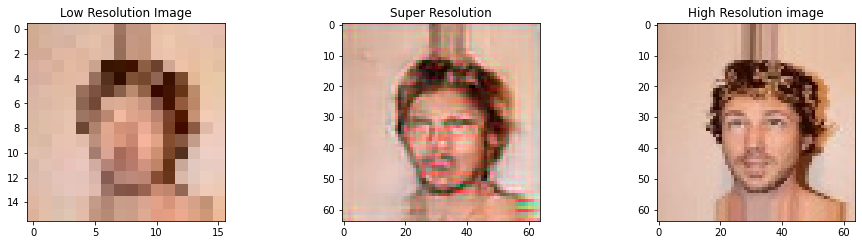

In [20]:
#Testing the performance of the model by selecting random image

from keras.models import load_model

generator = load_model('output/generated_e50.h5', compile=False)

img_id = np.random.randint(0, len(lr_test), 1)
inp_image = lr_test[img_id]
final_image = hr_test[img_id]
gen_image = generator.predict(inp_image)

#Plotting images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Low Resolution Image')
plt.imshow(inp_image[0,:,:,:])
plt.subplot(232)
plt.title('Super Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('High Resolution image')
plt.imshow(final_image[0,:,:,:])

plt.show()

### Sources

[1] "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" by Christian Ledig et al.